In [90]:
import os
import sys
import aim

os.environ["CONFIG_PATHS"] = "../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../data/moves_10"'
sys.path.append("../src")

import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import time
from torch.utils.data import TensorDataset, DataLoader
from display import Display
from configuration import moves_data, config

In [91]:
from neural_net import NeuralNet
from training.load_games import load_games

In [92]:
BATCH_SIZE = 64
MOVES = moves_data()

In [93]:
GAMES_DIR = "../data/2024-11-14_00-14-19-funduline/games"

In [94]:
train_data, test_data = load_games(GAMES_DIR)

train_dataset = TensorDataset(*train_data)
test_dataset = TensorDataset(*test_data)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Reserving 614 files for testing.
Bad zip file: ../data/2024-11-14_00-14-19-funduline/games/1731605802620.npz
Loaded 255540 training samples.
Loaded 28468 testing samples.


In [95]:
run = aim.Run(repo='~/Dev/blockus/.aim')
run["games_dir"] = GAMES_DIR


In [96]:
def _print_losses(value_loss, policy_loss, accuracy=None):
    print("   Avg value loss:  ", value_loss)
    print("   Avg policy loss: ", policy_loss)
    print("   Avg total loss:  ", value_loss + policy_loss)
    if accuracy:
        print("   Accuracy:  ", accuracy)

def _train(dataloader, optimizer, model, value_losses, policy_losses):
    size = len(dataloader.dataset)
    model.train()
    for batch, (occupancies, children_visits, values) in tqdm(enumerate(dataloader)):
        start_time = time.time()

        batch_size = len(occupancies)

        occupancies = occupancies.to("mps")
        children_visits = children_visits.to("mps")
        values = values.to("mps")

        pred_values, pred_children_visits = model(occupancies)

        value_loss = nn.CrossEntropyLoss()(pred_values, values)
        policy_loss = 0.158 * nn.CrossEntropyLoss()(pred_children_visits, children_visits)
        loss = value_loss + policy_loss

        if batch % 1 == 0:
            predicted_winners = np.argmax(pred_values.numpy(force=True), axis=1)
            predicted_winner_real_scores = values.numpy(force=True)[
                np.arange(len(predicted_winners)),
                predicted_winners,
            ]
            correct_winner_count = np.sum(predicted_winner_real_scores > 0)
            run.track(
                correct_winner_count / batch_size,
                name="correct_winner_accuracy",
                step=batch,
            )

        run.track(
            value_loss.item(),
            name="value_loss",
            step=batch,
        )
        run.track(
            policy_loss.item(),
            name="policy_loss",
            step=batch,
        )
        run.track(
            loss.item(),
            name="total_loss",
            step=batch,
        )        

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        current = (batch + 1) * batch_size 
        runtime = time.time() - start_time
        print(f"Training [{current:>5d}/{size:>5d}] [{runtime / batch_size:e}s per sample]")

    value_losses.append(value_loss.item())
    policy_losses.append(policy_loss.item())

# def _test(dataloader, model, value_losses, policy_losses):
#     size = len(dataloader.dataset)
#     model.eval()

#     sum_value_loss, sum_policy_loss = 0.0, 0.0
#     correct_winner_count = 0
#     correct_stupid_winner_count = 0

#     with torch.no_grad():
#         for occupancies, children_visits, values in dataloader:
#             occupancies = occupancies.to("mps")
#             children_visits = children_visits.to("mps")
#             values = values.to("mps")

#             pred_values, pred_children_visits = model(occupancies)         
#             sum_value_loss += nn.CrossEntropyLoss(reduction="sum")(pred_values, values).item()
#             sum_policy_loss += 0.158 * nn.CrossEntropyLoss(reduction="sum")(pred_children_visits, children_visits).item()

#             pred_values = pred_values.numpy(force=True)
#             values = values.numpy(force=True)

#             stupid_predicted_winners = np.argmax(np.sum(occupancies.numpy(force=True), axis=(2, 3)), axis=1)
#             predicted_winners = np.argmax(pred_values, axis=1)
#             predicted_winner_real_scores = values[
#                 np.arange(len(predicted_winners)),
#                 predicted_winners,
#             ]
#             correct_winner_count += np.sum(predicted_winner_real_scores > 0)

#             stupid_predicted_winner_real_scores =  values[
#                 np.arange(len(stupid_predicted_winners)),
#                 stupid_predicted_winners,
#             ]
#             correct_stupid_winner_count += np.sum(stupid_predicted_winner_real_scores > 0)

#     value_loss = sum_value_loss / size
#     policy_loss = sum_policy_loss / size
#     accuracy = correct_winner_count / size

#     value_losses.append(value_loss)
#     policy_losses.append(policy_loss)
#     print("Test Error:")
#     _print_losses(
#         value_loss,
#         policy_loss,
#     )
#     print("Smart accuracy: ", accuracy)
#     print("Stupid accuracy: ", correct_stupid_winner_count / size)

In [97]:
torch.set_num_threads(1)

model = NeuralNet(config()["networks"]["default"], load_model=False).to("mps")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [98]:
epochs = 1
test_value_losses = []
test_policy_losses = []
train_value_losses = []
train_policy_losses = []

try:
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        _train(train_dataloader, optimizer, model, train_value_losses, train_policy_losses)
        # _test(test_dataloader, model, test_value_losses, test_policy_losses)
except KeyboardInterrupt:
    print("Training interrupted.")
run.close()

Epoch 1
-------------------------------


1it [00:00,  9.86it/s]

Training [   64/255540] [1.498170e-03s per sample]


4it [00:00, 10.14it/s]

Training [  128/255540] [3.552690e-03s per sample]
Training [  192/255540] [8.143447e-04s per sample]
Training [  256/255540] [7.378608e-04s per sample]
Training [  320/255540] [6.999671e-04s per sample]
Training [  384/255540] [7.051714e-04s per sample]


10it [00:00, 16.66it/s]

Training [  448/255540] [6.994344e-04s per sample]
Training [  512/255540] [7.498749e-04s per sample]
Training [  576/255540] [7.146373e-04s per sample]
Training [  640/255540] [7.202849e-04s per sample]
Training [  704/255540] [6.997809e-04s per sample]


15it [00:00, 17.26it/s]

Training [  768/255540] [7.533915e-04s per sample]
Training [  832/255540] [7.182620e-04s per sample]
Training [  896/255540] [7.239580e-04s per sample]
Training [  960/255540] [1.239311e-03s per sample]


20it [00:01, 18.57it/s]

Training [ 1024/255540] [8.587204e-04s per sample]
Training [ 1088/255540] [7.028766e-04s per sample]
Training [ 1152/255540] [7.392690e-04s per sample]
Training [ 1216/255540] [7.443614e-04s per sample]
Training [ 1280/255540] [7.203110e-04s per sample]


23it [00:01, 19.21it/s]

Training [ 1344/255540] [7.505156e-04s per sample]
Training [ 1408/255540] [7.414855e-04s per sample]
Training [ 1472/255540] [7.090643e-04s per sample]
Training [ 1536/255540] [7.210784e-04s per sample]
Training [ 1600/255540] [7.172637e-04s per sample]


29it [00:01, 20.07it/s]

Training [ 1664/255540] [7.749237e-04s per sample]
Training [ 1728/255540] [7.318594e-04s per sample]
Training [ 1792/255540] [7.006228e-04s per sample]
Training [ 1856/255540] [7.102042e-04s per sample]
Training [ 1920/255540] [6.969981e-04s per sample]


35it [00:01, 20.58it/s]

Training [ 1984/255540] [7.348098e-04s per sample]
Training [ 2048/255540] [7.315166e-04s per sample]
Training [ 2112/255540] [7.346720e-04s per sample]
Training [ 2176/255540] [7.146262e-04s per sample]
Training [ 2240/255540] [6.970167e-04s per sample]


38it [00:02, 19.39it/s]

Training [ 2304/255540] [1.224827e-03s per sample]
Training [ 2368/255540] [7.302351e-04s per sample]
Training [ 2432/255540] [6.999411e-04s per sample]
Training [ 2496/255540] [7.200763e-04s per sample]
Training [ 2560/255540] [7.340945e-04s per sample]


44it [00:02, 20.12it/s]

Training [ 2624/255540] [7.178895e-04s per sample]
Training [ 2688/255540] [7.420816e-04s per sample]
Training [ 2752/255540] [7.415116e-04s per sample]
Training [ 2816/255540] [6.879829e-04s per sample]
Training [ 2880/255540] [7.024519e-04s per sample]


50it [00:02, 20.68it/s]

Training [ 2944/255540] [7.105917e-04s per sample]
Training [ 3008/255540] [7.182807e-04s per sample]
Training [ 3072/255540] [7.296689e-04s per sample]
Training [ 3136/255540] [7.142015e-04s per sample]
Training [ 3200/255540] [6.968305e-04s per sample]


53it [00:02, 20.85it/s]

Training [ 3264/255540] [7.103905e-04s per sample]
Training [ 3328/255540] [7.091574e-04s per sample]
Training [ 3392/255540] [7.104240e-04s per sample]
Training [ 3456/255540] [7.238723e-04s per sample]
Training [ 3520/255540] [6.933920e-04s per sample]


59it [00:03, 21.04it/s]

Training [ 3584/255540] [7.268749e-04s per sample]
Training [ 3648/255540] [7.128567e-04s per sample]
Training [ 3712/255540] [7.029027e-04s per sample]
Training [ 3776/255540] [7.093102e-04s per sample]
Training [ 3840/255540] [7.090941e-04s per sample]


65it [00:03, 21.07it/s]

Training [ 3904/255540] [7.148609e-04s per sample]
Training [ 3968/255540] [7.483289e-04s per sample]
Training [ 4032/255540] [7.315315e-04s per sample]
Training [ 4096/255540] [7.198751e-04s per sample]
Training [ 4160/255540] [6.839186e-04s per sample]


68it [00:03, 21.10it/s]

Training [ 4224/255540] [7.267967e-04s per sample]
Training [ 4288/255540] [7.212311e-04s per sample]
Training [ 4352/255540] [6.975308e-04s per sample]
Training [ 4416/255540] [7.333271e-04s per sample]
Training [ 4480/255540] [7.237829e-04s per sample]


74it [00:03, 20.95it/s]

Training [ 4544/255540] [7.263161e-04s per sample]
Training [ 4608/255540] [7.342659e-04s per sample]
Training [ 4672/255540] [7.252470e-04s per sample]
Training [ 4736/255540] [7.220171e-04s per sample]
Training [ 4800/255540] [7.120483e-04s per sample]


80it [00:04, 21.05it/s]

Training [ 4864/255540] [7.137693e-04s per sample]
Training [ 4928/255540] [7.126704e-04s per sample]
Training [ 4992/255540] [7.330477e-04s per sample]
Training [ 5056/255540] [7.050000e-04s per sample]
Training [ 5120/255540] [7.062778e-04s per sample]


83it [00:04, 19.66it/s]

Training [ 5184/255540] [1.265217e-03s per sample]
Training [ 5248/255540] [7.018447e-04s per sample]
Training [ 5312/255540] [7.013604e-04s per sample]
Training [ 5376/255540] [7.226057e-04s per sample]
Training [ 5440/255540] [6.964207e-04s per sample]


89it [00:04, 20.41it/s]

Training [ 5504/255540] [7.423609e-04s per sample]
Training [ 5568/255540] [7.359833e-04s per sample]
Training [ 5632/255540] [7.059835e-04s per sample]
Training [ 5696/255540] [6.837510e-04s per sample]
Training [ 5760/255540] [6.924979e-04s per sample]


95it [00:04, 20.73it/s]

Training [ 5824/255540] [7.228293e-04s per sample]
Training [ 5888/255540] [7.177629e-04s per sample]
Training [ 5952/255540] [7.282794e-04s per sample]
Training [ 6016/255540] [7.483773e-04s per sample]
Training [ 6080/255540] [6.886534e-04s per sample]


98it [00:05, 20.90it/s]

Training [ 6144/255540] [7.243715e-04s per sample]
Training [ 6208/255540] [6.961301e-04s per sample]
Training [ 6272/255540] [7.102042e-04s per sample]
Training [ 6336/255540] [7.030591e-04s per sample]
Training [ 6400/255540] [7.206909e-04s per sample]


104it [00:05, 21.06it/s]

Training [ 6464/255540] [7.141419e-04s per sample]
Training [ 6528/255540] [7.275157e-04s per sample]
Training [ 6592/255540] [7.113293e-04s per sample]
Training [ 6656/255540] [6.909035e-04s per sample]
Training [ 6720/255540] [6.954260e-04s per sample]


110it [00:05, 21.10it/s]

Training [ 6784/255540] [7.618591e-04s per sample]
Training [ 6848/255540] [7.290170e-04s per sample]
Training [ 6912/255540] [7.102378e-04s per sample]
Training [ 6976/255540] [7.089376e-04s per sample]
Training [ 7040/255540] [6.833114e-04s per sample]


113it [00:05, 21.19it/s]

Training [ 7104/255540] [7.142872e-04s per sample]
Training [ 7168/255540] [7.100031e-04s per sample]
Training [ 7232/255540] [6.913282e-04s per sample]
Training [ 7296/255540] [7.345304e-04s per sample]
Training [ 7360/255540] [6.910823e-04s per sample]


119it [00:06, 21.16it/s]

Training [ 7424/255540] [7.352456e-04s per sample]
Training [ 7488/255540] [7.359572e-04s per sample]
Training [ 7552/255540] [7.164851e-04s per sample]
Training [ 7616/255540] [6.818324e-04s per sample]
Training [ 7680/255540] [7.025152e-04s per sample]


125it [00:06, 21.02it/s]

Training [ 7744/255540] [7.412061e-04s per sample]
Training [ 7808/255540] [7.004403e-04s per sample]
Training [ 7872/255540] [7.366985e-04s per sample]
Training [ 7936/255540] [7.550642e-04s per sample]
Training [ 8000/255540] [6.949566e-04s per sample]


128it [00:06, 21.03it/s]

Training [ 8064/255540] [7.329099e-04s per sample]
Training [ 8128/255540] [7.017963e-04s per sample]
Training [ 8192/255540] [7.090643e-04s per sample]
Training [ 8256/255540] [8.677505e-04s per sample]
Training [ 8320/255540] [7.114187e-04s per sample]


134it [00:06, 19.42it/s]

Training [ 8384/255540] [7.256866e-04s per sample]
Training [ 8448/255540] [1.274716e-03s per sample]
Training [ 8512/255540] [6.835014e-04s per sample]
Training [ 8576/255540] [7.037222e-04s per sample]


137it [00:06, 19.85it/s]

Training [ 8640/255540] [7.167645e-04s per sample]
Training [ 8704/255540] [7.535778e-04s per sample]
Training [ 8768/255540] [6.856695e-04s per sample]
Training [ 8832/255540] [7.496700e-04s per sample]
Training [ 8896/255540] [7.274561e-04s per sample]


143it [00:07, 20.39it/s]

Training [ 8960/255540] [7.306896e-04s per sample]
Training [ 9024/255540] [7.120185e-04s per sample]
Training [ 9088/255540] [7.001571e-04s per sample]
Training [ 9152/255540] [6.811284e-04s per sample]
Training [ 9216/255540] [7.076114e-04s per sample]


149it [00:07, 20.74it/s]

Training [ 9280/255540] [7.209703e-04s per sample]
Training [ 9344/255540] [7.167645e-04s per sample]
Training [ 9408/255540] [7.259995e-04s per sample]
Training [ 9472/255540] [7.031225e-04s per sample]
Training [ 9536/255540] [7.152967e-04s per sample]


152it [00:07, 20.96it/s]

Training [ 9600/255540] [7.240474e-04s per sample]
Training [ 9664/255540] [6.993003e-04s per sample]
Training [ 9728/255540] [6.895773e-04s per sample]
Training [ 9792/255540] [7.169656e-04s per sample]
Training [ 9856/255540] [7.313453e-04s per sample]


158it [00:07, 20.95it/s]

Training [ 9920/255540] [7.125475e-04s per sample]
Training [ 9984/255540] [7.468127e-04s per sample]
Training [10048/255540] [7.183626e-04s per sample]
Training [10112/255540] [6.851703e-04s per sample]
Training [10176/255540] [6.593466e-04s per sample]


164it [00:08, 21.08it/s]

Training [10240/255540] [7.290319e-04s per sample]
Training [10304/255540] [6.852821e-04s per sample]
Training [10368/255540] [7.332489e-04s per sample]
Training [10432/255540] [6.934367e-04s per sample]
Training [10496/255540] [7.034093e-04s per sample]


167it [00:08, 21.06it/s]

Training [10560/255540] [6.893426e-04s per sample]
Training [10624/255540] [7.500648e-04s per sample]
Training [10688/255540] [6.765798e-04s per sample]
Training [10752/255540] [7.472038e-04s per sample]
Training [10816/255540] [7.236414e-04s per sample]


173it [00:08, 21.15it/s]

Training [10880/255540] [7.251389e-04s per sample]
Training [10944/255540] [7.009991e-04s per sample]
Training [11008/255540] [7.099360e-04s per sample]
Training [11072/255540] [6.332472e-04s per sample]
Training [11136/255540] [7.000342e-04s per sample]


179it [00:08, 21.15it/s]

Training [11200/255540] [7.159673e-04s per sample]
Training [11264/255540] [7.406399e-04s per sample]
Training [11328/255540] [7.234551e-04s per sample]
Training [11392/255540] [7.140487e-04s per sample]
Training [11456/255540] [6.573014e-04s per sample]


182it [00:09, 21.18it/s]

Training [11520/255540] [7.370152e-04s per sample]
Training [11584/255540] [7.047616e-04s per sample]
Training [11648/255540] [6.822497e-04s per sample]
Training [11712/255540] [1.264576e-03s per sample]


188it [00:09, 19.89it/s]

Training [11776/255540] [7.165484e-04s per sample]
Training [11840/255540] [7.215329e-04s per sample]
Training [11904/255540] [7.325150e-04s per sample]
Training [11968/255540] [7.264726e-04s per sample]
Training [12032/255540] [7.477179e-04s per sample]


191it [00:09, 20.25it/s]

Training [12096/255540] [7.271841e-04s per sample]
Training [12160/255540] [7.374249e-04s per sample]
Training [12224/255540] [6.793141e-04s per sample]
Training [12288/255540] [7.004514e-04s per sample]
Training [12352/255540] [7.129386e-04s per sample]


197it [00:09, 20.56it/s]

Training [12416/255540] [7.467382e-04s per sample]
Training [12480/255540] [7.414520e-04s per sample]
Training [12544/255540] [7.231720e-04s per sample]
Training [12608/255540] [7.137358e-04s per sample]
Training [12672/255540] [7.087365e-04s per sample]


203it [00:10, 20.88it/s]

Training [12736/255540] [7.332452e-04s per sample]
Training [12800/255540] [7.314347e-04s per sample]
Training [12864/255540] [6.749406e-04s per sample]
Training [12928/255540] [6.982014e-04s per sample]
Training [12992/255540] [6.838590e-04s per sample]


206it [00:10, 21.02it/s]

Training [13056/255540] [7.138737e-04s per sample]
Training [13120/255540] [7.098131e-04s per sample]
Training [13184/255540] [6.935932e-04s per sample]
Training [13248/255540] [6.851740e-04s per sample]
Training [13312/255540] [7.201694e-04s per sample]


212it [00:10, 20.95it/s]

Training [13376/255540] [7.349364e-04s per sample]
Training [13440/255540] [7.302798e-04s per sample]
Training [13504/255540] [7.369071e-04s per sample]
Training [13568/255540] [6.941073e-04s per sample]
Training [13632/255540] [7.020421e-04s per sample]


218it [00:10, 21.03it/s]

Training [13696/255540] [7.244386e-04s per sample]
Training [13760/255540] [6.978884e-04s per sample]
Training [13824/255540] [7.295758e-04s per sample]
Training [13888/255540] [7.416904e-04s per sample]
Training [13952/255540] [6.794222e-04s per sample]


221it [00:10, 21.10it/s]

Training [14016/255540] [7.225163e-04s per sample]
Training [14080/255540] [7.045493e-04s per sample]
Training [14144/255540] [6.642826e-04s per sample]
Training [14208/255540] [7.370785e-04s per sample]
Training [14272/255540] [7.109419e-04s per sample]


227it [00:11, 21.14it/s]

Training [14336/255540] [7.419065e-04s per sample]
Training [14400/255540] [7.007346e-04s per sample]
Training [14464/255540] [6.940179e-04s per sample]
Training [14528/255540] [6.841719e-04s per sample]
Training [14592/255540] [7.077456e-04s per sample]


230it [00:11, 21.01it/s]

Training [14656/255540] [7.180944e-04s per sample]
Training [14720/255540] [7.511266e-04s per sample]
Training [14784/255540] [1.231607e-03s per sample]
Training [14848/255540] [7.011108e-04s per sample]


236it [00:11, 20.04it/s]

Training [14912/255540] [6.977543e-04s per sample]
Training [14976/255540] [7.268749e-04s per sample]
Training [15040/255540] [7.209033e-04s per sample]
Training [15104/255540] [7.410496e-04s per sample]
Training [15168/255540] [7.105172e-04s per sample]


242it [00:11, 20.54it/s]

Training [15232/255540] [7.277653e-04s per sample]
Training [15296/255540] [6.795004e-04s per sample]
Training [15360/255540] [7.224232e-04s per sample]
Training [15424/255540] [7.164851e-04s per sample]
Training [15488/255540] [7.124394e-04s per sample]


245it [00:12, 20.71it/s]

Training [15552/255540] [6.902479e-04s per sample]
Training [15616/255540] [7.349513e-04s per sample]
Training [15680/255540] [6.887130e-04s per sample]
Training [15744/255540] [7.266700e-04s per sample]
Training [15808/255540] [7.074252e-04s per sample]


251it [00:12, 20.90it/s]

Training [15872/255540] [7.315464e-04s per sample]
Training [15936/255540] [7.254519e-04s per sample]
Training [16000/255540] [7.189177e-04s per sample]
Training [16064/255540] [6.641559e-04s per sample]
Training [16128/255540] [7.015653e-04s per sample]


257it [00:12, 21.10it/s]

Training [16192/255540] [7.210933e-04s per sample]
Training [16256/255540] [7.045940e-04s per sample]
Training [16320/255540] [7.315651e-04s per sample]
Training [16384/255540] [7.169843e-04s per sample]
Training [16448/255540] [6.590933e-04s per sample]


260it [00:12, 21.09it/s]

Training [16512/255540] [7.345006e-04s per sample]
Training [16576/255540] [7.095747e-04s per sample]
Training [16640/255540] [7.031262e-04s per sample]
Training [16704/255540] [7.417351e-04s per sample]
Training [16768/255540] [7.287487e-04s per sample]


266it [00:13, 21.10it/s]

Training [16832/255540] [6.887801e-04s per sample]
Training [16896/255540] [7.471442e-04s per sample]
Training [16960/255540] [6.935000e-04s per sample]
Training [17024/255540] [6.872788e-04s per sample]
Training [17088/255540] [9.107664e-04s per sample]


272it [00:13, 20.74it/s]

Training [17152/255540] [7.281080e-04s per sample]
Training [17216/255540] [7.114969e-04s per sample]
Training [17280/255540] [7.207952e-04s per sample]
Training [17344/255540] [7.164069e-04s per sample]
Training [17408/255540] [7.045306e-04s per sample]


275it [00:13, 20.95it/s]

Training [17472/255540] [7.126108e-04s per sample]
Training [17536/255540] [7.076710e-04s per sample]
Training [17600/255540] [6.849654e-04s per sample]
Training [17664/255540] [7.269979e-04s per sample]
Training [17728/255540] [7.303581e-04s per sample]


281it [00:13, 19.59it/s]

Training [17792/255540] [7.315613e-04s per sample]
Training [17856/255540] [1.257762e-03s per sample]
Training [17920/255540] [7.203743e-04s per sample]
Training [17984/255540] [6.919354e-04s per sample]


284it [00:14, 20.02it/s]

Training [18048/255540] [7.205904e-04s per sample]
Training [18112/255540] [7.155910e-04s per sample]
Training [18176/255540] [7.150471e-04s per sample]
Training [18240/255540] [7.437617e-04s per sample]
Training [18304/255540] [7.462949e-04s per sample]


290it [00:14, 20.36it/s]

Training [18368/255540] [7.252991e-04s per sample]
Training [18432/255540] [7.425658e-04s per sample]
Training [18496/255540] [7.143095e-04s per sample]
Training [18560/255540] [7.228777e-04s per sample]
Training [18624/255540] [6.924830e-04s per sample]


296it [00:14, 20.76it/s]

Training [18688/255540] [7.245764e-04s per sample]
Training [18752/255540] [7.039681e-04s per sample]
Training [18816/255540] [7.408299e-04s per sample]
Training [18880/255540] [7.332675e-04s per sample]
Training [18944/255540] [6.807633e-04s per sample]


299it [00:14, 20.76it/s]

Training [19008/255540] [7.266700e-04s per sample]
Training [19072/255540] [7.231906e-04s per sample]
Training [19136/255540] [7.367171e-04s per sample]
Training [19200/255540] [7.176884e-04s per sample]
Training [19264/255540] [7.063001e-04s per sample]


305it [00:15, 20.82it/s]

Training [19328/255540] [7.280484e-04s per sample]
Training [19392/255540] [7.353723e-04s per sample]
Training [19456/255540] [7.405020e-04s per sample]
Training [19520/255540] [6.767027e-04s per sample]
Training [19584/255540] [7.740185e-04s per sample]


311it [00:15, 20.48it/s]

Training [19648/255540] [7.385500e-04s per sample]
Training [19712/255540] [7.208586e-04s per sample]
Training [19776/255540] [8.590296e-04s per sample]
Training [19840/255540] [7.229857e-04s per sample]
Training [19904/255540] [6.821230e-04s per sample]


314it [00:15, 20.54it/s]

Training [19968/255540] [7.395148e-04s per sample]
Training [20032/255540] [7.243454e-04s per sample]
Training [20096/255540] [7.372014e-04s per sample]
Training [20160/255540] [7.079840e-04s per sample]
Training [20224/255540] [7.217973e-04s per sample]


320it [00:15, 20.84it/s]

Training [20288/255540] [7.454827e-04s per sample]
Training [20352/255540] [7.135347e-04s per sample]
Training [20416/255540] [6.832667e-04s per sample]
Training [20480/255540] [7.299669e-04s per sample]
Training [20544/255540] [7.205643e-04s per sample]


326it [00:16, 21.02it/s]

Training [20608/255540] [7.223003e-04s per sample]
Training [20672/255540] [7.227808e-04s per sample]
Training [20736/255540] [7.089041e-04s per sample]
Training [20800/255540] [6.833747e-04s per sample]
Training [20864/255540] [7.362664e-04s per sample]


329it [00:16, 19.59it/s]

Training [20928/255540] [7.224977e-04s per sample]
Training [20992/255540] [7.433444e-04s per sample]
Training [21056/255540] [1.231860e-03s per sample]
Training [21120/255540] [7.153898e-04s per sample]


335it [00:16, 20.25it/s]

Training [21184/255540] [7.204711e-04s per sample]
Training [21248/255540] [7.216446e-04s per sample]
Training [21312/255540] [7.341467e-04s per sample]
Training [21376/255540] [7.092021e-04s per sample]
Training [21440/255540] [7.297620e-04s per sample]


338it [00:16, 20.52it/s]

Training [21504/255540] [7.256567e-04s per sample]
Training [21568/255540] [7.234998e-04s per sample]
Training [21632/255540] [6.930344e-04s per sample]
Training [21696/255540] [7.114522e-04s per sample]
Training [21760/255540] [7.216223e-04s per sample]


344it [00:16, 20.70it/s]

Training [21824/255540] [7.499382e-04s per sample]
Training [21888/255540] [7.372350e-04s per sample]
Training [21952/255540] [7.143095e-04s per sample]
Training [22016/255540] [7.152967e-04s per sample]
Training [22080/255540] [7.022806e-04s per sample]


350it [00:17, 20.79it/s]

Training [22144/255540] [7.255748e-04s per sample]
Training [22208/255540] [7.155165e-04s per sample]
Training [22272/255540] [7.566102e-04s per sample]
Training [22336/255540] [7.174388e-04s per sample]
Training [22400/255540] [7.285774e-04s per sample]


353it [00:17, 20.90it/s]

Training [22464/255540] [7.117353e-04s per sample]
Training [22528/255540] [7.327795e-04s per sample]
Training [22592/255540] [6.908439e-04s per sample]
Training [22656/255540] [7.326566e-04s per sample]
Training [22720/255540] [7.324368e-04s per sample]


359it [00:17, 20.93it/s]

Training [22784/255540] [7.305145e-04s per sample]
Training [22848/255540] [6.659999e-04s per sample]
Training [22912/255540] [7.519871e-04s per sample]
Training [22976/255540] [6.915480e-04s per sample]
Training [23040/255540] [7.019863e-04s per sample]


365it [00:17, 20.99it/s]

Training [23104/255540] [7.407181e-04s per sample]
Training [23168/255540] [7.130615e-04s per sample]
Training [23232/255540] [7.331222e-04s per sample]
Training [23296/255540] [7.174090e-04s per sample]
Training [23360/255540] [7.106997e-04s per sample]


368it [00:18, 21.13it/s]

Training [23424/255540] [7.409491e-04s per sample]
Training [23488/255540] [6.804205e-04s per sample]
Training [23552/255540] [6.844401e-04s per sample]
Training [23616/255540] [7.455759e-04s per sample]
Training [23680/255540] [7.478595e-04s per sample]


374it [00:18, 19.62it/s]

Training [23744/255540] [7.262789e-04s per sample]
Training [23808/255540] [1.235254e-03s per sample]
Training [23872/255540] [7.351376e-04s per sample]
Training [23936/255540] [6.978288e-04s per sample]


377it [00:18, 19.94it/s]

Training [24000/255540] [7.150583e-04s per sample]
Training [24064/255540] [7.447340e-04s per sample]
Training [24128/255540] [7.305443e-04s per sample]
Training [24192/255540] [7.455423e-04s per sample]
Training [24256/255540] [7.084534e-04s per sample]


383it [00:18, 20.60it/s]

Training [24320/255540] [7.235445e-04s per sample]
Training [24384/255540] [6.886385e-04s per sample]
Training [24448/255540] [6.917007e-04s per sample]
Training [24512/255540] [6.591417e-04s per sample]
Training [24576/255540] [7.337034e-04s per sample]


389it [00:19, 20.26it/s]

Training [24640/255540] [8.491389e-04s per sample]
Training [24704/255540] [7.055588e-04s per sample]
Training [24768/255540] [7.337965e-04s per sample]
Training [24832/255540] [7.207654e-04s per sample]
Training [24896/255540] [8.093268e-04s per sample]


392it [00:19, 20.35it/s]

Training [24960/255540] [7.491559e-04s per sample]
Training [25024/255540] [7.159673e-04s per sample]
Training [25088/255540] [7.287674e-04s per sample]
Training [25152/255540] [7.252842e-04s per sample]
Training [25216/255540] [7.577054e-04s per sample]


398it [00:19, 20.53it/s]

Training [25280/255540] [7.190965e-04s per sample]
Training [25344/255540] [7.281229e-04s per sample]
Training [25408/255540] [7.476062e-04s per sample]
Training [25472/255540] [7.015280e-04s per sample]
Training [25536/255540] [7.331558e-04s per sample]


404it [00:19, 20.64it/s]

Training [25600/255540] [7.263012e-04s per sample]
Training [25664/255540] [6.782524e-04s per sample]
Training [25728/255540] [7.345751e-04s per sample]
Training [25792/255540] [7.236563e-04s per sample]
Training [25856/255540] [7.363893e-04s per sample]


407it [00:19, 20.84it/s]

Training [25920/255540] [7.224232e-04s per sample]
Training [25984/255540] [7.208437e-04s per sample]
Training [26048/255540] [6.852970e-04s per sample]
Training [26112/255540] [7.493570e-04s per sample]
Training [26176/255540] [7.083863e-04s per sample]


413it [00:20, 20.86it/s]

Training [26240/255540] [7.267781e-04s per sample]
Training [26304/255540] [6.987043e-04s per sample]
Training [26368/255540] [7.343926e-04s per sample]
Training [26432/255540] [6.993599e-04s per sample]
Training [26496/255540] [7.089041e-04s per sample]


416it [00:20, 20.89it/s]

Training [26560/255540] [7.176884e-04s per sample]
Training [26624/255540] [7.404238e-04s per sample]
Training [26688/255540] [1.214564e-03s per sample]
Training [26752/255540] [7.184036e-04s per sample]


422it [00:20, 20.00it/s]

Training [26816/255540] [7.133447e-04s per sample]
Training [26880/255540] [7.226914e-04s per sample]
Training [26944/255540] [6.910302e-04s per sample]
Training [27008/255540] [7.347353e-04s per sample]
Training [27072/255540] [6.940775e-04s per sample]


428it [00:21, 20.59it/s]

Training [27136/255540] [7.203892e-04s per sample]
Training [27200/255540] [7.298589e-04s per sample]
Training [27264/255540] [7.097349e-04s per sample]
Training [27328/255540] [6.679520e-04s per sample]
Training [27392/255540] [7.244274e-04s per sample]


431it [00:21, 20.71it/s]

Training [27456/255540] [6.631091e-04s per sample]
Training [27520/255540] [7.405318e-04s per sample]
Training [27584/255540] [7.313788e-04s per sample]
Training [27648/255540] [7.442199e-04s per sample]
Training [27712/255540] [7.226244e-04s per sample]


437it [00:21, 20.71it/s]

Training [27776/255540] [8.335002e-04s per sample]
Training [27840/255540] [7.105917e-04s per sample]
Training [27904/255540] [7.115006e-04s per sample]
Training [27968/255540] [6.853864e-04s per sample]
Training [28032/255540] [7.319823e-04s per sample]


443it [00:21, 21.00it/s]

Training [28096/255540] [6.779246e-04s per sample]
Training [28160/255540] [7.175468e-04s per sample]
Training [28224/255540] [7.148460e-04s per sample]
Training [28288/255540] [6.886125e-04s per sample]
Training [28352/255540] [6.634966e-04s per sample]


446it [00:21, 19.25it/s]

Training [28416/255540] [7.465482e-04s per sample]
Training [28480/255540] [7.143915e-04s per sample]
Training [28544/255540] [1.369394e-03s per sample]
Training [28608/255540] [7.752478e-04s per sample]


452it [00:22, 19.91it/s]

Training [28672/255540] [7.299371e-04s per sample]
Training [28736/255540] [7.178448e-04s per sample]
Training [28800/255540] [7.264204e-04s per sample]
Training [28864/255540] [7.463768e-04s per sample]
Training [28928/255540] [7.249676e-04s per sample]


455it [00:22, 19.95it/s]

Training [28992/255540] [7.161722e-04s per sample]
Training [29056/255540] [8.641258e-04s per sample]
Training [29120/255540] [6.771125e-04s per sample]
Training [29184/255540] [7.171258e-04s per sample]
Training [29248/255540] [6.622486e-04s per sample]


461it [00:22, 19.06it/s]

Training [29312/255540] [7.270165e-04s per sample]
Training [29376/255540] [1.326844e-03s per sample]
Training [29440/255540] [7.226430e-04s per sample]
Training [29504/255540] [6.979518e-04s per sample]


464it [00:22, 19.64it/s]

Training [29568/255540] [7.461719e-04s per sample]
Training [29632/255540] [6.653927e-04s per sample]
Training [29696/255540] [6.973147e-04s per sample]
Training [29760/255540] [7.221848e-04s per sample]
Training [29824/255540] [7.085316e-04s per sample]


470it [00:23, 20.21it/s]

Training [29888/255540] [7.291138e-04s per sample]
Training [29952/255540] [7.428601e-04s per sample]
Training [30016/255540] [6.746240e-04s per sample]
Training [30080/255540] [7.414855e-04s per sample]
Training [30144/255540] [6.729811e-04s per sample]


476it [00:23, 20.63it/s]

Training [30208/255540] [7.146746e-04s per sample]
Training [30272/255540] [7.213280e-04s per sample]
Training [30336/255540] [7.339083e-04s per sample]
Training [30400/255540] [7.105656e-04s per sample]
Training [30464/255540] [7.183440e-04s per sample]


479it [00:23, 20.44it/s]

Training [30528/255540] [6.598718e-04s per sample]
Training [30592/255540] [8.235760e-04s per sample]
Training [30656/255540] [7.292554e-04s per sample]
Training [30720/255540] [7.349811e-04s per sample]
Training [30784/255540] [7.191077e-04s per sample]


485it [00:23, 20.76it/s]

Training [30848/255540] [7.258281e-04s per sample]
Training [30912/255540] [7.307194e-04s per sample]
Training [30976/255540] [7.156283e-04s per sample]
Training [31040/255540] [6.869175e-04s per sample]
Training [31104/255540] [7.392503e-04s per sample]


491it [00:24, 20.66it/s]

Training [31168/255540] [7.319525e-04s per sample]
Training [31232/255540] [7.216558e-04s per sample]
Training [31296/255540] [6.607659e-04s per sample]
Training [31360/255540] [7.711239e-04s per sample]
Training [31424/255540] [7.205009e-04s per sample]


494it [00:24, 20.67it/s]

Training [31488/255540] [7.491857e-04s per sample]
Training [31552/255540] [7.083602e-04s per sample]
Training [31616/255540] [7.400773e-04s per sample]
Training [31680/255540] [7.194988e-04s per sample]
Training [31744/255540] [7.371232e-04s per sample]


500it [00:24, 20.38it/s]

Training [31808/255540] [7.151552e-04s per sample]
Training [31872/255540] [8.532070e-04s per sample]
Training [31936/255540] [7.025786e-04s per sample]
Training [32000/255540] [7.365756e-04s per sample]


503it [00:24, 20.41it/s]

Training [32064/255540] [7.607937e-04s per sample]
Training [32128/255540] [7.132031e-04s per sample]
Training [32192/255540] [7.411689e-04s per sample]
Training [32256/255540] [1.294125e-03s per sample]


509it [00:25, 19.66it/s]

Training [32320/255540] [7.337034e-04s per sample]
Training [32384/255540] [7.186532e-04s per sample]
Training [32448/255540] [7.374994e-04s per sample]
Training [32512/255540] [7.310919e-04s per sample]
Training [32576/255540] [6.860159e-04s per sample]


511it [00:25, 19.42it/s]

Training [32640/255540] [7.561743e-04s per sample]
Training [32704/255540] [8.692630e-04s per sample]
Training [32768/255540] [7.523894e-04s per sample]
Training [32832/255540] [7.203929e-04s per sample]


517it [00:25, 19.98it/s]

Training [32896/255540] [7.218122e-04s per sample]
Training [32960/255540] [7.250495e-04s per sample]
Training [33024/255540] [7.713586e-04s per sample]
Training [33088/255540] [7.409565e-04s per sample]
Training [33152/255540] [7.300936e-04s per sample]


523it [00:25, 20.53it/s]

Training [33216/255540] [7.353574e-04s per sample]
Training [33280/255540] [7.239245e-04s per sample]
Training [33344/255540] [7.257201e-04s per sample]
Training [33408/255540] [7.247180e-04s per sample]
Training [33472/255540] [6.764494e-04s per sample]


526it [00:25, 20.63it/s]

Training [33536/255540] [7.649064e-04s per sample]
Training [33600/255540] [7.115938e-04s per sample]
Training [33664/255540] [7.062517e-04s per sample]
Training [33728/255540] [7.373281e-04s per sample]
Training [33792/255540] [7.356256e-04s per sample]


532it [00:26, 20.82it/s]

Training [33856/255540] [7.149540e-04s per sample]
Training [33920/255540] [7.328726e-04s per sample]
Training [33984/255540] [6.993711e-04s per sample]
Training [34048/255540] [7.203706e-04s per sample]
Training [34112/255540] [7.206872e-04s per sample]


538it [00:26, 20.96it/s]

Training [34176/255540] [7.369705e-04s per sample]
Training [34240/255540] [7.337965e-04s per sample]
Training [34304/255540] [7.198937e-04s per sample]
Training [34368/255540] [6.953888e-04s per sample]
Training [34432/255540] [7.149838e-04s per sample]


541it [00:26, 20.99it/s]

Training [34496/255540] [7.261224e-04s per sample]
Training [34560/255540] [7.317811e-04s per sample]
Training [34624/255540] [6.931238e-04s per sample]
Training [34688/255540] [7.838607e-04s per sample]
Training [34752/255540] [7.392056e-04s per sample]


547it [00:26, 19.09it/s]

Training [34816/255540] [8.176751e-04s per sample]
Training [34880/255540] [1.331937e-03s per sample]
Training [34944/255540] [7.152185e-04s per sample]
Training [35008/255540] [7.118732e-04s per sample]


552it [00:27, 19.78it/s]

Training [35072/255540] [8.127987e-04s per sample]
Training [35136/255540] [7.285774e-04s per sample]
Training [35200/255540] [7.238165e-04s per sample]
Training [35264/255540] [7.158890e-04s per sample]
Training [35328/255540] [7.109866e-04s per sample]


555it [00:27, 20.16it/s]

Training [35392/255540] [7.249378e-04s per sample]
Training [35456/255540] [7.248111e-04s per sample]
Training [35520/255540] [7.078163e-04s per sample]
Training [35584/255540] [7.265136e-04s per sample]
Training [35648/255540] [7.130355e-04s per sample]


561it [00:27, 20.59it/s]

Training [35712/255540] [7.331558e-04s per sample]
Training [35776/255540] [7.099696e-04s per sample]
Training [35840/255540] [7.345304e-04s per sample]
Training [35904/255540] [7.050820e-04s per sample]
Training [35968/255540] [6.998293e-04s per sample]


564it [00:27, 20.62it/s]

Training [36032/255540] [7.529072e-04s per sample]
Training [36096/255540] [7.448904e-04s per sample]
Training [36160/255540] [8.187518e-04s per sample]
Training [36224/255540] [7.790662e-04s per sample]


570it [00:28, 19.65it/s]

Training [36288/255540] [8.205771e-04s per sample]
Training [36352/255540] [8.147694e-04s per sample]
Training [36416/255540] [8.133911e-04s per sample]
Training [36480/255540] [7.863604e-04s per sample]


574it [00:28, 19.33it/s]

Training [36544/255540] [7.842034e-04s per sample]
Training [36608/255540] [8.104257e-04s per sample]
Training [36672/255540] [8.012205e-04s per sample]
Training [36736/255540] [7.925481e-04s per sample]


579it [00:28, 19.80it/s]

Training [36800/255540] [7.700659e-04s per sample]
Training [36864/255540] [7.592067e-04s per sample]
Training [36928/255540] [7.224381e-04s per sample]
Training [36992/255540] [7.674061e-04s per sample]
Training [37056/255540] [7.044822e-04s per sample]


584it [00:28, 20.04it/s]

Training [37120/255540] [7.786714e-04s per sample]
Training [37184/255540] [7.541068e-04s per sample]
Training [37248/255540] [7.350780e-04s per sample]
Training [37312/255540] [7.503740e-04s per sample]
Training [37376/255540] [7.031076e-04s per sample]


588it [00:29, 17.89it/s]

Training [37440/255540] [1.512986e-03s per sample]
Training [37504/255540] [8.133948e-04s per sample]
Training [37568/255540] [8.143745e-04s per sample]
Training [37632/255540] [8.147620e-04s per sample]


592it [00:29, 18.57it/s]

Training [37696/255540] [7.608719e-04s per sample]
Training [37760/255540] [8.311570e-04s per sample]
Training [37824/255540] [7.762499e-04s per sample]
Training [37888/255540] [7.441714e-04s per sample]


595it [00:29, 16.38it/s]

Training [37952/255540] [6.914251e-04s per sample]
Training [38016/255540] [7.672794e-04s per sample]
Training [38080/255540] [1.868702e-03s per sample]


597it [00:29, 16.69it/s]

Training [38144/255540] [8.737929e-04s per sample]
Training [38208/255540] [7.735305e-04s per sample]
Training [38272/255540] [7.695146e-04s per sample]
Training [38336/255540] [7.295012e-04s per sample]


602it [00:29, 18.28it/s]

Training [38400/255540] [7.561110e-04s per sample]
Training [38464/255540] [7.671118e-04s per sample]
Training [38528/255540] [7.660463e-04s per sample]
Training [38592/255540] [7.102042e-04s per sample]
Training [38656/255540] [7.912777e-04s per sample]


607it [00:30, 18.96it/s]

Training [38720/255540] [8.032694e-04s per sample]
Training [38784/255540] [7.877983e-04s per sample]
Training [38848/255540] [7.382780e-04s per sample]
Training [38912/255540] [7.686242e-04s per sample]
Training [38976/255540] [7.178113e-04s per sample]


613it [00:30, 19.67it/s]

Training [39040/255540] [7.850341e-04s per sample]
Training [39104/255540] [6.564818e-04s per sample]
Training [39168/255540] [7.590614e-04s per sample]
Training [39232/255540] [7.556267e-04s per sample]
Training [39296/255540] [7.164367e-04s per sample]


618it [00:30, 19.63it/s]

Training [39360/255540] [7.789657e-04s per sample]
Training [39424/255540] [7.664077e-04s per sample]
Training [39488/255540] [8.137785e-04s per sample]
Training [39552/255540] [7.692538e-04s per sample]


622it [00:30, 18.03it/s]

Training [39616/255540] [7.950477e-04s per sample]
Training [39680/255540] [7.614531e-04s per sample]
Training [39744/255540] [7.747002e-04s per sample]
Training [39808/255540] [1.289312e-03s per sample]


627it [00:31, 17.69it/s]

Training [39872/255540] [1.582999e-03s per sample]
Training [39936/255540] [7.537790e-04s per sample]
Training [40000/255540] [7.353127e-04s per sample]
Training [40064/255540] [7.187314e-04s per sample]
Training [40128/255540] [7.346533e-04s per sample]


630it [00:31, 18.74it/s]

Training [40192/255540] [7.270500e-04s per sample]
Training [40256/255540] [7.224679e-04s per sample]
Training [40320/255540] [7.054359e-04s per sample]
Training [40384/255540] [7.201247e-04s per sample]
Training [40448/255540] [6.946884e-04s per sample]


636it [00:31, 20.15it/s]

Training [40512/255540] [7.368587e-04s per sample]
Training [40576/255540] [7.129684e-04s per sample]
Training [40640/255540] [6.902963e-04s per sample]
Training [40704/255540] [6.858259e-04s per sample]
Training [40768/255540] [7.120818e-04s per sample]


642it [00:31, 20.39it/s]

Training [40832/255540] [7.439032e-04s per sample]
Training [40896/255540] [7.143766e-04s per sample]
Training [40960/255540] [7.588118e-04s per sample]
Training [41024/255540] [7.475503e-04s per sample]
Training [41088/255540] [7.100627e-04s per sample]


645it [00:32, 20.50it/s]

Training [41152/255540] [7.718131e-04s per sample]
Training [41216/255540] [7.243119e-04s per sample]
Training [41280/255540] [6.937794e-04s per sample]
Training [41344/255540] [7.287525e-04s per sample]
Training [41408/255540] [6.938092e-04s per sample]


651it [00:32, 21.07it/s]

Training [41472/255540] [7.319972e-04s per sample]
Training [41536/255540] [6.974079e-04s per sample]
Training [41600/255540] [6.833263e-04s per sample]
Training [41664/255540] [6.860159e-04s per sample]
Training [41728/255540] [6.948933e-04s per sample]


654it [00:32, 20.96it/s]

Training [41792/255540] [7.407852e-04s per sample]
Training [41856/255540] [7.528923e-04s per sample]
Training [41920/255540] [1.356751e-03s per sample]
Training [41984/255540] [8.274987e-04s per sample]


659it [00:32, 19.03it/s]

Training [42048/255540] [7.819980e-04s per sample]
Training [42112/255540] [7.994510e-04s per sample]
Training [42176/255540] [7.435642e-04s per sample]
Training [42240/255540] [7.363558e-04s per sample]
Training [42304/255540] [6.961115e-04s per sample]


664it [00:32, 19.41it/s]

Training [42368/255540] [7.959418e-04s per sample]
Training [42432/255540] [7.829554e-04s per sample]
Training [42496/255540] [7.565431e-04s per sample]
Training [42560/255540] [7.364824e-04s per sample]


669it [00:33, 19.91it/s]

Training [42624/255540] [7.762983e-04s per sample]
Training [42688/255540] [7.537827e-04s per sample]
Training [42752/255540] [7.462054e-04s per sample]
Training [42816/255540] [7.065162e-04s per sample]
Training [42880/255540] [7.167645e-04s per sample]


673it [00:33, 19.42it/s]

Training [42944/255540] [9.431243e-04s per sample]
Training [43008/255540] [8.192323e-04s per sample]
Training [43072/255540] [7.243790e-04s per sample]
Training [43136/255540] [7.235743e-04s per sample]
Training [43200/255540] [7.138737e-04s per sample]


679it [00:33, 20.52it/s]

Training [43264/255540] [7.426888e-04s per sample]
Training [43328/255540] [7.080473e-04s per sample]
Training [43392/255540] [6.889999e-04s per sample]
Training [43456/255540] [6.887019e-04s per sample]
Training [43520/255540] [6.900653e-04s per sample]


685it [00:33, 21.01it/s]

Training [43584/255540] [7.191747e-04s per sample]
Training [43648/255540] [6.999336e-04s per sample]
Training [43712/255540] [7.183440e-04s per sample]
Training [43776/255540] [6.842315e-04s per sample]
Training [43840/255540] [7.240176e-04s per sample]


688it [00:34, 19.50it/s]

Training [43904/255540] [7.445477e-04s per sample]
Training [43968/255540] [1.228701e-03s per sample]
Training [44032/255540] [7.379055e-04s per sample]
Training [44096/255540] [7.062368e-04s per sample]


694it [00:34, 20.37it/s]

Training [44160/255540] [7.106252e-04s per sample]
Training [44224/255540] [7.352307e-04s per sample]
Training [44288/255540] [7.260181e-04s per sample]
Training [44352/255540] [7.063597e-04s per sample]
Training [44416/255540] [6.969832e-04s per sample]


697it [00:34, 20.64it/s]

Training [44480/255540] [7.180311e-04s per sample]
Training [44544/255540] [7.057525e-04s per sample]
Training [44608/255540] [7.090792e-04s per sample]
Training [44672/255540] [7.120334e-04s per sample]
Training [44736/255540] [6.825477e-04s per sample]


703it [00:34, 20.77it/s]

Training [44800/255540] [6.935783e-04s per sample]
Training [44864/255540] [7.297546e-04s per sample]
Training [44928/255540] [7.184520e-04s per sample]
Training [44992/255540] [7.747710e-04s per sample]
Training [45056/255540] [7.235147e-04s per sample]


709it [00:35, 20.39it/s]

Training [45120/255540] [7.482208e-04s per sample]
Training [45184/255540] [7.150024e-04s per sample]
Training [45248/255540] [7.093437e-04s per sample]
Training [45312/255540] [9.164847e-04s per sample]
Training [45376/255540] [7.028952e-04s per sample]


712it [00:35, 20.52it/s]

Training [45440/255540] [7.259995e-04s per sample]
Training [45504/255540] [7.304400e-04s per sample]
Training [45568/255540] [7.145777e-04s per sample]
Training [45632/255540] [7.118285e-04s per sample]
Training [45696/255540] [7.000156e-04s per sample]


717it [00:35, 19.45it/s]

Training [45760/255540] [1.263984e-03s per sample]
Training [45824/255540] [8.348599e-04s per sample]
Training [45888/255540] [6.734878e-04s per sample]
Training [45952/255540] [6.982684e-04s per sample]
Training [46016/255540] [6.776601e-04s per sample]


723it [00:35, 20.58it/s]

Training [46080/255540] [7.241406e-04s per sample]
Training [46144/255540] [7.069223e-04s per sample]
Training [46208/255540] [6.942227e-04s per sample]
Training [46272/255540] [6.877817e-04s per sample]
Training [46336/255540] [7.087179e-04s per sample]


729it [00:36, 20.79it/s]

Training [46400/255540] [7.106885e-04s per sample]
Training [46464/255540] [7.312819e-04s per sample]
Training [46528/255540] [7.209033e-04s per sample]
Training [46592/255540] [7.340647e-04s per sample]
Training [46656/255540] [7.206090e-04s per sample]


732it [00:36, 20.10it/s]

Training [46720/255540] [7.203780e-04s per sample]
Training [46784/255540] [9.266101e-04s per sample]
Training [46848/255540] [7.899851e-04s per sample]
Training [46912/255540] [7.451102e-04s per sample]


738it [00:36, 20.41it/s]

Training [46976/255540] [7.543303e-04s per sample]
Training [47040/255540] [7.295460e-04s per sample]
Training [47104/255540] [7.198751e-04s per sample]
Training [47168/255540] [6.740130e-04s per sample]
Training [47232/255540] [7.723607e-04s per sample]


741it [00:36, 20.52it/s]

Training [47296/255540] [7.360615e-04s per sample]
Training [47360/255540] [7.086731e-04s per sample]
Training [47424/255540] [7.355474e-04s per sample]
Training [47488/255540] [7.390156e-04s per sample]
Training [47552/255540] [7.302053e-04s per sample]


747it [00:37, 19.68it/s]

Training [47616/255540] [1.248576e-03s per sample]
Training [47680/255540] [7.098950e-04s per sample]
Training [47744/255540] [7.165633e-04s per sample]
Training [47808/255540] [7.520318e-04s per sample]
Training [47872/255540] [7.164814e-04s per sample]


753it [00:37, 20.23it/s]

Training [47936/255540] [7.031299e-04s per sample]
Training [48000/255540] [7.245466e-04s per sample]
Training [48064/255540] [7.535927e-04s per sample]
Training [48128/255540] [7.150769e-04s per sample]
Training [48192/255540] [7.480942e-04s per sample]


756it [00:37, 20.59it/s]

Training [48256/255540] [7.111616e-04s per sample]
Training [48320/255540] [6.971695e-04s per sample]
Training [48384/255540] [6.950647e-04s per sample]
Training [48448/255540] [7.169843e-04s per sample]
Training [48512/255540] [7.573441e-04s per sample]


762it [00:37, 19.89it/s]

Training [48576/255540] [8.424073e-04s per sample]
Training [48640/255540] [8.155778e-04s per sample]
Training [48704/255540] [7.835627e-04s per sample]
Training [48768/255540] [7.717833e-04s per sample]


764it [00:37, 19.89it/s]

Training [48832/255540] [7.271729e-04s per sample]
Training [48896/255540] [7.487349e-04s per sample]
Training [48960/255540] [7.470027e-04s per sample]
Training [49024/255540] [7.530488e-04s per sample]


769it [00:38, 19.31it/s]

Training [49088/255540] [8.672178e-04s per sample]
Training [49152/255540] [8.382499e-04s per sample]
Training [49216/255540] [7.946417e-04s per sample]
Training [49280/255540] [1.036450e-03s per sample]


773it [00:38, 15.33it/s]

Training [49344/255540] [1.100000e-03s per sample]
Training [49408/255540] [1.786031e-03s per sample]
Training [49472/255540] [9.699203e-04s per sample]


777it [00:38, 15.99it/s]

Training [49536/255540] [9.336397e-04s per sample]
Training [49600/255540] [9.004213e-04s per sample]
Training [49664/255540] [8.772947e-04s per sample]
Training [49728/255540] [9.000003e-04s per sample]


779it [00:38, 16.95it/s]

Training [49792/255540] [7.625595e-04s per sample]
Training [49856/255540] [7.168725e-04s per sample]
Training [49920/255540] [7.228926e-04s per sample]
Training [49984/255540] [7.073134e-04s per sample]


785it [00:39, 18.64it/s]

Training [50048/255540] [1.112517e-03s per sample]
Training [50112/255540] [7.185005e-04s per sample]
Training [50176/255540] [7.037222e-04s per sample]
Training [50240/255540] [6.694384e-04s per sample]
Training [50304/255540] [7.332042e-04s per sample]


791it [00:39, 19.95it/s]

Training [50368/255540] [7.209666e-04s per sample]
Training [50432/255540] [7.193461e-04s per sample]
Training [50496/255540] [7.140301e-04s per sample]
Training [50560/255540] [7.422455e-04s per sample]
Training [50624/255540] [6.804839e-04s per sample]


794it [00:39, 20.51it/s]

Training [50688/255540] [7.065758e-04s per sample]
Training [50752/255540] [6.694682e-04s per sample]
Training [50816/255540] [6.964244e-04s per sample]
Training [50880/255540] [1.233950e-03s per sample]


799it [00:39, 18.65it/s]

Training [50944/255540] [7.082373e-04s per sample]
Training [51008/255540] [6.810613e-04s per sample]
Training [51072/255540] [1.178626e-03s per sample]
Training [51136/255540] [6.785803e-04s per sample]


802it [00:40, 19.68it/s]

Training [51200/255540] [6.839670e-04s per sample]
Training [51264/255540] [6.846227e-04s per sample]
Training [51328/255540] [6.697066e-04s per sample]
Training [51392/255540] [7.120967e-04s per sample]
Training [51456/255540] [6.801710e-04s per sample]


808it [00:40, 20.65it/s]

Training [51520/255540] [7.061884e-04s per sample]
Training [51584/255540] [7.089004e-04s per sample]
Training [51648/255540] [7.001050e-04s per sample]
Training [51712/255540] [6.947629e-04s per sample]
Training [51776/255540] [6.682537e-04s per sample]


814it [00:40, 21.12it/s]

Training [51840/255540] [7.151067e-04s per sample]
Training [51904/255540] [7.217862e-04s per sample]
Training [51968/255540] [7.319860e-04s per sample]
Training [52032/255540] [6.849356e-04s per sample]
Training [52096/255540] [6.773919e-04s per sample]


817it [00:40, 21.23it/s]

Training [52160/255540] [7.167496e-04s per sample]
Training [52224/255540] [7.094033e-04s per sample]
Training [52288/255540] [6.925575e-04s per sample]
Training [52352/255540] [7.315166e-04s per sample]
Training [52416/255540] [6.871261e-04s per sample]


823it [00:40, 21.40it/s]

Training [52480/255540] [7.190779e-04s per sample]
Training [52544/255540] [7.163472e-04s per sample]
Training [52608/255540] [6.880797e-04s per sample]
Training [52672/255540] [6.852634e-04s per sample]
Training [52736/255540] [6.963424e-04s per sample]


826it [00:41, 21.32it/s]

Training [52800/255540] [7.216893e-04s per sample]
Training [52864/255540] [7.330477e-04s per sample]
Training [52928/255540] [1.242388e-03s per sample]
Training [52992/255540] [6.868020e-04s per sample]


832it [00:41, 20.47it/s]

Training [53056/255540] [7.071234e-04s per sample]
Training [53120/255540] [7.129572e-04s per sample]
Training [53184/255540] [6.752796e-04s per sample]
Training [53248/255540] [6.850027e-04s per sample]
Training [53312/255540] [7.069372e-04s per sample]


838it [00:41, 20.94it/s]

Training [53376/255540] [7.361583e-04s per sample]
Training [53440/255540] [7.140636e-04s per sample]
Training [53504/255540] [7.298924e-04s per sample]
Training [53568/255540] [6.807037e-04s per sample]
Training [53632/255540] [6.817169e-04s per sample]


841it [00:41, 21.13it/s]

Training [53696/255540] [7.104576e-04s per sample]
Training [53760/255540] [7.095300e-04s per sample]
Training [53824/255540] [6.830469e-04s per sample]
Training [53888/255540] [7.042661e-04s per sample]
Training [53952/255540] [6.795488e-04s per sample]


847it [00:42, 21.34it/s]

Training [54016/255540] [7.267334e-04s per sample]
Training [54080/255540] [7.105805e-04s per sample]
Training [54144/255540] [7.026047e-04s per sample]
Training [54208/255540] [6.942526e-04s per sample]
Training [54272/255540] [6.882809e-04s per sample]


853it [00:42, 21.48it/s]

Training [54336/255540] [7.200316e-04s per sample]
Training [54400/255540] [6.975755e-04s per sample]
Training [54464/255540] [7.157661e-04s per sample]
Training [54528/255540] [6.992929e-04s per sample]
Training [54592/255540] [6.888248e-04s per sample]


856it [00:42, 19.98it/s]

Training [54656/255540] [1.217660e-03s per sample]
Training [54720/255540] [7.268116e-04s per sample]
Training [54784/255540] [7.123090e-04s per sample]
Training [54848/255540] [6.882623e-04s per sample]
Training [54912/255540] [6.986074e-04s per sample]


862it [00:42, 20.83it/s]

Training [54976/255540] [7.176287e-04s per sample]
Training [55040/255540] [7.112063e-04s per sample]
Training [55104/255540] [6.747693e-04s per sample]
Training [55168/255540] [6.863922e-04s per sample]
Training [55232/255540] [6.959997e-04s per sample]


868it [00:43, 21.20it/s]

Training [55296/255540] [7.136725e-04s per sample]
Training [55360/255540] [6.977543e-04s per sample]
Training [55424/255540] [7.085167e-04s per sample]
Training [55488/255540] [7.067695e-04s per sample]
Training [55552/255540] [6.992072e-04s per sample]


871it [00:43, 21.24it/s]

Training [55616/255540] [7.193871e-04s per sample]
Training [55680/255540] [7.251091e-04s per sample]
Training [55744/255540] [6.904677e-04s per sample]
Training [55808/255540] [7.169396e-04s per sample]
Training [55872/255540] [7.024221e-04s per sample]


877it [00:43, 21.40it/s]

Training [55936/255540] [7.278100e-04s per sample]
Training [56000/255540] [7.135794e-04s per sample]
Training [56064/255540] [6.953739e-04s per sample]
Training [56128/255540] [6.831549e-04s per sample]
Training [56192/255540] [7.061735e-04s per sample]


883it [00:43, 21.38it/s]

Training [56256/255540] [7.371716e-04s per sample]
Training [56320/255540] [7.404201e-04s per sample]
Training [56384/255540] [7.097051e-04s per sample]
Training [56448/255540] [6.931722e-04s per sample]
Training [56512/255540] [6.929860e-04s per sample]


886it [00:44, 19.92it/s]

Training [56576/255540] [1.262672e-03s per sample]
Training [56640/255540] [7.208139e-04s per sample]
Training [56704/255540] [6.755330e-04s per sample]
Training [56768/255540] [7.151142e-04s per sample]
Training [56832/255540] [7.003285e-04s per sample]


892it [00:44, 20.68it/s]

Training [56896/255540] [7.329658e-04s per sample]
Training [56960/255540] [7.151105e-04s per sample]
Training [57024/255540] [6.980635e-04s per sample]
Training [57088/255540] [6.912537e-04s per sample]
Training [57152/255540] [7.057786e-04s per sample]


898it [00:44, 21.02it/s]

Training [57216/255540] [7.293783e-04s per sample]
Training [57280/255540] [7.229187e-04s per sample]
Training [57344/255540] [7.171556e-04s per sample]
Training [57408/255540] [7.019378e-04s per sample]
Training [57472/255540] [6.943606e-04s per sample]


901it [00:44, 21.09it/s]

Training [57536/255540] [7.081255e-04s per sample]
Training [57600/255540] [7.129982e-04s per sample]
Training [57664/255540] [7.190034e-04s per sample]
Training [57728/255540] [7.048771e-04s per sample]
Training [57792/255540] [6.747954e-04s per sample]


907it [00:44, 20.93it/s]

Training [57856/255540] [7.111132e-04s per sample]
Training [57920/255540] [7.497072e-04s per sample]
Training [57984/255540] [7.620007e-04s per sample]
Training [58048/255540] [7.324852e-04s per sample]
Training [58112/255540] [7.057227e-04s per sample]


910it [00:45, 21.11it/s]

Training [58176/255540] [6.955899e-04s per sample]
Training [58240/255540] [7.107817e-04s per sample]
Training [58304/255540] [1.294844e-03s per sample]
Training [58368/255540] [6.927960e-04s per sample]


916it [00:45, 20.32it/s]

Training [58432/255540] [6.987303e-04s per sample]
Training [58496/255540] [7.080138e-04s per sample]
Training [58560/255540] [6.840639e-04s per sample]
Training [58624/255540] [6.835051e-04s per sample]
Training [58688/255540] [6.880164e-04s per sample]


922it [00:45, 20.96it/s]

Training [58752/255540] [7.352643e-04s per sample]
Training [58816/255540] [7.190295e-04s per sample]
Training [58880/255540] [7.052459e-04s per sample]
Training [58944/255540] [6.811284e-04s per sample]
Training [59008/255540] [6.982051e-04s per sample]


925it [00:45, 21.18it/s]

Training [59072/255540] [7.161386e-04s per sample]
Training [59136/255540] [6.901622e-04s per sample]
Training [59200/255540] [6.850809e-04s per sample]
Training [59264/255540] [7.226542e-04s per sample]
Training [59328/255540] [6.847046e-04s per sample]


931it [00:46, 21.37it/s]

Training [59392/255540] [7.258281e-04s per sample]
Training [59456/255540] [7.153116e-04s per sample]
Training [59520/255540] [6.949976e-04s per sample]
Training [59584/255540] [6.845929e-04s per sample]
Training [59648/255540] [7.153004e-04s per sample]


937it [00:46, 21.58it/s]

Training [59712/255540] [7.120632e-04s per sample]
Training [59776/255540] [6.880984e-04s per sample]
Training [59840/255540] [7.078014e-04s per sample]
Training [59904/255540] [6.832778e-04s per sample]
Training [59968/255540] [6.812476e-04s per sample]


940it [00:46, 20.14it/s]

Training [60032/255540] [1.232829e-03s per sample]
Training [60096/255540] [7.246137e-04s per sample]
Training [60160/255540] [6.658025e-04s per sample]
Training [60224/255540] [7.085316e-04s per sample]
Training [60288/255540] [6.844997e-04s per sample]


946it [00:46, 20.75it/s]

Training [60352/255540] [7.169992e-04s per sample]
Training [60416/255540] [7.096082e-04s per sample]
Training [60480/255540] [7.019527e-04s per sample]
Training [60544/255540] [7.294230e-04s per sample]
Training [60608/255540] [6.951392e-04s per sample]


952it [00:47, 21.20it/s]

Training [60672/255540] [7.145777e-04s per sample]
Training [60736/255540] [7.139370e-04s per sample]
Training [60800/255540] [7.140152e-04s per sample]
Training [60864/255540] [6.866269e-04s per sample]
Training [60928/255540] [6.837361e-04s per sample]


955it [00:47, 21.24it/s]

Training [60992/255540] [7.326715e-04s per sample]
Training [61056/255540] [7.144511e-04s per sample]
Training [61120/255540] [6.831884e-04s per sample]
Training [61184/255540] [7.081740e-04s per sample]
Training [61248/255540] [6.870031e-04s per sample]


961it [00:47, 21.45it/s]

Training [61312/255540] [7.352680e-04s per sample]
Training [61376/255540] [7.128119e-04s per sample]
Training [61440/255540] [6.859079e-04s per sample]
Training [61504/255540] [6.849654e-04s per sample]
Training [61568/255540] [6.845184e-04s per sample]


967it [00:47, 21.65it/s]

Training [61632/255540] [6.921850e-04s per sample]
Training [61696/255540] [6.909519e-04s per sample]
Training [61760/255540] [7.174574e-04s per sample]
Training [61824/255540] [6.920286e-04s per sample]
Training [61888/255540] [6.925277e-04s per sample]


970it [00:48, 20.04it/s]

Training [61952/255540] [1.313280e-03s per sample]
Training [62016/255540] [6.878860e-04s per sample]
Training [62080/255540] [6.808601e-04s per sample]
Training [62144/255540] [7.155761e-04s per sample]
Training [62208/255540] [6.831400e-04s per sample]


976it [00:48, 20.86it/s]

Training [62272/255540] [7.258579e-04s per sample]
Training [62336/255540] [7.043034e-04s per sample]
Training [62400/255540] [6.817952e-04s per sample]
Training [62464/255540] [6.766245e-04s per sample]
Training [62528/255540] [6.952845e-04s per sample]


982it [00:48, 21.41it/s]

Training [62592/255540] [7.008612e-04s per sample]
Training [62656/255540] [6.814972e-04s per sample]
Training [62720/255540] [7.049739e-04s per sample]
Training [62784/255540] [6.840006e-04s per sample]
Training [62848/255540] [6.797686e-04s per sample]


985it [00:48, 21.44it/s]

Training [62912/255540] [7.158890e-04s per sample]
Training [62976/255540] [7.040612e-04s per sample]
Training [63040/255540] [6.822646e-04s per sample]
Training [63104/255540] [7.282943e-04s per sample]
Training [63168/255540] [6.758906e-04s per sample]


991it [00:48, 21.45it/s]

Training [63232/255540] [7.297955e-04s per sample]
Training [63296/255540] [7.108301e-04s per sample]
Training [63360/255540] [6.859191e-04s per sample]
Training [63424/255540] [7.164180e-04s per sample]
Training [63488/255540] [7.269830e-04s per sample]


994it [00:49, 21.39it/s]

Training [63552/255540] [7.163286e-04s per sample]
Training [63616/255540] [6.975643e-04s per sample]
Training [63680/255540] [1.290970e-03s per sample]
Training [63744/255540] [7.165149e-04s per sample]


1000it [00:49, 20.23it/s]

Training [63808/255540] [6.898604e-04s per sample]
Training [63872/255540] [7.500015e-04s per sample]
Training [63936/255540] [6.971397e-04s per sample]
Training [64000/255540] [6.871112e-04s per sample]
Training [64064/255540] [6.786436e-04s per sample]


1006it [00:49, 20.58it/s]

Training [64128/255540] [7.257350e-04s per sample]
Training [64192/255540] [7.038452e-04s per sample]
Training [64256/255540] [7.662475e-04s per sample]
Training [64320/255540] [7.456243e-04s per sample]
Training [64384/255540] [6.928258e-04s per sample]


1009it [00:49, 20.88it/s]

Training [64448/255540] [7.408746e-04s per sample]
Training [64512/255540] [6.876253e-04s per sample]
Training [64576/255540] [6.760769e-04s per sample]
Training [64640/255540] [7.045642e-04s per sample]
Training [64704/255540] [6.703772e-04s per sample]


1015it [00:50, 21.29it/s]

Training [64768/255540] [7.145926e-04s per sample]
Training [64832/255540] [6.811433e-04s per sample]
Training [64896/255540] [7.256120e-04s per sample]
Training [64960/255540] [6.844699e-04s per sample]
Training [65024/255540] [6.892495e-04s per sample]


1021it [00:50, 20.78it/s]

Training [65088/255540] [7.600673e-04s per sample]
Training [65152/255540] [7.437803e-04s per sample]
Training [65216/255540] [7.256083e-04s per sample]
Training [65280/255540] [7.630475e-04s per sample]
Training [65344/255540] [7.647201e-04s per sample]


1024it [00:50, 19.32it/s]

Training [65408/255540] [1.243111e-03s per sample]
Training [65472/255540] [7.512793e-04s per sample]
Training [65536/255540] [7.422008e-04s per sample]
Training [65600/255540] [7.259995e-04s per sample]
Training [65664/255540] [7.217042e-04s per sample]


1030it [00:50, 20.19it/s]

Training [65728/255540] [7.857978e-04s per sample]
Training [65792/255540] [7.104054e-04s per sample]
Training [65856/255540] [6.702542e-04s per sample]
Training [65920/255540] [6.959811e-04s per sample]
Training [65984/255540] [6.442480e-04s per sample]


1036it [00:51, 20.51it/s]

Training [66048/255540] [7.315017e-04s per sample]
Training [66112/255540] [7.383898e-04s per sample]
Training [66176/255540] [7.298104e-04s per sample]
Training [66240/255540] [7.697642e-04s per sample]
Training [66304/255540] [7.098466e-04s per sample]


1039it [00:51, 20.72it/s]

Training [66368/255540] [7.417500e-04s per sample]
Training [66432/255540] [7.099025e-04s per sample]
Training [66496/255540] [6.765462e-04s per sample]
Training [66560/255540] [7.081702e-04s per sample]
Training [66624/255540] [6.575920e-04s per sample]


1045it [00:51, 20.96it/s]

Training [66688/255540] [7.356256e-04s per sample]
Training [66752/255540] [7.152334e-04s per sample]
Training [66816/255540] [7.183924e-04s per sample]
Training [66880/255540] [6.977469e-04s per sample]
Training [66944/255540] [6.928258e-04s per sample]


1051it [00:51, 20.65it/s]

Training [67008/255540] [6.474368e-04s per sample]
Training [67072/255540] [6.854981e-04s per sample]
Training [67136/255540] [7.509515e-04s per sample]
Training [67200/255540] [7.322058e-04s per sample]
Training [67264/255540] [8.119233e-04s per sample]


1054it [00:52, 18.05it/s]

Training [67328/255540] [1.413934e-03s per sample]
Training [67392/255540] [9.130463e-04s per sample]
Training [67456/255540] [9.607002e-04s per sample]
Training [67520/255540] [8.348450e-04s per sample]


1058it [00:52, 18.46it/s]

Training [67584/255540] [8.337945e-04s per sample]
Training [67648/255540] [7.525496e-04s per sample]
Training [67712/255540] [7.273592e-04s per sample]
Training [67776/255540] [7.153749e-04s per sample]
Training [67840/255540] [6.918609e-04s per sample]


1064it [00:52, 20.15it/s]

Training [67904/255540] [6.671548e-04s per sample]
Training [67968/255540] [7.080324e-04s per sample]
Training [68032/255540] [6.979853e-04s per sample]
Training [68096/255540] [6.733276e-04s per sample]
Training [68160/255540] [6.875284e-04s per sample]


1070it [00:52, 20.94it/s]

Training [68224/255540] [7.240325e-04s per sample]
Training [68288/255540] [6.638281e-04s per sample]
Training [68352/255540] [7.289350e-04s per sample]
Training [68416/255540] [6.508268e-04s per sample]
Training [68480/255540] [6.771311e-04s per sample]


1073it [00:53, 21.11it/s]

Training [68544/255540] [7.159859e-04s per sample]
Training [68608/255540] [7.111691e-04s per sample]
Training [68672/255540] [6.763414e-04s per sample]
Training [68736/255540] [7.105283e-04s per sample]
Training [68800/255540] [6.226860e-04s per sample]


1079it [00:53, 19.72it/s]

Training [68864/255540] [7.206537e-04s per sample]
Training [68928/255540] [1.244862e-03s per sample]
Training [68992/255540] [7.424578e-04s per sample]
Training [69056/255540] [6.989986e-04s per sample]


1082it [00:53, 20.19it/s]

Training [69120/255540] [7.209368e-04s per sample]
Training [69184/255540] [7.175468e-04s per sample]
Training [69248/255540] [6.861053e-04s per sample]
Training [69312/255540] [7.403269e-04s per sample]
Training [69376/255540] [6.835610e-04s per sample]


1088it [00:53, 20.74it/s]

Training [69440/255540] [7.260740e-04s per sample]
Training [69504/255540] [7.189661e-04s per sample]
Training [69568/255540] [6.958470e-04s per sample]
Training [69632/255540] [7.063448e-04s per sample]
Training [69696/255540] [7.713102e-04s per sample]


1094it [00:54, 21.09it/s]

Training [69760/255540] [6.947629e-04s per sample]
Training [69824/255540] [6.889850e-04s per sample]
Training [69888/255540] [7.186718e-04s per sample]
Training [69952/255540] [6.929189e-04s per sample]
Training [70016/255540] [6.901696e-04s per sample]


1097it [00:54, 21.06it/s]

Training [70080/255540] [7.351115e-04s per sample]
Training [70144/255540] [7.111281e-04s per sample]
Training [70208/255540] [7.240325e-04s per sample]
Training [70272/255540] [7.407963e-04s per sample]
Training [70336/255540] [7.286854e-04s per sample]


1103it [00:54, 20.80it/s]

Training [70400/255540] [7.640012e-04s per sample]
Training [70464/255540] [7.537492e-04s per sample]
Training [70528/255540] [7.314533e-04s per sample]
Training [70592/255540] [7.062368e-04s per sample]
Training [70656/255540] [6.897487e-04s per sample]


1106it [00:54, 20.92it/s]

Training [70720/255540] [7.245317e-04s per sample]
Training [70784/255540] [7.251427e-04s per sample]
Training [70848/255540] [1.227923e-03s per sample]
Training [70912/255540] [7.167049e-04s per sample]


1112it [00:54, 20.23it/s]

Training [70976/255540] [6.925166e-04s per sample]
Training [71040/255540] [7.290170e-04s per sample]
Training [71104/255540] [6.891377e-04s per sample]
Training [71168/255540] [6.976388e-04s per sample]
Training [71232/255540] [6.943904e-04s per sample]


1118it [00:55, 20.74it/s]

Training [71296/255540] [7.338747e-04s per sample]
Training [71360/255540] [7.218421e-04s per sample]
Training [71424/255540] [7.230900e-04s per sample]
Training [71488/255540] [7.054396e-04s per sample]
Training [71552/255540] [7.099845e-04s per sample]


1121it [00:55, 21.00it/s]

Training [71616/255540] [7.119998e-04s per sample]
Training [71680/255540] [6.956719e-04s per sample]
Training [71744/255540] [6.928295e-04s per sample]
Training [71808/255540] [7.314831e-04s per sample]
Training [71872/255540] [6.975494e-04s per sample]


1127it [00:55, 21.11it/s]

Training [71936/255540] [7.317625e-04s per sample]
Training [72000/255540] [7.192530e-04s per sample]
Training [72064/255540] [7.172190e-04s per sample]
Training [72128/255540] [6.993860e-04s per sample]
Training [72192/255540] [7.207803e-04s per sample]


1133it [00:55, 21.20it/s]

Training [72256/255540] [7.404089e-04s per sample]
Training [72320/255540] [7.176660e-04s per sample]
Training [72384/255540] [7.285178e-04s per sample]
Training [72448/255540] [6.952807e-04s per sample]
Training [72512/255540] [6.917007e-04s per sample]


1136it [00:56, 21.17it/s]

Training [72576/255540] [7.385649e-04s per sample]
Training [72640/255540] [7.222779e-04s per sample]
Training [72704/255540] [6.947964e-04s per sample]
Training [72768/255540] [1.219407e-03s per sample]


1142it [00:56, 20.39it/s]

Training [72832/255540] [7.222854e-04s per sample]
Training [72896/255540] [6.894022e-04s per sample]
Training [72960/255540] [7.161871e-04s per sample]
Training [73024/255540] [6.874427e-04s per sample]
Training [73088/255540] [6.945170e-04s per sample]


1145it [00:56, 20.58it/s]

Training [73152/255540] [7.197037e-04s per sample]
Training [73216/255540] [7.085800e-04s per sample]
Training [73280/255540] [7.350147e-04s per sample]
Training [73344/255540] [7.227473e-04s per sample]
Training [73408/255540] [6.964989e-04s per sample]


1151it [00:56, 21.01it/s]

Training [73472/255540] [7.149689e-04s per sample]
Training [73536/255540] [7.101111e-04s per sample]
Training [73600/255540] [6.969199e-04s per sample]
Training [73664/255540] [7.004030e-04s per sample]
Training [73728/255540] [7.490143e-04s per sample]


1157it [00:57, 20.49it/s]

Training [73792/255540] [7.858612e-04s per sample]
Training [73856/255540] [7.536560e-04s per sample]
Training [73920/255540] [7.600971e-04s per sample]
Training [73984/255540] [7.571392e-04s per sample]
Training [74048/255540] [7.388443e-04s per sample]


1160it [00:57, 20.64it/s]

Training [74112/255540] [7.463247e-04s per sample]
Training [74176/255540] [7.005483e-04s per sample]
Training [74240/255540] [7.133633e-04s per sample]
Training [74304/255540] [7.255152e-04s per sample]
Training [74368/255540] [7.191263e-04s per sample]


1166it [00:57, 19.82it/s]

Training [74432/255540] [1.280956e-03s per sample]
Training [74496/255540] [7.084347e-04s per sample]
Training [74560/255540] [7.057972e-04s per sample]
Training [74624/255540] [7.205158e-04s per sample]
Training [74688/255540] [7.493012e-04s per sample]


1172it [00:57, 20.44it/s]

Training [74752/255540] [7.245317e-04s per sample]
Training [74816/255540] [6.877482e-04s per sample]
Training [74880/255540] [7.118285e-04s per sample]
Training [74944/255540] [6.857216e-04s per sample]
Training [75008/255540] [7.581562e-04s per sample]


1175it [00:57, 20.59it/s]

Training [75072/255540] [7.437505e-04s per sample]
Training [75136/255540] [7.438771e-04s per sample]
Training [75200/255540] [6.836243e-04s per sample]
Training [75264/255540] [7.294230e-04s per sample]
Training [75328/255540] [6.849244e-04s per sample]


1181it [00:58, 20.89it/s]

Training [75392/255540] [7.232800e-04s per sample]
Training [75456/255540] [7.383116e-04s per sample]
Training [75520/255540] [7.164255e-04s per sample]
Training [75584/255540] [6.996244e-04s per sample]
Training [75648/255540] [7.116087e-04s per sample]


1184it [00:58, 20.77it/s]

Training [75712/255540] [7.287785e-04s per sample]
Training [75776/255540] [7.822812e-04s per sample]
Training [75840/255540] [7.667542e-04s per sample]
Training [75904/255540] [7.585473e-04s per sample]


1190it [00:58, 20.51it/s]

Training [75968/255540] [8.953325e-04s per sample]
Training [76032/255540] [7.206835e-04s per sample]
Training [76096/255540] [7.091090e-04s per sample]
Training [76160/255540] [6.948747e-04s per sample]


1193it [00:58, 17.86it/s]

Training [76224/255540] [1.547329e-03s per sample]
Training [76288/255540] [8.044690e-04s per sample]
Training [76352/255540] [9.944588e-04s per sample]
Training [76416/255540] [8.744560e-04s per sample]


1197it [00:59, 17.80it/s]

Training [76480/255540] [8.815341e-04s per sample]
Training [76544/255540] [8.294694e-04s per sample]
Training [76608/255540] [8.537956e-04s per sample]
Training [76672/255540] [8.455776e-04s per sample]


1201it [00:59, 18.33it/s]

Training [76736/255540] [8.154847e-04s per sample]
Training [76800/255540] [7.629842e-04s per sample]
Training [76864/255540] [7.858872e-04s per sample]
Training [76928/255540] [9.420477e-04s per sample]


1206it [00:59, 19.09it/s]

Training [76992/255540] [7.812642e-04s per sample]
Training [77056/255540] [7.349513e-04s per sample]
Training [77120/255540] [7.204674e-04s per sample]
Training [77184/255540] [7.175170e-04s per sample]
Training [77248/255540] [7.239841e-04s per sample]


1212it [00:59, 20.22it/s]

Training [77312/255540] [7.223599e-04s per sample]
Training [77376/255540] [6.808266e-04s per sample]
Training [77440/255540] [7.303581e-04s per sample]
Training [77504/255540] [6.922334e-04s per sample]
Training [77568/255540] [7.055327e-04s per sample]


1215it [01:00, 18.71it/s]

Training [77632/255540] [1.202859e-03s per sample]
Training [77696/255540] [8.212999e-04s per sample]
Training [77760/255540] [7.620156e-04s per sample]
Training [77824/255540] [7.708110e-04s per sample]


1221it [01:00, 19.75it/s]

Training [77888/255540] [7.147007e-04s per sample]
Training [77952/255540] [8.119345e-04s per sample]
Training [78016/255540] [6.965473e-04s per sample]
Training [78080/255540] [6.951727e-04s per sample]
Training [78144/255540] [6.782636e-04s per sample]


1224it [01:00, 20.07it/s]

Training [78208/255540] [7.275790e-04s per sample]
Training [78272/255540] [6.410964e-04s per sample]
Training [78336/255540] [7.811859e-04s per sample]
Training [78400/255540] [7.180497e-04s per sample]
Training [78464/255540] [7.509030e-04s per sample]


1230it [01:00, 20.24it/s]

Training [78528/255540] [7.505938e-04s per sample]
Training [78592/255540] [7.579252e-04s per sample]
Training [78656/255540] [6.980747e-04s per sample]
Training [78720/255540] [7.288009e-04s per sample]
Training [78784/255540] [6.534718e-04s per sample]


1236it [01:01, 20.45it/s]

Training [78848/255540] [7.008612e-04s per sample]
Training [78912/255540] [6.470159e-04s per sample]
Training [78976/255540] [7.131398e-04s per sample]
Training [79040/255540] [7.858574e-04s per sample]
Training [79104/255540] [7.677786e-04s per sample]


1239it [01:01, 19.97it/s]

Training [79168/255540] [7.477850e-04s per sample]
Training [79232/255540] [8.053444e-04s per sample]
Training [79296/255540] [7.978901e-04s per sample]
Training [79360/255540] [8.055493e-04s per sample]


1244it [01:01, 19.73it/s]

Training [79424/255540] [7.772520e-04s per sample]
Training [79488/255540] [7.258132e-04s per sample]
Training [79552/255540] [8.098893e-04s per sample]
Training [79616/255540] [7.515177e-04s per sample]


1246it [01:01, 18.68it/s]

Training [79680/255540] [7.467382e-04s per sample]
Training [79744/255540] [1.142845e-03s per sample]
Training [79808/255540] [1.391161e-03s per sample]


1250it [01:01, 17.86it/s]

Training [79872/255540] [7.215627e-04s per sample]
Training [79936/255540] [7.468276e-04s per sample]
Training [80000/255540] [7.962175e-04s per sample]
Training [80064/255540] [6.692968e-04s per sample]
Training [80128/255540] [7.329211e-04s per sample]


1255it [01:02, 18.91it/s]

Training [80192/255540] [7.179976e-04s per sample]
Training [80256/255540] [7.777624e-04s per sample]
Training [80320/255540] [7.864833e-04s per sample]
Training [80384/255540] [7.402189e-04s per sample]
Training [80448/255540] [7.099994e-04s per sample]


1261it [01:02, 19.73it/s]

Training [80512/255540] [7.433742e-04s per sample]
Training [80576/255540] [7.218942e-04s per sample]
Training [80640/255540] [7.783137e-04s per sample]
Training [80704/255540] [7.113293e-04s per sample]
Training [80768/255540] [7.134080e-04s per sample]


1267it [01:02, 20.39it/s]

Training [80832/255540] [7.125922e-04s per sample]
Training [80896/255540] [7.604361e-04s per sample]
Training [80960/255540] [7.235482e-04s per sample]
Training [81024/255540] [7.001571e-04s per sample]
Training [81088/255540] [7.098131e-04s per sample]


1270it [01:02, 20.50it/s]

Training [81152/255540] [7.156134e-04s per sample]
Training [81216/255540] [7.485151e-04s per sample]
Training [81280/255540] [7.117987e-04s per sample]
Training [81344/255540] [7.091835e-04s per sample]
Training [81408/255540] [7.381886e-04s per sample]


1276it [01:03, 19.56it/s]

Training [81472/255540] [7.265955e-04s per sample]
Training [81536/255540] [1.224015e-03s per sample]
Training [81600/255540] [7.181875e-04s per sample]
Training [81664/255540] [6.760620e-04s per sample]


1279it [01:03, 20.19it/s]

Training [81728/255540] [7.020943e-04s per sample]
Training [81792/255540] [7.020310e-04s per sample]
Training [81856/255540] [6.350130e-04s per sample]
Training [81920/255540] [7.518753e-04s per sample]
Training [81984/255540] [7.650480e-04s per sample]


1285it [01:03, 20.65it/s]

Training [82048/255540] [7.244088e-04s per sample]
Training [82112/255540] [6.500818e-04s per sample]
Training [82176/255540] [6.926581e-04s per sample]
Training [82240/255540] [6.802790e-04s per sample]
Training [82304/255540] [7.272474e-04s per sample]


1291it [01:03, 21.21it/s]

Training [82368/255540] [7.013902e-04s per sample]
Training [82432/255540] [6.849505e-04s per sample]
Training [82496/255540] [7.069670e-04s per sample]
Training [82560/255540] [6.813295e-04s per sample]
Training [82624/255540] [6.924085e-04s per sample]


1294it [01:04, 21.25it/s]

Training [82688/255540] [7.304512e-04s per sample]
Training [82752/255540] [6.862469e-04s per sample]
Training [82816/255540] [7.175915e-04s per sample]
Training [82880/255540] [8.148924e-04s per sample]
Training [82944/255540] [8.013137e-04s per sample]


1300it [01:04, 20.78it/s]

Training [83008/255540] [7.278286e-04s per sample]
Training [83072/255540] [7.149987e-04s per sample]
Training [83136/255540] [7.133931e-04s per sample]
Training [83200/255540] [7.187016e-04s per sample]
Training [83264/255540] [6.991252e-04s per sample]


1306it [01:04, 19.62it/s]

Training [83328/255540] [1.203328e-03s per sample]
Training [83392/255540] [7.142946e-04s per sample]
Training [83456/255540] [7.214062e-04s per sample]
Training [83520/255540] [7.081106e-04s per sample]
Training [83584/255540] [8.989535e-04s per sample]


1310it [01:04, 19.55it/s]

Training [83648/255540] [8.392818e-04s per sample]
Training [83712/255540] [7.492155e-04s per sample]
Training [83776/255540] [7.822663e-04s per sample]
Training [83840/255540] [7.375814e-04s per sample]
Training [83904/255540] [7.038787e-04s per sample]


1316it [01:05, 20.39it/s]

Training [83968/255540] [7.283911e-04s per sample]
Training [84032/255540] [7.107370e-04s per sample]
Training [84096/255540] [7.143281e-04s per sample]
Training [84160/255540] [7.065758e-04s per sample]
Training [84224/255540] [7.375441e-04s per sample]


1319it [01:05, 20.61it/s]

Training [84288/255540] [7.054210e-04s per sample]
Training [84352/255540] [7.306226e-04s per sample]
Training [84416/255540] [7.072315e-04s per sample]
Training [84480/255540] [7.145926e-04s per sample]
Training [84544/255540] [6.960146e-04s per sample]


1325it [01:05, 20.93it/s]

Training [84608/255540] [7.367991e-04s per sample]
Training [84672/255540] [7.044077e-04s per sample]
Training [84736/255540] [7.165298e-04s per sample]
Training [84800/255540] [7.008091e-04s per sample]
Training [84864/255540] [7.128902e-04s per sample]


1331it [01:05, 20.83it/s]

Training [84928/255540] [7.139854e-04s per sample]
Training [84992/255540] [7.569529e-04s per sample]
Training [85056/255540] [7.192679e-04s per sample]
Training [85120/255540] [7.323436e-04s per sample]
Training [85184/255540] [7.362068e-04s per sample]


1334it [01:06, 20.97it/s]

Training [85248/255540] [7.152371e-04s per sample]
Training [85312/255540] [7.204376e-04s per sample]
Training [85376/255540] [6.888136e-04s per sample]
Training [85440/255540] [7.383451e-04s per sample]


1340it [01:06, 19.61it/s]

Training [85504/255540] [1.319252e-03s per sample]
Training [85568/255540] [7.806234e-04s per sample]
Training [85632/255540] [7.361695e-04s per sample]
Training [85696/255540] [7.320493e-04s per sample]
Training [85760/255540] [7.360615e-04s per sample]


1345it [01:06, 19.85it/s]

Training [85824/255540] [7.748902e-04s per sample]
Training [85888/255540] [7.863156e-04s per sample]
Training [85952/255540] [7.175803e-04s per sample]
Training [86016/255540] [7.246248e-04s per sample]
Training [86080/255540] [7.700622e-04s per sample]


1348it [01:06, 19.96it/s]

Training [86144/255540] [7.236116e-04s per sample]
Training [86208/255540] [7.700771e-04s per sample]
Training [86272/255540] [7.473603e-04s per sample]
Training [86336/255540] [7.262006e-04s per sample]
Training [86400/255540] [7.425956e-04s per sample]


1354it [01:07, 20.34it/s]

Training [86464/255540] [7.235631e-04s per sample]
Training [86528/255540] [7.339232e-04s per sample]
Training [86592/255540] [7.153116e-04s per sample]
Training [86656/255540] [7.378012e-04s per sample]
Training [86720/255540] [7.129535e-04s per sample]


1357it [01:07, 20.48it/s]

Training [86784/255540] [7.438287e-04s per sample]
Training [86848/255540] [7.166564e-04s per sample]
Training [86912/255540] [7.367022e-04s per sample]
Training [86976/255540] [7.403754e-04s per sample]


1363it [01:07, 19.34it/s]

Training [87040/255540] [1.364328e-03s per sample]
Training [87104/255540] [7.415973e-04s per sample]
Training [87168/255540] [7.582530e-04s per sample]
Training [87232/255540] [7.056259e-04s per sample]
Training [87296/255540] [7.047355e-04s per sample]


1368it [01:07, 19.47it/s]

Training [87360/255540] [7.593147e-04s per sample]
Training [87424/255540] [8.363165e-04s per sample]
Training [87488/255540] [8.029342e-04s per sample]
Training [87552/255540] [7.464215e-04s per sample]


1371it [01:07, 19.94it/s]

Training [87616/255540] [6.900020e-04s per sample]
Training [87680/255540] [7.199980e-04s per sample]
Training [87744/255540] [7.134676e-04s per sample]
Training [87808/255540] [7.125661e-04s per sample]
Training [87872/255540] [7.133447e-04s per sample]


1377it [01:08, 18.37it/s]

Training [87936/255540] [7.005446e-04s per sample]
Training [88000/255540] [8.702204e-04s per sample]
Training [88064/255540] [7.544532e-04s per sample]
Training [88128/255540] [1.259733e-03s per sample]


1382it [01:08, 19.10it/s]

Training [88192/255540] [8.124262e-04s per sample]
Training [88256/255540] [7.965155e-04s per sample]
Training [88320/255540] [7.428266e-04s per sample]
Training [88384/255540] [7.334985e-04s per sample]
Training [88448/255540] [7.180311e-04s per sample]


1385it [01:08, 19.69it/s]

Training [88512/255540] [6.727166e-04s per sample]
Training [88576/255540] [7.128455e-04s per sample]
Training [88640/255540] [7.312000e-04s per sample]
Training [88704/255540] [7.381588e-04s per sample]
Training [88768/255540] [7.271878e-04s per sample]


1391it [01:08, 20.36it/s]

Training [88832/255540] [7.205643e-04s per sample]
Training [88896/255540] [7.242486e-04s per sample]
Training [88960/255540] [7.162541e-04s per sample]
Training [89024/255540] [6.559044e-04s per sample]
Training [89088/255540] [7.586144e-04s per sample]


1397it [01:09, 20.54it/s]

Training [89152/255540] [7.444657e-04s per sample]
Training [89216/255540] [7.167161e-04s per sample]
Training [89280/255540] [7.043593e-04s per sample]
Training [89344/255540] [7.297024e-04s per sample]
Training [89408/255540] [6.845631e-04s per sample]


1400it [01:09, 20.61it/s]

Training [89472/255540] [7.333271e-04s per sample]
Training [89536/255540] [7.464662e-04s per sample]
Training [89600/255540] [7.075407e-04s per sample]
Training [89664/255540] [7.400624e-04s per sample]
Training [89728/255540] [7.239170e-04s per sample]


1406it [01:09, 19.56it/s]

Training [89792/255540] [7.156245e-04s per sample]
Training [89856/255540] [1.213424e-03s per sample]
Training [89920/255540] [6.918423e-04s per sample]
Training [89984/255540] [7.163733e-04s per sample]


1409it [01:09, 19.99it/s]

Training [90048/255540] [6.777309e-04s per sample]
Training [90112/255540] [7.098280e-04s per sample]
Training [90176/255540] [7.083900e-04s per sample]
Training [90240/255540] [7.129647e-04s per sample]
Training [90304/255540] [6.560460e-04s per sample]


1415it [01:10, 20.68it/s]

Training [90368/255540] [7.216856e-04s per sample]
Training [90432/255540] [7.149391e-04s per sample]
Training [90496/255540] [7.022806e-04s per sample]
Training [90560/255540] [6.987527e-04s per sample]
Training [90624/255540] [6.982610e-04s per sample]


1421it [01:10, 20.72it/s]

Training [90688/255540] [6.895810e-04s per sample]
Training [90752/255540] [7.269531e-04s per sample]
Training [90816/255540] [7.216111e-04s per sample]
Training [90880/255540] [7.436089e-04s per sample]
Training [90944/255540] [6.962009e-04s per sample]


1424it [01:10, 20.65it/s]

Training [91008/255540] [7.236265e-04s per sample]
Training [91072/255540] [7.334836e-04s per sample]
Training [91136/255540] [7.588752e-04s per sample]
Training [91200/255540] [7.080622e-04s per sample]
Training [91264/255540] [6.853156e-04s per sample]


1430it [01:10, 21.00it/s]

Training [91328/255540] [7.115453e-04s per sample]
Training [91392/255540] [7.247627e-04s per sample]
Training [91456/255540] [7.103942e-04s per sample]
Training [91520/255540] [7.243603e-04s per sample]
Training [91584/255540] [7.090271e-04s per sample]


1436it [01:11, 20.61it/s]

Training [91648/255540] [7.537976e-04s per sample]
Training [91712/255540] [7.351860e-04s per sample]
Training [91776/255540] [7.519834e-04s per sample]
Training [91840/255540] [7.365011e-04s per sample]
Training [91904/255540] [7.301718e-04s per sample]


1439it [01:11, 18.76it/s]

Training [91968/255540] [1.245499e-03s per sample]
Training [92032/255540] [8.660816e-04s per sample]
Training [92096/255540] [7.814392e-04s per sample]
Training [92160/255540] [8.047074e-04s per sample]


1443it [01:11, 19.01it/s]

Training [92224/255540] [7.363446e-04s per sample]
Training [92288/255540] [7.985942e-04s per sample]
Training [92352/255540] [7.245950e-04s per sample]
Training [92416/255540] [7.591248e-04s per sample]
Training [92480/255540] [7.313266e-04s per sample]


1448it [01:11, 19.46it/s]

Training [92544/255540] [7.915460e-04s per sample]
Training [92608/255540] [7.525794e-04s per sample]
Training [92672/255540] [7.692538e-04s per sample]
Training [92736/255540] [7.636733e-04s per sample]


1452it [01:11, 19.57it/s]

Training [92800/255540] [7.686391e-04s per sample]
Training [92864/255540] [7.663742e-04s per sample]
Training [92928/255540] [7.702224e-04s per sample]
Training [92992/255540] [7.130951e-04s per sample]


1456it [01:12, 19.61it/s]

Training [93056/255540] [7.739514e-04s per sample]
Training [93120/255540] [7.685758e-04s per sample]
Training [93184/255540] [7.837228e-04s per sample]
Training [93248/255540] [7.419214e-04s per sample]
Training [93312/255540] [7.137060e-04s per sample]


1462it [01:12, 20.24it/s]

Training [93376/255540] [7.784180e-04s per sample]
Training [93440/255540] [7.492676e-04s per sample]
Training [93504/255540] [7.280149e-04s per sample]
Training [93568/255540] [6.951876e-04s per sample]
Training [93632/255540] [7.554665e-04s per sample]


1468it [01:12, 20.64it/s]

Training [93696/255540] [7.256866e-04s per sample]
Training [93760/255540] [7.179677e-04s per sample]
Training [93824/255540] [7.204972e-04s per sample]
Training [93888/255540] [7.174537e-04s per sample]
Training [93952/255540] [7.022806e-04s per sample]


1471it [01:12, 19.55it/s]

Training [94016/255540] [7.014386e-04s per sample]
Training [94080/255540] [7.116050e-04s per sample]
Training [94144/255540] [1.187481e-03s per sample]
Training [94208/255540] [7.338412e-04s per sample]


1477it [01:13, 20.39it/s]

Training [94272/255540] [6.985292e-04s per sample]
Training [94336/255540] [6.978139e-04s per sample]
Training [94400/255540] [7.095896e-04s per sample]
Training [94464/255540] [6.973594e-04s per sample]
Training [94528/255540] [7.416569e-04s per sample]


1480it [01:13, 20.44it/s]

Training [94592/255540] [7.347539e-04s per sample]
Training [94656/255540] [7.521547e-04s per sample]
Training [94720/255540] [7.247478e-04s per sample]
Training [94784/255540] [6.986856e-04s per sample]
Training [94848/255540] [7.245801e-04s per sample]


1486it [01:13, 20.82it/s]

Training [94912/255540] [7.161051e-04s per sample]
Training [94976/255540] [7.398911e-04s per sample]
Training [95040/255540] [7.051565e-04s per sample]
Training [95104/255540] [6.962493e-04s per sample]
Training [95168/255540] [7.024519e-04s per sample]


1492it [01:13, 20.90it/s]

Training [95232/255540] [7.676743e-04s per sample]
Training [95296/255540] [7.249080e-04s per sample]
Training [95360/255540] [7.375330e-04s per sample]
Training [95424/255540] [7.143766e-04s per sample]
Training [95488/255540] [6.955191e-04s per sample]


1495it [01:14, 20.37it/s]

Training [95552/255540] [7.313751e-04s per sample]
Training [95616/255540] [7.770583e-04s per sample]
Training [95680/255540] [8.654557e-04s per sample]
Training [95744/255540] [7.619038e-04s per sample]


1498it [01:14, 20.33it/s]

Training [95808/255540] [7.315911e-04s per sample]
Training [95872/255540] [7.525906e-04s per sample]
Training [95936/255540] [7.549524e-04s per sample]
Training [96000/255540] [8.069091e-04s per sample]


1504it [01:14, 18.46it/s]

Training [96064/255540] [7.661395e-04s per sample]
Training [96128/255540] [1.409814e-03s per sample]
Training [96192/255540] [7.619411e-04s per sample]
Training [96256/255540] [7.734522e-04s per sample]


1508it [01:14, 18.89it/s]

Training [96320/255540] [7.677786e-04s per sample]
Training [96384/255540] [7.615015e-04s per sample]
Training [96448/255540] [7.640161e-04s per sample]
Training [96512/255540] [7.747971e-04s per sample]


1512it [01:14, 19.27it/s]

Training [96576/255540] [7.559061e-04s per sample]
Training [96640/255540] [7.729977e-04s per sample]
Training [96704/255540] [8.070767e-04s per sample]
Training [96768/255540] [7.268302e-04s per sample]
Training [96832/255540] [7.305779e-04s per sample]


1517it [01:15, 19.69it/s]

Training [96896/255540] [7.366240e-04s per sample]
Training [96960/255540] [7.424690e-04s per sample]
Training [97024/255540] [7.611401e-04s per sample]
Training [97088/255540] [7.751733e-04s per sample]
Training [97152/255540] [7.167980e-04s per sample]


1523it [01:15, 20.32it/s]

Training [97216/255540] [7.315949e-04s per sample]
Training [97280/255540] [7.203445e-04s per sample]
Training [97344/255540] [7.418245e-04s per sample]
Training [97408/255540] [7.499419e-04s per sample]
Training [97472/255540] [6.891377e-04s per sample]


1526it [01:15, 20.52it/s]

Training [97536/255540] [7.336400e-04s per sample]
Training [97600/255540] [7.219985e-04s per sample]
Training [97664/255540] [7.187016e-04s per sample]
Training [97728/255540] [7.140636e-04s per sample]
Training [97792/255540] [7.097796e-04s per sample]


1532it [01:15, 18.78it/s]

Training [97856/255540] [7.346720e-04s per sample]
Training [97920/255540] [8.142181e-04s per sample]
Training [97984/255540] [1.345750e-03s per sample]
Training [98048/255540] [7.622503e-04s per sample]


1536it [01:16, 19.22it/s]

Training [98112/255540] [7.698573e-04s per sample]
Training [98176/255540] [7.625483e-04s per sample]
Training [98240/255540] [7.547811e-04s per sample]
Training [98304/255540] [7.629693e-04s per sample]
Training [98368/255540] [7.329509e-04s per sample]


1542it [01:16, 19.78it/s]

Training [98432/255540] [7.603429e-04s per sample]
Training [98496/255540] [7.587671e-04s per sample]
Training [98560/255540] [7.604361e-04s per sample]
Training [98624/255540] [7.499419e-04s per sample]
Training [98688/255540] [7.340014e-04s per sample]


1547it [01:16, 19.83it/s]

Training [98752/255540] [7.411242e-04s per sample]
Training [98816/255540] [7.420182e-04s per sample]
Training [98880/255540] [7.679090e-04s per sample]
Training [98944/255540] [7.687807e-04s per sample]
Training [99008/255540] [7.724389e-04s per sample]


1551it [01:16, 18.98it/s]

Training [99072/255540] [7.690489e-04s per sample]
Training [99136/255540] [1.047671e-03s per sample]
Training [99200/255540] [8.315891e-04s per sample]
Training [99264/255540] [7.276237e-04s per sample]


1555it [01:17, 19.30it/s]

Training [99328/255540] [7.470325e-04s per sample]
Training [99392/255540] [7.504039e-04s per sample]
Training [99456/255540] [7.529184e-04s per sample]
Training [99520/255540] [7.233284e-04s per sample]


1559it [01:17, 17.55it/s]

Training [99584/255540] [7.697977e-04s per sample]
Training [99648/255540] [7.803626e-04s per sample]
Training [99712/255540] [1.364063e-03s per sample]
Training [99776/255540] [7.735603e-04s per sample]


1562it [01:17, 18.75it/s]

Training [99840/255540] [7.384829e-04s per sample]
Training [99904/255540] [7.255785e-04s per sample]
Training [99968/255540] [6.947219e-04s per sample]
Training [100032/255540] [7.296577e-04s per sample]
Training [100096/255540] [7.255152e-04s per sample]


1568it [01:17, 19.88it/s]

Training [100160/255540] [7.091425e-04s per sample]
Training [100224/255540] [7.396713e-04s per sample]
Training [100288/255540] [7.107183e-04s per sample]
Training [100352/255540] [7.511564e-04s per sample]
Training [100416/255540] [6.640963e-04s per sample]


1574it [01:18, 20.48it/s]

Training [100480/255540] [7.309653e-04s per sample]
Training [100544/255540] [6.843284e-04s per sample]
Training [100608/255540] [7.110164e-04s per sample]
Training [100672/255540] [7.372200e-04s per sample]
Training [100736/255540] [7.103123e-04s per sample]


1577it [01:18, 20.72it/s]

Training [100800/255540] [6.685294e-04s per sample]
Training [100864/255540] [7.124059e-04s per sample]
Training [100928/255540] [6.961711e-04s per sample]
Training [100992/255540] [7.126704e-04s per sample]
Training [101056/255540] [6.983280e-04s per sample]


1583it [01:18, 20.84it/s]

Training [101120/255540] [7.262230e-04s per sample]
Training [101184/255540] [7.152967e-04s per sample]
Training [101248/255540] [7.366426e-04s per sample]
Training [101312/255540] [7.317029e-04s per sample]
Training [101376/255540] [7.232502e-04s per sample]


1586it [01:18, 20.99it/s]

Training [101440/255540] [7.124841e-04s per sample]
Training [101504/255540] [6.975792e-04s per sample]
Training [101568/255540] [1.170281e-03s per sample]
Training [101632/255540] [6.802790e-04s per sample]


1592it [01:19, 20.11it/s]

Training [101696/255540] [7.176101e-04s per sample]
Training [101760/255540] [7.538274e-04s per sample]
Training [101824/255540] [6.936863e-04s per sample]
Training [101888/255540] [7.262044e-04s per sample]
Training [101952/255540] [7.032789e-04s per sample]


1595it [01:19, 19.91it/s]

Training [102016/255540] [7.605180e-04s per sample]
Training [102080/255540] [8.201711e-04s per sample]
Training [102144/255540] [8.195788e-04s per sample]
Training [102208/255540] [1.105122e-03s per sample]


1600it [01:19, 18.09it/s]

Training [102272/255540] [8.342974e-04s per sample]
Training [102336/255540] [8.175783e-04s per sample]
Training [102400/255540] [1.029700e-03s per sample]
Training [102464/255540] [9.729043e-04s per sample]


1604it [01:19, 16.96it/s]

Training [102528/255540] [1.058076e-03s per sample]
Training [102592/255540] [8.570813e-04s per sample]
Training [102656/255540] [9.417795e-04s per sample]


1608it [01:19, 16.48it/s]

Training [102720/255540] [1.238097e-03s per sample]
Training [102784/255540] [8.701868e-04s per sample]
Training [102848/255540] [9.012185e-04s per sample]
Training [102912/255540] [8.555762e-04s per sample]


1612it [01:20, 15.99it/s]

Training [102976/255540] [7.148422e-04s per sample]
Training [103040/255540] [8.010641e-04s per sample]
Training [103104/255540] [7.597208e-04s per sample]
Training [103168/255540] [1.417767e-03s per sample]


1614it [01:20, 16.91it/s]

Training [103232/255540] [7.446893e-04s per sample]
Training [103296/255540] [7.756241e-04s per sample]
Training [103360/255540] [7.304698e-04s per sample]
Training [103424/255540] [7.626228e-04s per sample]
Training [103488/255540] [7.697828e-04s per sample]


1622it [01:20, 18.87it/s]

Training [103552/255540] [8.095764e-04s per sample]
Training [103616/255540] [8.059032e-04s per sample]
Training [103680/255540] [7.447042e-04s per sample]
Training [103744/255540] [7.521436e-04s per sample]
Training [103808/255540] [7.360168e-04s per sample]


1625it [01:20, 19.40it/s]

Training [103872/255540] [7.275157e-04s per sample]
Training [103936/255540] [7.583760e-04s per sample]
Training [104000/255540] [7.108897e-04s per sample]
Training [104064/255540] [7.229336e-04s per sample]
Training [104128/255540] [6.902516e-04s per sample]


1631it [01:21, 20.36it/s]

Training [104192/255540] [7.288754e-04s per sample]
Training [104256/255540] [7.059984e-04s per sample]
Training [104320/255540] [7.194392e-04s per sample]
Training [104384/255540] [7.082373e-04s per sample]
Training [104448/255540] [7.245019e-04s per sample]


1637it [01:21, 20.64it/s]

Training [104512/255540] [7.167980e-04s per sample]
Training [104576/255540] [7.161051e-04s per sample]
Training [104640/255540] [7.626265e-04s per sample]
Training [104704/255540] [7.233620e-04s per sample]
Training [104768/255540] [6.934851e-04s per sample]


1640it [01:21, 20.56it/s]

Training [104832/255540] [7.113591e-04s per sample]
Training [104896/255540] [7.526390e-04s per sample]
Training [104960/255540] [7.647350e-04s per sample]
Training [105024/255540] [7.309578e-04s per sample]
Training [105088/255540] [7.217973e-04s per sample]


1645it [01:21, 18.65it/s]

Training [105152/255540] [1.334239e-03s per sample]
Training [105216/255540] [8.707792e-04s per sample]
Training [105280/255540] [8.490011e-04s per sample]
Training [105344/255540] [8.977950e-04s per sample]


1649it [01:22, 17.37it/s]

Training [105408/255540] [9.412654e-04s per sample]
Training [105472/255540] [1.090612e-03s per sample]
Training [105536/255540] [8.559860e-04s per sample]
Training [105600/255540] [8.489862e-04s per sample]


1653it [01:22, 17.76it/s]

Training [105664/255540] [8.303300e-04s per sample]
Training [105728/255540] [8.442178e-04s per sample]
Training [105792/255540] [8.123145e-04s per sample]
Training [105856/255540] [7.801242e-04s per sample]


1657it [01:22, 18.36it/s]

Training [105920/255540] [8.368939e-04s per sample]
Training [105984/255540] [8.047521e-04s per sample]
Training [106048/255540] [7.669888e-04s per sample]
Training [106112/255540] [7.782057e-04s per sample]


1661it [01:22, 18.71it/s]

Training [106176/255540] [7.778592e-04s per sample]
Training [106240/255540] [8.130595e-04s per sample]
Training [106304/255540] [7.808432e-04s per sample]
Training [106368/255540] [8.192472e-04s per sample]


1665it [01:23, 18.69it/s]

Training [106432/255540] [7.947050e-04s per sample]
Training [106496/255540] [8.440018e-04s per sample]
Training [106560/255540] [7.888451e-04s per sample]
Training [106624/255540] [8.143559e-04s per sample]


1669it [01:23, 16.97it/s]

Training [106688/255540] [8.144043e-04s per sample]
Training [106752/255540] [1.384862e-03s per sample]
Training [106816/255540] [7.937700e-04s per sample]
Training [106880/255540] [7.686429e-04s per sample]


1673it [01:23, 18.17it/s]

Training [106944/255540] [7.304065e-04s per sample]
Training [107008/255540] [7.805936e-04s per sample]
Training [107072/255540] [7.665493e-04s per sample]
Training [107136/255540] [7.521547e-04s per sample]


1678it [01:23, 19.23it/s]

Training [107200/255540] [7.722639e-04s per sample]
Training [107264/255540] [7.429682e-04s per sample]
Training [107328/255540] [7.517971e-04s per sample]
Training [107392/255540] [7.648729e-04s per sample]
Training [107456/255540] [7.759705e-04s per sample]


1683it [01:23, 19.44it/s]

Training [107520/255540] [8.201301e-04s per sample]
Training [107584/255540] [7.492341e-04s per sample]
Training [107648/255540] [7.580929e-04s per sample]
Training [107712/255540] [7.666871e-04s per sample]
Training [107776/255540] [7.241555e-04s per sample]


1688it [01:24, 18.98it/s]

Training [107840/255540] [7.275641e-04s per sample]
Training [107904/255540] [7.353462e-04s per sample]
Training [107968/255540] [8.552969e-04s per sample]
Training [108032/255540] [9.426735e-04s per sample]


1692it [01:24, 18.87it/s]

Training [108096/255540] [8.610897e-04s per sample]
Training [108160/255540] [8.150786e-04s per sample]
Training [108224/255540] [8.145012e-04s per sample]
Training [108288/255540] [7.364191e-04s per sample]


1696it [01:24, 17.87it/s]

Training [108352/255540] [7.155761e-04s per sample]
Training [108416/255540] [7.698871e-04s per sample]
Training [108480/255540] [1.269527e-03s per sample]
Training [108544/255540] [7.192791e-04s per sample]


1701it [01:24, 19.00it/s]

Training [108608/255540] [6.599538e-04s per sample]
Training [108672/255540] [7.533766e-04s per sample]
Training [108736/255540] [7.593557e-04s per sample]
Training [108800/255540] [7.761568e-04s per sample]
Training [108864/255540] [7.477775e-04s per sample]


1704it [01:25, 19.21it/s]

Training [108928/255540] [7.497035e-04s per sample]
Training [108992/255540] [7.330477e-04s per sample]
Training [109056/255540] [8.240975e-04s per sample]
Training [109120/255540] [7.467642e-04s per sample]


1710it [01:25, 19.88it/s]

Training [109184/255540] [7.553175e-04s per sample]
Training [109248/255540] [7.120259e-04s per sample]
Training [109312/255540] [7.235780e-04s per sample]
Training [109376/255540] [7.312149e-04s per sample]
Training [109440/255540] [7.535182e-04s per sample]


1712it [01:25, 19.85it/s]

Training [109504/255540] [7.047541e-04s per sample]
Training [109568/255540] [7.779561e-04s per sample]
Training [109632/255540] [7.442161e-04s per sample]
Training [109696/255540] [7.025972e-04s per sample]
Training [109760/255540] [8.335151e-04s per sample]


1719it [01:25, 19.62it/s]

Training [109824/255540] [8.135140e-04s per sample]
Training [109888/255540] [8.062124e-04s per sample]
Training [109952/255540] [8.035786e-04s per sample]
Training [110016/255540] [7.243939e-04s per sample]


1722it [01:25, 20.14it/s]

Training [110080/255540] [7.402040e-04s per sample]
Training [110144/255540] [7.220954e-04s per sample]
Training [110208/255540] [6.935485e-04s per sample]
Training [110272/255540] [1.307793e-03s per sample]


1727it [01:26, 18.67it/s]

Training [110336/255540] [8.691400e-04s per sample]
Training [110400/255540] [7.344671e-04s per sample]
Training [110464/255540] [7.643923e-04s per sample]
Training [110528/255540] [7.246584e-04s per sample]
Training [110592/255540] [7.216893e-04s per sample]


1733it [01:26, 19.80it/s]

Training [110656/255540] [6.954521e-04s per sample]
Training [110720/255540] [7.161871e-04s per sample]
Training [110784/255540] [7.222481e-04s per sample]
Training [110848/255540] [7.456727e-04s per sample]
Training [110912/255540] [7.230788e-04s per sample]


1736it [01:26, 20.20it/s]

Training [110976/255540] [7.506236e-04s per sample]
Training [111040/255540] [7.039532e-04s per sample]
Training [111104/255540] [7.014535e-04s per sample]
Training [111168/255540] [7.330775e-04s per sample]
Training [111232/255540] [7.030964e-04s per sample]


1742it [01:26, 20.52it/s]

Training [111296/255540] [6.842315e-04s per sample]
Training [111360/255540] [7.408373e-04s per sample]
Training [111424/255540] [6.897822e-04s per sample]
Training [111488/255540] [7.522814e-04s per sample]
Training [111552/255540] [7.318109e-04s per sample]


1748it [01:27, 20.66it/s]

Training [111616/255540] [7.449090e-04s per sample]
Training [111680/255540] [6.638132e-04s per sample]
Training [111744/255540] [7.481538e-04s per sample]
Training [111808/255540] [6.907023e-04s per sample]
Training [111872/255540] [7.120632e-04s per sample]


1751it [01:27, 20.75it/s]

Training [111936/255540] [7.362813e-04s per sample]
Training [112000/255540] [7.232316e-04s per sample]
Training [112064/255540] [7.059537e-04s per sample]
Training [112128/255540] [1.315098e-03s per sample]


1757it [01:27, 19.72it/s]

Training [112192/255540] [6.749071e-04s per sample]
Training [112256/255540] [7.437468e-04s per sample]
Training [112320/255540] [7.294379e-04s per sample]
Training [112384/255540] [7.084534e-04s per sample]
Training [112448/255540] [7.296428e-04s per sample]


1760it [01:27, 20.11it/s]

Training [112512/255540] [7.287227e-04s per sample]
Training [112576/255540] [6.666891e-04s per sample]
Training [112640/255540] [7.102378e-04s per sample]
Training [112704/255540] [7.149391e-04s per sample]
Training [112768/255540] [6.910935e-04s per sample]


1766it [01:28, 20.73it/s]

Training [112832/255540] [7.221065e-04s per sample]
Training [112896/255540] [7.233918e-04s per sample]
Training [112960/255540] [6.662384e-04s per sample]
Training [113024/255540] [6.965920e-04s per sample]
Training [113088/255540] [6.892458e-04s per sample]


1772it [01:28, 20.80it/s]

Training [113152/255540] [7.382669e-04s per sample]
Training [113216/255540] [7.167049e-04s per sample]
Training [113280/255540] [7.152520e-04s per sample]
Training [113344/255540] [7.376857e-04s per sample]
Training [113408/255540] [7.248111e-04s per sample]


1775it [01:28, 20.97it/s]

Training [113472/255540] [7.203892e-04s per sample]
Training [113536/255540] [7.045940e-04s per sample]
Training [113600/255540] [7.018782e-04s per sample]
Training [113664/255540] [7.234365e-04s per sample]
Training [113728/255540] [7.450953e-04s per sample]


1781it [01:28, 19.44it/s]

Training [113792/255540] [7.331111e-04s per sample]
Training [113856/255540] [1.241341e-03s per sample]
Training [113920/255540] [7.840171e-04s per sample]
Training [113984/255540] [7.018447e-04s per sample]


1784it [01:29, 19.90it/s]

Training [114048/255540] [7.284097e-04s per sample]
Training [114112/255540] [7.240959e-04s per sample]
Training [114176/255540] [7.139035e-04s per sample]
Training [114240/255540] [7.407665e-04s per sample]
Training [114304/255540] [7.240325e-04s per sample]


1790it [01:29, 20.48it/s]

Training [114368/255540] [7.350147e-04s per sample]
Training [114432/255540] [7.269867e-04s per sample]
Training [114496/255540] [7.083751e-04s per sample]
Training [114560/255540] [6.994382e-04s per sample]
Training [114624/255540] [7.157177e-04s per sample]


1796it [01:29, 20.55it/s]

Training [114688/255540] [7.271878e-04s per sample]
Training [114752/255540] [7.887371e-04s per sample]
Training [114816/255540] [7.290170e-04s per sample]
Training [114880/255540] [7.308125e-04s per sample]
Training [114944/255540] [7.306226e-04s per sample]


1799it [01:29, 20.55it/s]

Training [115008/255540] [7.472299e-04s per sample]
Training [115072/255540] [7.178299e-04s per sample]
Training [115136/255540] [7.456727e-04s per sample]
Training [115200/255540] [7.269233e-04s per sample]
Training [115264/255540] [7.210411e-04s per sample]


1805it [01:30, 20.76it/s]

Training [115328/255540] [7.163435e-04s per sample]
Training [115392/255540] [7.219203e-04s per sample]
Training [115456/255540] [7.541738e-04s per sample]
Training [115520/255540] [7.015653e-04s per sample]
Training [115584/255540] [7.219836e-04s per sample]


1808it [01:30, 20.88it/s]

Training [115648/255540] [7.167980e-04s per sample]
Training [115712/255540] [7.147491e-04s per sample]
Training [115776/255540] [1.382638e-03s per sample]
Training [115840/255540] [7.278286e-04s per sample]


1814it [01:30, 19.82it/s]

Training [115904/255540] [7.117204e-04s per sample]
Training [115968/255540] [7.248111e-04s per sample]
Training [116032/255540] [7.099062e-04s per sample]
Training [116096/255540] [6.891713e-04s per sample]
Training [116160/255540] [7.254221e-04s per sample]


1820it [01:30, 20.31it/s]

Training [116224/255540] [7.155761e-04s per sample]
Training [116288/255540] [7.353611e-04s per sample]
Training [116352/255540] [7.229224e-04s per sample]
Training [116416/255540] [7.600933e-04s per sample]
Training [116480/255540] [7.182360e-04s per sample]


1823it [01:30, 20.45it/s]

Training [116544/255540] [7.414520e-04s per sample]
Training [116608/255540] [7.290021e-04s per sample]
Training [116672/255540] [7.195584e-04s per sample]
Training [116736/255540] [7.113740e-04s per sample]
Training [116800/255540] [6.986111e-04s per sample]


1829it [01:31, 20.67it/s]

Training [116864/255540] [7.429495e-04s per sample]
Training [116928/255540] [7.729083e-04s per sample]
Training [116992/255540] [7.177033e-04s per sample]
Training [117056/255540] [7.021278e-04s per sample]
Training [117120/255540] [7.124543e-04s per sample]


1835it [01:31, 20.95it/s]

Training [117184/255540] [7.362552e-04s per sample]
Training [117248/255540] [7.060617e-04s per sample]
Training [117312/255540] [7.212944e-04s per sample]
Training [117376/255540] [7.176399e-04s per sample]
Training [117440/255540] [7.031113e-04s per sample]


1838it [01:31, 19.49it/s]

Training [117504/255540] [1.291655e-03s per sample]
Training [117568/255540] [7.284842e-04s per sample]
Training [117632/255540] [7.040091e-04s per sample]
Training [117696/255540] [6.969199e-04s per sample]
Training [117760/255540] [7.132962e-04s per sample]


1844it [01:32, 20.28it/s]

Training [117824/255540] [7.953309e-04s per sample]
Training [117888/255540] [7.070750e-04s per sample]
Training [117952/255540] [7.082671e-04s per sample]
Training [118016/255540] [6.982982e-04s per sample]
Training [118080/255540] [7.304028e-04s per sample]


1850it [01:32, 20.62it/s]

Training [118144/255540] [7.236227e-04s per sample]
Training [118208/255540] [6.959848e-04s per sample]
Training [118272/255540] [7.645637e-04s per sample]
Training [118336/255540] [7.107370e-04s per sample]
Training [118400/255540] [7.179417e-04s per sample]


1853it [01:32, 20.86it/s]

Training [118464/255540] [7.153451e-04s per sample]
Training [118528/255540] [7.051565e-04s per sample]
Training [118592/255540] [6.990992e-04s per sample]
Training [118656/255540] [7.498451e-04s per sample]
Training [118720/255540] [7.266216e-04s per sample]


1859it [01:32, 20.87it/s]

Training [118784/255540] [7.087216e-04s per sample]
Training [118848/255540] [7.068776e-04s per sample]
Training [118912/255540] [7.028282e-04s per sample]
Training [118976/255540] [7.664710e-04s per sample]
Training [119040/255540] [7.231720e-04s per sample]


1865it [01:32, 21.02it/s]

Training [119104/255540] [6.953292e-04s per sample]
Training [119168/255540] [7.141232e-04s per sample]
Training [119232/255540] [7.154234e-04s per sample]
Training [119296/255540] [7.085167e-04s per sample]
Training [119360/255540] [7.355921e-04s per sample]


1868it [01:33, 19.54it/s]

Training [119424/255540] [1.288064e-03s per sample]
Training [119488/255540] [7.317513e-04s per sample]
Training [119552/255540] [7.066876e-04s per sample]
Training [119616/255540] [7.287301e-04s per sample]
Training [119680/255540] [7.109344e-04s per sample]


1874it [01:33, 20.33it/s]

Training [119744/255540] [7.206872e-04s per sample]
Training [119808/255540] [7.218756e-04s per sample]
Training [119872/255540] [7.055476e-04s per sample]
Training [119936/255540] [7.200614e-04s per sample]
Training [120000/255540] [7.149838e-04s per sample]


1880it [01:33, 20.73it/s]

Training [120064/255540] [7.493608e-04s per sample]
Training [120128/255540] [7.250905e-04s per sample]
Training [120192/255540] [7.287487e-04s per sample]
Training [120256/255540] [6.886721e-04s per sample]
Training [120320/255540] [7.048100e-04s per sample]


1883it [01:33, 20.81it/s]

Training [120384/255540] [6.989539e-04s per sample]
Training [120448/255540] [7.470474e-04s per sample]
Training [120512/255540] [7.174350e-04s per sample]
Training [120576/255540] [7.254519e-04s per sample]
Training [120640/255540] [6.953105e-04s per sample]


1888it [01:34, 19.44it/s]

Training [120704/255540] [1.266371e-03s per sample]
Training [120768/255540] [8.155480e-04s per sample]
Training [120832/255540] [7.659867e-04s per sample]
Training [120896/255540] [6.996393e-04s per sample]
Training [120960/255540] [6.928593e-04s per sample]


1894it [01:34, 20.38it/s]

Training [121024/255540] [7.268749e-04s per sample]
Training [121088/255540] [7.487349e-04s per sample]
Training [121152/255540] [6.668419e-04s per sample]
Training [121216/255540] [6.973259e-04s per sample]
Training [121280/255540] [7.162951e-04s per sample]


1900it [01:34, 20.73it/s]

Training [121344/255540] [7.206723e-04s per sample]
Training [121408/255540] [6.980933e-04s per sample]
Training [121472/255540] [7.577315e-04s per sample]
Training [121536/255540] [7.280931e-04s per sample]
Training [121600/255540] [6.896704e-04s per sample]


1903it [01:34, 20.56it/s]

Training [121664/255540] [7.182956e-04s per sample]
Training [121728/255540] [8.347966e-04s per sample]
Training [121792/255540] [6.643124e-04s per sample]
Training [121856/255540] [7.265322e-04s per sample]
Training [121920/255540] [7.097498e-04s per sample]


1909it [01:35, 20.85it/s]

Training [121984/255540] [7.201396e-04s per sample]
Training [122048/255540] [7.278919e-04s per sample]
Training [122112/255540] [7.155649e-04s per sample]
Training [122176/255540] [6.495342e-04s per sample]
Training [122240/255540] [7.173941e-04s per sample]


1915it [01:35, 20.91it/s]

Training [122304/255540] [7.149838e-04s per sample]
Training [122368/255540] [7.221736e-04s per sample]
Training [122432/255540] [6.999187e-04s per sample]
Training [122496/255540] [7.016286e-04s per sample]
Training [122560/255540] [7.436909e-04s per sample]


1918it [01:35, 19.74it/s]

Training [122624/255540] [1.198746e-03s per sample]
Training [122688/255540] [6.991066e-04s per sample]
Training [122752/255540] [7.085018e-04s per sample]
Training [122816/255540] [7.179007e-04s per sample]
Training [122880/255540] [7.061847e-04s per sample]


1924it [01:35, 20.24it/s]

Training [122944/255540] [7.296391e-04s per sample]
Training [123008/255540] [7.332526e-04s per sample]
Training [123072/255540] [7.237494e-04s per sample]
Training [123136/255540] [7.298440e-04s per sample]
Training [123200/255540] [7.099509e-04s per sample]


1930it [01:36, 20.60it/s]

Training [123264/255540] [7.086396e-04s per sample]
Training [123328/255540] [6.986894e-04s per sample]
Training [123392/255540] [7.266700e-04s per sample]
Training [123456/255540] [7.104538e-04s per sample]
Training [123520/255540] [7.590614e-04s per sample]


1933it [01:36, 20.90it/s]

Training [123584/255540] [6.884076e-04s per sample]
Training [123648/255540] [7.028431e-04s per sample]
Training [123712/255540] [7.002130e-04s per sample]
Training [123776/255540] [7.308461e-04s per sample]
Training [123840/255540] [6.882139e-04s per sample]


1939it [01:36, 19.96it/s]

Training [123904/255540] [1.253467e-03s per sample]
Training [123968/255540] [7.383749e-04s per sample]
Training [124032/255540] [6.987937e-04s per sample]
Training [124096/255540] [6.995909e-04s per sample]
Training [124160/255540] [7.192045e-04s per sample]


1942it [01:36, 20.22it/s]

Training [124224/255540] [7.381253e-04s per sample]
Training [124288/255540] [7.192791e-04s per sample]
Training [124352/255540] [7.152706e-04s per sample]
Training [124416/255540] [7.747822e-04s per sample]


1948it [01:37, 20.04it/s]

Training [124480/255540] [9.248145e-04s per sample]
Training [124544/255540] [7.699355e-04s per sample]
Training [124608/255540] [7.118918e-04s per sample]
Training [124672/255540] [7.211715e-04s per sample]
Training [124736/255540] [6.735623e-04s per sample]


1954it [01:37, 20.45it/s]

Training [124800/255540] [7.245317e-04s per sample]
Training [124864/255540] [6.856062e-04s per sample]
Training [124928/255540] [7.447638e-04s per sample]
Training [124992/255540] [7.367060e-04s per sample]
Training [125056/255540] [7.432513e-04s per sample]


1957it [01:37, 20.43it/s]

Training [125120/255540] [7.123761e-04s per sample]
Training [125184/255540] [7.573105e-04s per sample]
Training [125248/255540] [7.033125e-04s per sample]
Training [125312/255540] [7.217042e-04s per sample]
Training [125376/255540] [7.497668e-04s per sample]


1963it [01:37, 20.38it/s]

Training [125440/255540] [7.560961e-04s per sample]
Training [125504/255540] [7.327944e-04s per sample]
Training [125568/255540] [7.415786e-04s per sample]
Training [125632/255540] [7.235296e-04s per sample]
Training [125696/255540] [7.594191e-04s per sample]


1968it [01:38, 19.01it/s]

Training [125760/255540] [1.312081e-03s per sample]
Training [125824/255540] [6.946735e-04s per sample]
Training [125888/255540] [7.293895e-04s per sample]
Training [125952/255540] [8.745454e-04s per sample]
Training [126016/255540] [6.880611e-04s per sample]


1974it [01:38, 20.13it/s]

Training [126080/255540] [7.315278e-04s per sample]
Training [126144/255540] [7.150806e-04s per sample]
Training [126208/255540] [7.300116e-04s per sample]
Training [126272/255540] [7.131882e-04s per sample]
Training [126336/255540] [7.108785e-04s per sample]


1977it [01:38, 20.39it/s]

Training [126400/255540] [7.034205e-04s per sample]
Training [126464/255540] [7.111393e-04s per sample]
Training [126528/255540] [6.793588e-04s per sample]
Training [126592/255540] [7.287152e-04s per sample]
Training [126656/255540] [6.989352e-04s per sample]


1983it [01:38, 20.81it/s]

Training [126720/255540] [7.124990e-04s per sample]
Training [126784/255540] [7.172376e-04s per sample]
Training [126848/255540] [7.051863e-04s per sample]
Training [126912/255540] [7.022843e-04s per sample]
Training [126976/255540] [7.156245e-04s per sample]


1989it [01:39, 21.00it/s]

Training [127040/255540] [7.071272e-04s per sample]
Training [127104/255540] [7.324666e-04s per sample]
Training [127168/255540] [7.278733e-04s per sample]
Training [127232/255540] [6.938279e-04s per sample]
Training [127296/255540] [7.219501e-04s per sample]


1992it [01:39, 19.90it/s]

Training [127360/255540] [8.442029e-04s per sample]
Training [127424/255540] [9.804517e-04s per sample]
Training [127488/255540] [7.001087e-04s per sample]
Training [127552/255540] [7.158294e-04s per sample]


1998it [01:39, 20.52it/s]

Training [127616/255540] [7.303283e-04s per sample]
Training [127680/255540] [7.183589e-04s per sample]
Training [127744/255540] [7.348433e-04s per sample]
Training [127808/255540] [7.070638e-04s per sample]
Training [127872/255540] [7.071905e-04s per sample]


2001it [01:39, 20.70it/s]

Training [127936/255540] [7.370487e-04s per sample]
Training [128000/255540] [7.026084e-04s per sample]
Training [128064/255540] [7.123724e-04s per sample]
Training [128128/255540] [7.333606e-04s per sample]
Training [128192/255540] [7.404350e-04s per sample]


2007it [01:39, 20.93it/s]

Training [128256/255540] [7.156543e-04s per sample]
Training [128320/255540] [7.134825e-04s per sample]
Training [128384/255540] [7.089525e-04s per sample]
Training [128448/255540] [6.760657e-04s per sample]
Training [128512/255540] [7.277019e-04s per sample]


2013it [01:40, 20.88it/s]

Training [128576/255540] [7.245429e-04s per sample]
Training [128640/255540] [7.274225e-04s per sample]
Training [128704/255540] [6.856881e-04s per sample]
Training [128768/255540] [7.163100e-04s per sample]
Training [128832/255540] [7.619858e-04s per sample]


2016it [01:40, 20.75it/s]

Training [128896/255540] [7.429235e-04s per sample]
Training [128960/255540] [7.403567e-04s per sample]
Training [129024/255540] [7.311888e-04s per sample]
Training [129088/255540] [1.307607e-03s per sample]


2021it [01:40, 19.30it/s]

Training [129152/255540] [7.128902e-04s per sample]
Training [129216/255540] [7.137358e-04s per sample]
Training [129280/255540] [7.505603e-04s per sample]
Training [129344/255540] [8.017682e-04s per sample]
Training [129408/255540] [7.244200e-04s per sample]


2027it [01:40, 20.17it/s]

Training [129472/255540] [7.211119e-04s per sample]
Training [129536/255540] [7.341728e-04s per sample]
Training [129600/255540] [7.293299e-04s per sample]
Training [129664/255540] [7.155798e-04s per sample]
Training [129728/255540] [6.961115e-04s per sample]


2030it [01:41, 20.32it/s]

Training [129792/255540] [7.288568e-04s per sample]
Training [129856/255540] [7.433444e-04s per sample]
Training [129920/255540] [7.346720e-04s per sample]
Training [129984/255540] [7.667355e-04s per sample]
Training [130048/255540] [7.871576e-04s per sample]


2036it [01:41, 18.72it/s]

Training [130112/255540] [7.270761e-04s per sample]
Training [130176/255540] [1.374435e-03s per sample]
Training [130240/255540] [7.435158e-04s per sample]
Training [130304/255540] [7.137619e-04s per sample]


2039it [01:41, 19.25it/s]

Training [130368/255540] [7.275157e-04s per sample]
Training [130432/255540] [7.383004e-04s per sample]
Training [130496/255540] [7.289685e-04s per sample]
Training [130560/255540] [7.599182e-04s per sample]
Training [130624/255540] [7.239021e-04s per sample]


2045it [01:41, 20.04it/s]

Training [130688/255540] [7.436089e-04s per sample]
Training [130752/255540] [7.004179e-04s per sample]
Training [130816/255540] [7.305741e-04s per sample]
Training [130880/255540] [7.192865e-04s per sample]
Training [130944/255540] [7.167645e-04s per sample]


2051it [01:42, 20.53it/s]

Training [131008/255540] [7.265434e-04s per sample]
Training [131072/255540] [7.191263e-04s per sample]
Training [131136/255540] [7.433258e-04s per sample]
Training [131200/255540] [7.302053e-04s per sample]
Training [131264/255540] [6.902963e-04s per sample]


2054it [01:42, 20.79it/s]

Training [131328/255540] [7.268265e-04s per sample]
Training [131392/255540] [6.969981e-04s per sample]
Training [131456/255540] [7.036738e-04s per sample]
Training [131520/255540] [7.171221e-04s per sample]
Training [131584/255540] [7.025935e-04s per sample]


2060it [01:42, 19.15it/s]

Training [131648/255540] [7.225759e-04s per sample]
Training [131712/255540] [7.857643e-04s per sample]
Training [131776/255540] [7.466264e-04s per sample]
Training [131840/255540] [1.317732e-03s per sample]


2065it [01:42, 19.98it/s]

Training [131904/255540] [7.713437e-04s per sample]
Training [131968/255540] [7.333122e-04s per sample]
Training [132032/255540] [7.204823e-04s per sample]
Training [132096/255540] [7.056110e-04s per sample]
Training [132160/255540] [6.877035e-04s per sample]


2068it [01:43, 20.47it/s]

Training [132224/255540] [7.118136e-04s per sample]
Training [132288/255540] [6.946102e-04s per sample]
Training [132352/255540] [7.019676e-04s per sample]
Training [132416/255540] [7.376559e-04s per sample]
Training [132480/255540] [7.058717e-04s per sample]


2074it [01:43, 20.69it/s]

Training [132544/255540] [7.136241e-04s per sample]
Training [132608/255540] [7.237308e-04s per sample]
Training [132672/255540] [7.322207e-04s per sample]
Training [132736/255540] [7.439665e-04s per sample]
Training [132800/255540] [7.212050e-04s per sample]


2080it [01:43, 20.62it/s]

Training [132864/255540] [7.456429e-04s per sample]
Training [132928/255540] [6.969348e-04s per sample]
Training [132992/255540] [7.244833e-04s per sample]
Training [133056/255540] [7.117167e-04s per sample]
Training [133120/255540] [7.744357e-04s per sample]


2083it [01:43, 20.65it/s]

Training [133184/255540] [7.275939e-04s per sample]
Training [133248/255540] [7.253587e-04s per sample]
Training [133312/255540] [7.332228e-04s per sample]
Training [133376/255540] [7.956550e-04s per sample]
Training [133440/255540] [6.945021e-04s per sample]


2089it [01:44, 19.58it/s]

Training [133504/255540] [1.321170e-03s per sample]
Training [133568/255540] [7.189661e-04s per sample]
Training [133632/255540] [7.428452e-04s per sample]
Training [133696/255540] [6.794855e-04s per sample]
Training [133760/255540] [7.362664e-04s per sample]


2095it [01:44, 20.33it/s]

Training [133824/255540] [7.304549e-04s per sample]
Training [133888/255540] [7.111095e-04s per sample]
Training [133952/255540] [7.132031e-04s per sample]
Training [134016/255540] [7.196739e-04s per sample]
Training [134080/255540] [6.676242e-04s per sample]


2098it [01:44, 20.54it/s]

Training [134144/255540] [7.346123e-04s per sample]
Training [134208/255540] [6.836392e-04s per sample]
Training [134272/255540] [7.069856e-04s per sample]
Training [134336/255540] [7.210635e-04s per sample]
Training [134400/255540] [7.272959e-04s per sample]


2104it [01:44, 20.85it/s]

Training [134464/255540] [6.624833e-04s per sample]
Training [134528/255540] [7.380955e-04s per sample]
Training [134592/255540] [6.848611e-04s per sample]
Training [134656/255540] [7.065274e-04s per sample]
Training [134720/255540] [7.091053e-04s per sample]


2107it [01:44, 20.83it/s]

Training [134784/255540] [7.302985e-04s per sample]
Training [134848/255540] [7.061288e-04s per sample]
Training [134912/255540] [7.140152e-04s per sample]
Training [134976/255540] [1.083579e-03s per sample]


2112it [01:45, 16.17it/s]

Training [135040/255540] [1.050532e-03s per sample]
Training [135104/255540] [1.982924e-03s per sample]
Training [135168/255540] [8.966997e-04s per sample]


2116it [01:45, 16.57it/s]

Training [135232/255540] [8.917153e-04s per sample]
Training [135296/255540] [8.608438e-04s per sample]
Training [135360/255540] [8.682795e-04s per sample]
Training [135424/255540] [8.814223e-04s per sample]


2120it [01:45, 17.65it/s]

Training [135488/255540] [8.547641e-04s per sample]
Training [135552/255540] [8.120798e-04s per sample]
Training [135616/255540] [7.707663e-04s per sample]
Training [135680/255540] [7.474385e-04s per sample]


2124it [01:45, 18.57it/s]

Training [135744/255540] [7.714815e-04s per sample]
Training [135808/255540] [7.769503e-04s per sample]
Training [135872/255540] [7.442795e-04s per sample]
Training [135936/255540] [7.475503e-04s per sample]


2129it [01:46, 19.48it/s]

Training [136000/255540] [7.538907e-04s per sample]
Training [136064/255540] [7.800311e-04s per sample]
Training [136128/255540] [7.350296e-04s per sample]
Training [136192/255540] [7.344410e-04s per sample]
Training [136256/255540] [6.989054e-04s per sample]


2134it [01:46, 19.05it/s]

Training [136320/255540] [1.277845e-03s per sample]
Training [136384/255540] [7.166825e-04s per sample]
Training [136448/255540] [7.415004e-04s per sample]
Training [136512/255540] [7.208735e-04s per sample]
Training [136576/255540] [7.172637e-04s per sample]


2137it [01:46, 19.85it/s]

Training [136640/255540] [7.117875e-04s per sample]
Training [136704/255540] [6.989539e-04s per sample]
Training [136768/255540] [6.972179e-04s per sample]
Training [136832/255540] [7.159263e-04s per sample]
Training [136896/255540] [7.223934e-04s per sample]


2143it [01:46, 20.55it/s]

Training [136960/255540] [7.032491e-04s per sample]
Training [137024/255540] [7.267036e-04s per sample]
Training [137088/255540] [7.038452e-04s per sample]
Training [137152/255540] [7.243603e-04s per sample]
Training [137216/255540] [6.964020e-04s per sample]


2149it [01:47, 20.98it/s]

Training [137280/255540] [7.340573e-04s per sample]
Training [137344/255540] [7.112958e-04s per sample]
Training [137408/255540] [7.128157e-04s per sample]
Training [137472/255540] [7.072166e-04s per sample]
Training [137536/255540] [6.903931e-04s per sample]


2152it [01:47, 20.92it/s]

Training [137600/255540] [7.385164e-04s per sample]
Training [137664/255540] [7.218905e-04s per sample]
Training [137728/255540] [7.301234e-04s per sample]
Training [137792/255540] [7.070936e-04s per sample]


2158it [01:47, 20.06it/s]

Training [137856/255540] [1.271058e-03s per sample]
Training [137920/255540] [7.083714e-04s per sample]
Training [137984/255540] [7.206723e-04s per sample]
Training [138048/255540] [7.107034e-04s per sample]
Training [138112/255540] [7.064827e-04s per sample]


2161it [01:47, 20.44it/s]

Training [138176/255540] [7.213727e-04s per sample]
Training [138240/255540] [7.214062e-04s per sample]
Training [138304/255540] [6.788597e-04s per sample]
Training [138368/255540] [7.191561e-04s per sample]
Training [138432/255540] [7.147342e-04s per sample]


2167it [01:48, 20.73it/s]

Training [138496/255540] [7.306710e-04s per sample]
Training [138560/255540] [7.048137e-04s per sample]
Training [138624/255540] [7.093772e-04s per sample]
Training [138688/255540] [7.366687e-04s per sample]
Training [138752/255540] [7.091463e-04s per sample]


2173it [01:48, 20.81it/s]

Training [138816/255540] [7.217340e-04s per sample]
Training [138880/255540] [6.996691e-04s per sample]
Training [138944/255540] [7.357039e-04s per sample]
Training [139008/255540] [7.626861e-04s per sample]
Training [139072/255540] [6.992929e-04s per sample]


2176it [01:48, 20.92it/s]

Training [139136/255540] [7.297844e-04s per sample]
Training [139200/255540] [7.170103e-04s per sample]
Training [139264/255540] [7.000789e-04s per sample]
Training [139328/255540] [1.250472e-03s per sample]


2182it [01:48, 20.04it/s]

Training [139392/255540] [7.212348e-04s per sample]
Training [139456/255540] [7.363558e-04s per sample]
Training [139520/255540] [7.263608e-04s per sample]
Training [139584/255540] [6.936416e-04s per sample]
Training [139648/255540] [6.947517e-04s per sample]


2185it [01:48, 20.39it/s]

Training [139712/255540] [7.275157e-04s per sample]
Training [139776/255540] [6.994978e-04s per sample]
Training [139840/255540] [7.129051e-04s per sample]
Training [139904/255540] [7.347800e-04s per sample]
Training [139968/255540] [7.370599e-04s per sample]


2191it [01:49, 20.56it/s]

Training [140032/255540] [7.329099e-04s per sample]
Training [140096/255540] [7.260814e-04s per sample]
Training [140160/255540] [7.331409e-04s per sample]
Training [140224/255540] [7.372014e-04s per sample]
Training [140288/255540] [7.095821e-04s per sample]


2197it [01:49, 20.89it/s]

Training [140352/255540] [7.272214e-04s per sample]
Training [140416/255540] [7.239692e-04s per sample]
Training [140480/255540] [7.143430e-04s per sample]
Training [140544/255540] [7.044077e-04s per sample]
Training [140608/255540] [7.230639e-04s per sample]


2200it [01:49, 20.91it/s]

Training [140672/255540] [7.466897e-04s per sample]
Training [140736/255540] [7.263422e-04s per sample]
Training [140800/255540] [7.023104e-04s per sample]
Training [140864/255540] [1.177642e-03s per sample]


2206it [01:50, 20.27it/s]

Training [140928/255540] [5.834736e-04s per sample]
Training [140992/255540] [7.263906e-04s per sample]
Training [141056/255540] [7.252321e-04s per sample]
Training [141120/255540] [7.031411e-04s per sample]
Training [141184/255540] [7.404834e-04s per sample]


2209it [01:50, 20.43it/s]

Training [141248/255540] [7.385798e-04s per sample]
Training [141312/255540] [7.520467e-04s per sample]
Training [141376/255540] [6.793626e-04s per sample]
Training [141440/255540] [7.414073e-04s per sample]
Training [141504/255540] [7.115640e-04s per sample]


2215it [01:50, 20.74it/s]

Training [141568/255540] [7.290170e-04s per sample]
Training [141632/255540] [7.272176e-04s per sample]
Training [141696/255540] [7.184520e-04s per sample]
Training [141760/255540] [7.074699e-04s per sample]
Training [141824/255540] [7.126220e-04s per sample]


2221it [01:50, 20.41it/s]

Training [141888/255540] [7.288270e-04s per sample]
Training [141952/255540] [7.058270e-04s per sample]
Training [142016/255540] [7.299371e-04s per sample]
Training [142080/255540] [7.193312e-04s per sample]
Training [142144/255540] [9.062961e-04s per sample]


2224it [01:50, 20.62it/s]

Training [142208/255540] [7.206723e-04s per sample]
Training [142272/255540] [7.142052e-04s per sample]
Training [142336/255540] [7.265322e-04s per sample]
Training [142400/255540] [1.284704e-03s per sample]


2229it [01:51, 19.47it/s]

Training [142464/255540] [7.240735e-04s per sample]
Training [142528/255540] [7.043257e-04s per sample]
Training [142592/255540] [7.547624e-04s per sample]
Training [142656/255540] [7.586069e-04s per sample]
Training [142720/255540] [7.393286e-04s per sample]


2235it [01:51, 20.15it/s]

Training [142784/255540] [7.208884e-04s per sample]
Training [142848/255540] [7.249415e-04s per sample]
Training [142912/255540] [7.278435e-04s per sample]
Training [142976/255540] [7.125102e-04s per sample]
Training [143040/255540] [7.505007e-04s per sample]


2238it [01:51, 20.46it/s]

Training [143104/255540] [7.343926e-04s per sample]
Training [143168/255540] [7.100143e-04s per sample]
Training [143232/255540] [7.019565e-04s per sample]
Training [143296/255540] [7.251687e-04s per sample]
Training [143360/255540] [6.992221e-04s per sample]


2244it [01:51, 20.53it/s]

Training [143424/255540] [7.400028e-04s per sample]
Training [143488/255540] [7.380582e-04s per sample]
Training [143552/255540] [7.230751e-04s per sample]
Training [143616/255540] [7.598624e-04s per sample]
Training [143680/255540] [7.354096e-04s per sample]


2247it [01:52, 20.61it/s]

Training [143744/255540] [7.385314e-04s per sample]
Training [143808/255540] [6.595477e-04s per sample]
Training [143872/255540] [1.283422e-03s per sample]
Training [143936/255540] [7.386133e-04s per sample]


2253it [01:52, 19.75it/s]

Training [144000/255540] [7.178448e-04s per sample]
Training [144064/255540] [7.212944e-04s per sample]
Training [144128/255540] [7.027201e-04s per sample]
Training [144192/255540] [7.329360e-04s per sample]
Training [144256/255540] [7.322952e-04s per sample]


2259it [01:52, 20.39it/s]

Training [144320/255540] [6.742142e-04s per sample]
Training [144384/255540] [7.127933e-04s per sample]
Training [144448/255540] [7.333905e-04s per sample]
Training [144512/255540] [7.147677e-04s per sample]
Training [144576/255540] [7.048026e-04s per sample]


2262it [01:52, 20.67it/s]

Training [144640/255540] [7.347949e-04s per sample]
Training [144704/255540] [6.942973e-04s per sample]
Training [144768/255540] [6.957985e-04s per sample]
Training [144832/255540] [7.151105e-04s per sample]
Training [144896/255540] [7.167347e-04s per sample]


2268it [01:53, 20.75it/s]

Training [144960/255540] [7.064864e-04s per sample]
Training [145024/255540] [7.360019e-04s per sample]
Training [145088/255540] [7.663108e-04s per sample]
Training [145152/255540] [7.122979e-04s per sample]
Training [145216/255540] [7.112175e-04s per sample]


2271it [01:53, 20.93it/s]

Training [145280/255540] [7.061549e-04s per sample]
Training [145344/255540] [6.870292e-04s per sample]
Training [145408/255540] [1.280233e-03s per sample]
Training [145472/255540] [7.184073e-04s per sample]


2277it [01:53, 19.74it/s]

Training [145536/255540] [8.641742e-04s per sample]
Training [145600/255540] [7.030964e-04s per sample]
Training [145664/255540] [7.177331e-04s per sample]
Training [145728/255540] [7.056408e-04s per sample]
Training [145792/255540] [6.816909e-04s per sample]


2283it [01:53, 20.50it/s]

Training [145856/255540] [7.009394e-04s per sample]
Training [145920/255540] [7.289201e-04s per sample]
Training [145984/255540] [7.170439e-04s per sample]
Training [146048/255540] [7.016882e-04s per sample]
Training [146112/255540] [7.207021e-04s per sample]


2286it [01:53, 20.58it/s]

Training [146176/255540] [7.537492e-04s per sample]
Training [146240/255540] [7.214025e-04s per sample]
Training [146304/255540] [7.164851e-04s per sample]
Training [146368/255540] [8.307472e-04s per sample]
Training [146432/255540] [7.388107e-04s per sample]


2292it [01:54, 19.40it/s]

Training [146496/255540] [1.295030e-03s per sample]
Training [146560/255540] [7.577799e-04s per sample]
Training [146624/255540] [7.137060e-04s per sample]
Training [146688/255540] [7.400587e-04s per sample]
Training [146752/255540] [7.048137e-04s per sample]


2298it [01:54, 20.15it/s]

Training [146816/255540] [7.172972e-04s per sample]
Training [146880/255540] [6.876700e-04s per sample]
Training [146944/255540] [7.340312e-04s per sample]
Training [147008/255540] [7.196367e-04s per sample]
Training [147072/255540] [7.421859e-04s per sample]


2301it [01:54, 20.42it/s]

Training [147136/255540] [7.267781e-04s per sample]
Training [147200/255540] [7.020161e-04s per sample]
Training [147264/255540] [7.220320e-04s per sample]
Training [147328/255540] [7.302836e-04s per sample]
Training [147392/255540] [6.953776e-04s per sample]


2307it [01:54, 20.82it/s]

Training [147456/255540] [7.189997e-04s per sample]
Training [147520/255540] [7.120818e-04s per sample]
Training [147584/255540] [7.259548e-04s per sample]
Training [147648/255540] [6.882139e-04s per sample]
Training [147712/255540] [7.259846e-04s per sample]


2313it [01:55, 21.02it/s]

Training [147776/255540] [7.430613e-04s per sample]
Training [147840/255540] [6.962046e-04s per sample]
Training [147904/255540] [7.242672e-04s per sample]
Training [147968/255540] [7.194094e-04s per sample]
Training [148032/255540] [6.837361e-04s per sample]


2316it [01:55, 19.66it/s]

Training [148096/255540] [1.240171e-03s per sample]
Training [148160/255540] [7.275306e-04s per sample]
Training [148224/255540] [7.022619e-04s per sample]
Training [148288/255540] [7.224493e-04s per sample]
Training [148352/255540] [7.041730e-04s per sample]


2322it [01:55, 20.42it/s]

Training [148416/255540] [7.119998e-04s per sample]
Training [148480/255540] [7.485747e-04s per sample]
Training [148544/255540] [6.854199e-04s per sample]
Training [148608/255540] [6.998591e-04s per sample]
Training [148672/255540] [7.253736e-04s per sample]


2328it [01:56, 20.63it/s]

Training [148736/255540] [7.256418e-04s per sample]
Training [148800/255540] [7.024854e-04s per sample]
Training [148864/255540] [7.350594e-04s per sample]
Training [148928/255540] [7.280782e-04s per sample]
Training [148992/255540] [7.446557e-04s per sample]


2331it [01:56, 18.78it/s]

Training [149056/255540] [7.165931e-04s per sample]
Training [149120/255540] [1.524922e-03s per sample]
Training [149184/255540] [7.043295e-04s per sample]
Training [149248/255540] [7.466860e-04s per sample]


2337it [01:56, 19.95it/s]

Training [149312/255540] [6.705299e-04s per sample]
Training [149376/255540] [6.877631e-04s per sample]
Training [149440/255540] [6.973296e-04s per sample]
Training [149504/255540] [7.180460e-04s per sample]
Training [149568/255540] [7.011257e-04s per sample]


2340it [01:56, 18.84it/s]

Training [149632/255540] [1.257420e-03s per sample]
Training [149696/255540] [7.263422e-04s per sample]
Training [149760/255540] [7.449053e-04s per sample]
Training [149824/255540] [7.072017e-04s per sample]
Training [149888/255540] [7.133745e-04s per sample]


2346it [01:56, 19.92it/s]

Training [149952/255540] [7.296242e-04s per sample]
Training [150016/255540] [7.325262e-04s per sample]
Training [150080/255540] [7.096380e-04s per sample]
Training [150144/255540] [7.173270e-04s per sample]
Training [150208/255540] [7.076897e-04s per sample]


2352it [01:57, 20.63it/s]

Training [150272/255540] [7.187538e-04s per sample]
Training [150336/255540] [7.100664e-04s per sample]
Training [150400/255540] [7.135496e-04s per sample]
Training [150464/255540] [6.992370e-04s per sample]
Training [150528/255540] [7.072017e-04s per sample]


2355it [01:57, 20.72it/s]

Training [150592/255540] [7.293150e-04s per sample]
Training [150656/255540] [7.329993e-04s per sample]
Training [150720/255540] [7.114410e-04s per sample]
Training [150784/255540] [7.085018e-04s per sample]
Training [150848/255540] [7.327497e-04s per sample]


2361it [01:57, 20.87it/s]

Training [150912/255540] [7.094517e-04s per sample]
Training [150976/255540] [7.405467e-04s per sample]
Training [151040/255540] [7.071421e-04s per sample]
Training [151104/255540] [7.132031e-04s per sample]
Training [151168/255540] [7.133596e-04s per sample]


2367it [01:57, 20.09it/s]

Training [151232/255540] [1.231559e-03s per sample]
Training [151296/255540] [7.070638e-04s per sample]
Training [151360/255540] [7.187463e-04s per sample]
Training [151424/255540] [7.090494e-04s per sample]
Training [151488/255540] [7.114224e-04s per sample]


2370it [01:58, 20.40it/s]

Training [151552/255540] [7.237308e-04s per sample]
Training [151616/255540] [7.136911e-04s per sample]
Training [151680/255540] [7.141568e-04s per sample]
Training [151744/255540] [7.240325e-04s per sample]
Training [151808/255540] [7.086396e-04s per sample]


2376it [01:58, 20.71it/s]

Training [151872/255540] [7.350296e-04s per sample]
Training [151936/255540] [7.333159e-04s per sample]
Training [152000/255540] [7.250644e-04s per sample]
Training [152064/255540] [7.154047e-04s per sample]
Training [152128/255540] [7.134080e-04s per sample]


2382it [01:58, 21.02it/s]

Training [152192/255540] [7.262826e-04s per sample]
Training [152256/255540] [7.161982e-04s per sample]
Training [152320/255540] [7.136427e-04s per sample]
Training [152384/255540] [6.975755e-04s per sample]
Training [152448/255540] [7.078722e-04s per sample]


2385it [01:58, 20.90it/s]

Training [152512/255540] [7.380471e-04s per sample]
Training [152576/255540] [7.207207e-04s per sample]
Training [152640/255540] [7.459223e-04s per sample]
Training [152704/255540] [7.370301e-04s per sample]
Training [152768/255540] [6.828606e-04s per sample]


2391it [01:59, 20.01it/s]

Training [152832/255540] [1.250278e-03s per sample]
Training [152896/255540] [7.299222e-04s per sample]
Training [152960/255540] [7.095970e-04s per sample]
Training [153024/255540] [6.889366e-04s per sample]
Training [153088/255540] [7.227175e-04s per sample]


2397it [01:59, 20.60it/s]

Training [153152/255540] [7.124171e-04s per sample]
Training [153216/255540] [7.251389e-04s per sample]
Training [153280/255540] [7.160604e-04s per sample]
Training [153344/255540] [7.117018e-04s per sample]
Training [153408/255540] [6.988123e-04s per sample]


2400it [01:59, 20.75it/s]

Training [153472/255540] [7.107146e-04s per sample]
Training [153536/255540] [7.074066e-04s per sample]
Training [153600/255540] [7.415004e-04s per sample]
Training [153664/255540] [6.897934e-04s per sample]
Training [153728/255540] [7.176735e-04s per sample]


2406it [01:59, 21.00it/s]

Training [153792/255540] [7.042363e-04s per sample]
Training [153856/255540] [7.244386e-04s per sample]
Training [153920/255540] [7.022694e-04s per sample]
Training [153984/255540] [7.203296e-04s per sample]
Training [154048/255540] [7.340163e-04s per sample]


2409it [02:00, 20.93it/s]

Training [154112/255540] [7.256903e-04s per sample]
Training [154176/255540] [7.192791e-04s per sample]
Training [154240/255540] [1.291469e-03s per sample]
Training [154304/255540] [6.888434e-04s per sample]


2415it [02:00, 19.99it/s]

Training [154368/255540] [7.135607e-04s per sample]
Training [154432/255540] [7.245466e-04s per sample]
Training [154496/255540] [7.121898e-04s per sample]
Training [154560/255540] [7.180944e-04s per sample]
Training [154624/255540] [7.077679e-04s per sample]


2421it [02:00, 20.27it/s]

Training [154688/255540] [7.078126e-04s per sample]
Training [154752/255540] [7.275902e-04s per sample]
Training [154816/255540] [7.505007e-04s per sample]
Training [154880/255540] [7.694513e-04s per sample]
Training [154944/255540] [7.310584e-04s per sample]


2424it [02:00, 20.51it/s]

Training [155008/255540] [7.393099e-04s per sample]
Training [155072/255540] [7.159188e-04s per sample]
Training [155136/255540] [6.989092e-04s per sample]
Training [155200/255540] [7.046238e-04s per sample]
Training [155264/255540] [7.063933e-04s per sample]


2430it [02:01, 20.83it/s]

Training [155328/255540] [7.304251e-04s per sample]
Training [155392/255540] [7.210746e-04s per sample]
Training [155456/255540] [7.146746e-04s per sample]
Training [155520/255540] [7.148422e-04s per sample]


2433it [02:01, 17.70it/s]

Training [155584/255540] [2.065372e-03s per sample]
Training [155648/255540] [7.373132e-04s per sample]
Training [155712/255540] [6.932206e-04s per sample]
Training [155776/255540] [7.451437e-04s per sample]
Training [155840/255540] [6.853752e-04s per sample]


2439it [02:01, 19.19it/s]

Training [155904/255540] [7.322207e-04s per sample]
Training [155968/255540] [7.112361e-04s per sample]
Training [156032/255540] [7.383935e-04s per sample]
Training [156096/255540] [7.060654e-04s per sample]
Training [156160/255540] [7.228740e-04s per sample]


2445it [02:01, 20.10it/s]

Training [156224/255540] [7.169209e-04s per sample]
Training [156288/255540] [7.459819e-04s per sample]
Training [156352/255540] [7.184669e-04s per sample]
Training [156416/255540] [7.208250e-04s per sample]
Training [156480/255540] [6.969683e-04s per sample]


2448it [02:01, 20.47it/s]

Training [156544/255540] [7.191859e-04s per sample]
Training [156608/255540] [6.970465e-04s per sample]
Training [156672/255540] [7.033758e-04s per sample]
Training [156736/255540] [7.278919e-04s per sample]
Training [156800/255540] [7.387325e-04s per sample]


2454it [02:02, 20.74it/s]

Training [156864/255540] [7.001720e-04s per sample]
Training [156928/255540] [7.579997e-04s per sample]
Training [156992/255540] [6.938428e-04s per sample]
Training [157056/255540] [6.941408e-04s per sample]
Training [157120/255540] [6.839372e-04s per sample]


2460it [02:02, 19.94it/s]

Training [157184/255540] [1.290500e-03s per sample]
Training [157248/255540] [6.830767e-04s per sample]
Training [157312/255540] [7.275008e-04s per sample]
Training [157376/255540] [7.050261e-04s per sample]
Training [157440/255540] [7.015020e-04s per sample]


2463it [02:02, 20.34it/s]

Training [157504/255540] [6.968454e-04s per sample]
Training [157568/255540] [7.281229e-04s per sample]
Training [157632/255540] [6.893314e-04s per sample]
Training [157696/255540] [7.106401e-04s per sample]
Training [157760/255540] [6.946884e-04s per sample]


2469it [02:03, 20.93it/s]

Training [157824/255540] [7.205904e-04s per sample]
Training [157888/255540] [7.057339e-04s per sample]
Training [157952/255540] [7.006228e-04s per sample]
Training [158016/255540] [6.774254e-04s per sample]
Training [158080/255540] [7.173941e-04s per sample]


2475it [02:03, 21.24it/s]

Training [158144/255540] [7.035770e-04s per sample]
Training [158208/255540] [6.891079e-04s per sample]
Training [158272/255540] [7.269382e-04s per sample]
Training [158336/255540] [7.051080e-04s per sample]
Training [158400/255540] [6.871708e-04s per sample]


2478it [02:03, 21.11it/s]

Training [158464/255540] [7.592775e-04s per sample]
Training [158528/255540] [7.017367e-04s per sample]
Training [158592/255540] [7.179193e-04s per sample]
Training [158656/255540] [1.236923e-03s per sample]


2484it [02:03, 20.26it/s]

Training [158720/255540] [7.173903e-04s per sample]
Training [158784/255540] [7.067509e-04s per sample]
Training [158848/255540] [7.314682e-04s per sample]
Training [158912/255540] [6.886236e-04s per sample]
Training [158976/255540] [6.878935e-04s per sample]


2487it [02:03, 20.61it/s]

Training [159040/255540] [7.198565e-04s per sample]
Training [159104/255540] [7.141866e-04s per sample]
Training [159168/255540] [6.888770e-04s per sample]
Training [159232/255540] [7.391088e-04s per sample]
Training [159296/255540] [7.078126e-04s per sample]


2493it [02:04, 20.81it/s]

Training [159360/255540] [7.139668e-04s per sample]
Training [159424/255540] [7.201545e-04s per sample]
Training [159488/255540] [7.050149e-04s per sample]
Training [159552/255540] [7.420592e-04s per sample]
Training [159616/255540] [7.024556e-04s per sample]


2499it [02:04, 21.09it/s]

Training [159680/255540] [7.182136e-04s per sample]
Training [159744/255540] [7.210821e-04s per sample]
Training [159808/255540] [7.169694e-04s per sample]
Training [159872/255540] [6.980635e-04s per sample]
Training [159936/255540] [6.913617e-04s per sample]


2502it [02:04, 19.57it/s]

Training [160000/255540] [1.301076e-03s per sample]
Training [160064/255540] [7.106699e-04s per sample]
Training [160128/255540] [7.200465e-04s per sample]
Training [160192/255540] [7.219836e-04s per sample]
Training [160256/255540] [6.992221e-04s per sample]


2508it [02:04, 20.47it/s]

Training [160320/255540] [7.263869e-04s per sample]
Training [160384/255540] [7.060431e-04s per sample]
Training [160448/255540] [6.941073e-04s per sample]
Training [160512/255540] [6.985664e-04s per sample]
Training [160576/255540] [7.093102e-04s per sample]


2514it [02:05, 20.92it/s]

Training [160640/255540] [7.275194e-04s per sample]
Training [160704/255540] [7.049069e-04s per sample]
Training [160768/255540] [7.260181e-04s per sample]
Training [160832/255540] [7.092655e-04s per sample]
Training [160896/255540] [6.867796e-04s per sample]


2517it [02:05, 21.03it/s]

Training [160960/255540] [7.251985e-04s per sample]
Training [161024/255540] [7.050671e-04s per sample]
Training [161088/255540] [6.967150e-04s per sample]
Training [161152/255540] [7.288009e-04s per sample]
Training [161216/255540] [6.984510e-04s per sample]


2523it [02:05, 21.16it/s]

Training [161280/255540] [7.386915e-04s per sample]
Training [161344/255540] [7.166080e-04s per sample]
Training [161408/255540] [7.061251e-04s per sample]
Training [161472/255540] [6.955415e-04s per sample]
Training [161536/255540] [7.054247e-04s per sample]


2529it [02:05, 20.10it/s]

Training [161600/255540] [1.265779e-03s per sample]
Training [161664/255540] [7.258281e-04s per sample]
Training [161728/255540] [7.248931e-04s per sample]
Training [161792/255540] [7.262863e-04s per sample]
Training [161856/255540] [6.895475e-04s per sample]


2532it [02:06, 20.47it/s]

Training [161920/255540] [7.252656e-04s per sample]
Training [161984/255540] [7.046424e-04s per sample]
Training [162048/255540] [6.988570e-04s per sample]
Training [162112/255540] [6.990917e-04s per sample]
Training [162176/255540] [7.153116e-04s per sample]


2538it [02:06, 20.79it/s]

Training [162240/255540] [6.952211e-04s per sample]
Training [162304/255540] [7.232949e-04s per sample]
Training [162368/255540] [6.767958e-04s per sample]
Training [162432/255540] [7.346570e-04s per sample]
Training [162496/255540] [7.005930e-04s per sample]


2544it [02:06, 21.06it/s]

Training [162560/255540] [7.149540e-04s per sample]
Training [162624/255540] [7.090010e-04s per sample]
Training [162688/255540] [7.359684e-04s per sample]
Training [162752/255540] [7.004999e-04s per sample]
Training [162816/255540] [7.007457e-04s per sample]


2547it [02:06, 20.97it/s]

Training [162880/255540] [7.160157e-04s per sample]
Training [162944/255540] [7.354990e-04s per sample]
Training [163008/255540] [7.381253e-04s per sample]
Training [163072/255540] [7.265508e-04s per sample]
Training [163136/255540] [6.968267e-04s per sample]


2553it [02:07, 20.04it/s]

Training [163200/255540] [1.271077e-03s per sample]
Training [163264/255540] [7.480606e-04s per sample]
Training [163328/255540] [7.021278e-04s per sample]
Training [163392/255540] [6.931238e-04s per sample]
Training [163456/255540] [7.134080e-04s per sample]


2559it [02:07, 20.62it/s]

Training [163520/255540] [6.959699e-04s per sample]
Training [163584/255540] [7.263422e-04s per sample]
Training [163648/255540] [7.237047e-04s per sample]
Training [163712/255540] [6.935336e-04s per sample]
Training [163776/255540] [7.408112e-04s per sample]


2562it [02:07, 20.87it/s]

Training [163840/255540] [7.240325e-04s per sample]
Training [163904/255540] [7.068440e-04s per sample]
Training [163968/255540] [6.894656e-04s per sample]
Training [164032/255540] [7.197633e-04s per sample]
Training [164096/255540] [7.003285e-04s per sample]


2568it [02:07, 21.01it/s]

Training [164160/255540] [7.020123e-04s per sample]
Training [164224/255540] [7.305816e-04s per sample]
Training [164288/255540] [7.218122e-04s per sample]
Training [164352/255540] [7.170625e-04s per sample]
Training [164416/255540] [6.931275e-04s per sample]


2571it [02:07, 21.08it/s]

Training [164480/255540] [7.218458e-04s per sample]
Training [164544/255540] [7.106699e-04s per sample]
Training [164608/255540] [1.270548e-03s per sample]
Training [164672/255540] [7.076897e-04s per sample]


2577it [02:08, 20.07it/s]

Training [164736/255540] [6.937012e-04s per sample]
Training [164800/255540] [7.541254e-04s per sample]
Training [164864/255540] [7.370748e-04s per sample]
Training [164928/255540] [6.691255e-04s per sample]
Training [164992/255540] [7.482208e-04s per sample]


2583it [02:08, 20.55it/s]

Training [165056/255540] [7.206686e-04s per sample]
Training [165120/255540] [7.158294e-04s per sample]
Training [165184/255540] [7.444508e-04s per sample]
Training [165248/255540] [7.109493e-04s per sample]
Training [165312/255540] [6.897673e-04s per sample]


2586it [02:08, 20.79it/s]

Training [165376/255540] [7.235035e-04s per sample]
Training [165440/255540] [7.177182e-04s per sample]
Training [165504/255540] [6.956421e-04s per sample]
Training [165568/255540] [7.159375e-04s per sample]
Training [165632/255540] [6.925762e-04s per sample]


2592it [02:08, 20.83it/s]

Training [165696/255540] [7.051080e-04s per sample]
Training [165760/255540] [7.537156e-04s per sample]
Training [165824/255540] [7.599033e-04s per sample]
Training [165888/255540] [7.053912e-04s per sample]
Training [165952/255540] [7.187165e-04s per sample]


2595it [02:09, 19.58it/s]

Training [166016/255540] [7.197633e-04s per sample]
Training [166080/255540] [1.226049e-03s per sample]
Training [166144/255540] [7.348247e-04s per sample]
Training [166208/255540] [7.175654e-04s per sample]


2601it [02:09, 20.29it/s]

Training [166272/255540] [7.224195e-04s per sample]
Training [166336/255540] [7.337928e-04s per sample]
Training [166400/255540] [7.302351e-04s per sample]
Training [166464/255540] [7.000603e-04s per sample]
Training [166528/255540] [7.113442e-04s per sample]


2607it [02:09, 20.67it/s]

Training [166592/255540] [7.088296e-04s per sample]
Training [166656/255540] [7.356107e-04s per sample]
Training [166720/255540] [7.082038e-04s per sample]
Training [166784/255540] [7.465631e-04s per sample]
Training [166848/255540] [7.129982e-04s per sample]


2610it [02:09, 20.94it/s]

Training [166912/255540] [7.296242e-04s per sample]
Training [166976/255540] [6.862693e-04s per sample]
Training [167040/255540] [6.912053e-04s per sample]
Training [167104/255540] [7.100813e-04s per sample]
Training [167168/255540] [7.023923e-04s per sample]


2616it [02:10, 19.64it/s]

Training [167232/255540] [7.077157e-04s per sample]
Training [167296/255540] [7.381253e-04s per sample]
Training [167360/255540] [7.357970e-04s per sample]
Training [167424/255540] [1.231220e-03s per sample]


2619it [02:10, 20.09it/s]

Training [167488/255540] [7.273257e-04s per sample]
Training [167552/255540] [7.208101e-04s per sample]
Training [167616/255540] [6.934702e-04s per sample]
Training [167680/255540] [7.204376e-04s per sample]
Training [167744/255540] [6.982833e-04s per sample]


2625it [02:10, 20.69it/s]

Training [167808/255540] [7.198751e-04s per sample]
Training [167872/255540] [7.241555e-04s per sample]
Training [167936/255540] [7.026233e-04s per sample]
Training [168000/255540] [7.128865e-04s per sample]
Training [168064/255540] [7.225163e-04s per sample]


2631it [02:10, 21.04it/s]

Training [168128/255540] [7.093437e-04s per sample]
Training [168192/255540] [6.996430e-04s per sample]
Training [168256/255540] [7.077344e-04s per sample]
Training [168320/255540] [7.152334e-04s per sample]
Training [168384/255540] [6.991737e-04s per sample]


2634it [02:11, 21.13it/s]

Training [168448/255540] [7.233098e-04s per sample]
Training [168512/255540] [7.107817e-04s per sample]
Training [168576/255540] [7.037520e-04s per sample]
Training [168640/255540] [7.053725e-04s per sample]
Training [168704/255540] [8.467622e-04s per sample]


2640it [02:11, 19.96it/s]

Training [168768/255540] [1.262844e-03s per sample]
Training [168832/255540] [7.146858e-04s per sample]
Training [168896/255540] [7.034838e-04s per sample]
Training [168960/255540] [7.044822e-04s per sample]
Training [169024/255540] [7.174835e-04s per sample]


2646it [02:11, 20.48it/s]

Training [169088/255540] [7.102042e-04s per sample]
Training [169152/255540] [7.215813e-04s per sample]
Training [169216/255540] [7.285923e-04s per sample]
Training [169280/255540] [7.297061e-04s per sample]
Training [169344/255540] [7.257499e-04s per sample]


2649it [02:11, 20.62it/s]

Training [169408/255540] [7.356852e-04s per sample]
Training [169472/255540] [7.114559e-04s per sample]
Training [169536/255540] [7.116720e-04s per sample]
Training [169600/255540] [7.278584e-04s per sample]
Training [169664/255540] [7.009991e-04s per sample]


2655it [02:12, 20.94it/s]

Training [169728/255540] [7.244498e-04s per sample]
Training [169792/255540] [6.827340e-04s per sample]
Training [169856/255540] [7.065460e-04s per sample]
Training [169920/255540] [6.987192e-04s per sample]
Training [169984/255540] [7.257946e-04s per sample]


2658it [02:12, 20.95it/s]

Training [170048/255540] [7.156879e-04s per sample]
Training [170112/255540] [7.170588e-04s per sample]
Training [170176/255540] [1.259968e-03s per sample]
Training [170240/255540] [7.044859e-04s per sample]


2664it [02:12, 20.01it/s]

Training [170304/255540] [7.179081e-04s per sample]
Training [170368/255540] [7.265620e-04s per sample]
Training [170432/255540] [6.737933e-04s per sample]
Training [170496/255540] [7.167459e-04s per sample]
Training [170560/255540] [6.641224e-04s per sample]


2670it [02:12, 20.51it/s]

Training [170624/255540] [7.146709e-04s per sample]
Training [170688/255540] [6.555989e-04s per sample]
Training [170752/255540] [7.256567e-04s per sample]
Training [170816/255540] [7.331409e-04s per sample]
Training [170880/255540] [7.378943e-04s per sample]


2673it [02:12, 20.72it/s]

Training [170944/255540] [7.094666e-04s per sample]
Training [171008/255540] [7.274225e-04s per sample]
Training [171072/255540] [6.949045e-04s per sample]
Training [171136/255540] [7.378608e-04s per sample]
Training [171200/255540] [7.060170e-04s per sample]


2679it [02:13, 20.91it/s]

Training [171264/255540] [7.544495e-04s per sample]
Training [171328/255540] [7.110350e-04s per sample]
Training [171392/255540] [7.048771e-04s per sample]
Training [171456/255540] [6.929375e-04s per sample]
Training [171520/255540] [7.407479e-04s per sample]


2682it [02:13, 19.41it/s]

Training [171584/255540] [7.402226e-04s per sample]
Training [171648/255540] [1.264140e-03s per sample]
Training [171712/255540] [7.682033e-04s per sample]
Training [171776/255540] [7.239841e-04s per sample]


2688it [02:13, 20.20it/s]

Training [171840/255540] [6.977171e-04s per sample]
Training [171904/255540] [7.427633e-04s per sample]
Training [171968/255540] [7.121898e-04s per sample]
Training [172032/255540] [6.882064e-04s per sample]
Training [172096/255540] [7.168949e-04s per sample]


2694it [02:13, 20.81it/s]

Training [172160/255540] [7.110983e-04s per sample]
Training [172224/255540] [6.974824e-04s per sample]
Training [172288/255540] [7.239506e-04s per sample]
Training [172352/255540] [6.954819e-04s per sample]
Training [172416/255540] [6.904043e-04s per sample]


2697it [02:14, 20.87it/s]

Training [172480/255540] [7.393919e-04s per sample]
Training [172544/255540] [7.320791e-04s per sample]
Training [172608/255540] [6.570928e-04s per sample]
Training [172672/255540] [7.095598e-04s per sample]
Training [172736/255540] [7.279515e-04s per sample]


2703it [02:14, 19.65it/s]

Training [172800/255540] [7.237047e-04s per sample]
Training [172864/255540] [1.268953e-03s per sample]
Training [172928/255540] [6.955452e-04s per sample]
Training [172992/255540] [6.899685e-04s per sample]


2706it [02:14, 20.14it/s]

Training [173056/255540] [7.240437e-04s per sample]
Training [173120/255540] [6.808899e-04s per sample]
Training [173184/255540] [6.831624e-04s per sample]
Training [173248/255540] [6.852038e-04s per sample]
Training [173312/255540] [7.357039e-04s per sample]


2712it [02:14, 20.42it/s]

Training [173376/255540] [7.455945e-04s per sample]
Training [173440/255540] [7.433854e-04s per sample]
Training [173504/255540] [7.414855e-04s per sample]
Training [173568/255540] [6.982014e-04s per sample]
Training [173632/255540] [7.058121e-04s per sample]


2718it [02:15, 20.79it/s]

Training [173696/255540] [7.174201e-04s per sample]
Training [173760/255540] [7.241853e-04s per sample]
Training [173824/255540] [7.374547e-04s per sample]
Training [173888/255540] [6.682053e-04s per sample]
Training [173952/255540] [7.003285e-04s per sample]


2721it [02:15, 20.88it/s]

Training [174016/255540] [7.030740e-04s per sample]
Training [174080/255540] [7.384829e-04s per sample]
Training [174144/255540] [6.632842e-04s per sample]
Training [174208/255540] [7.148907e-04s per sample]
Training [174272/255540] [7.009842e-04s per sample]


2727it [02:15, 20.03it/s]

Training [174336/255540] [1.290888e-03s per sample]
Training [174400/255540] [6.743111e-04s per sample]
Training [174464/255540] [7.228106e-04s per sample]
Training [174528/255540] [7.103756e-04s per sample]
Training [174592/255540] [7.317178e-04s per sample]


2733it [02:15, 20.68it/s]

Training [174656/255540] [7.006750e-04s per sample]
Training [174720/255540] [7.044971e-04s per sample]
Training [174784/255540] [7.131062e-04s per sample]
Training [174848/255540] [7.154979e-04s per sample]
Training [174912/255540] [6.895326e-04s per sample]


2736it [02:16, 20.28it/s]

Training [174976/255540] [7.965788e-04s per sample]
Training [175040/255540] [7.476993e-04s per sample]
Training [175104/255540] [7.939376e-04s per sample]
Training [175168/255540] [7.336400e-04s per sample]
Training [175232/255540] [7.355586e-04s per sample]


2742it [02:16, 20.56it/s]

Training [175296/255540] [7.616244e-04s per sample]
Training [175360/255540] [7.284693e-04s per sample]
Training [175424/255540] [7.063262e-04s per sample]
Training [175488/255540] [7.036105e-04s per sample]
Training [175552/255540] [7.240437e-04s per sample]


2745it [02:16, 20.69it/s]

Training [175616/255540] [7.346421e-04s per sample]
Training [175680/255540] [7.106066e-04s per sample]
Training [175744/255540] [1.346175e-03s per sample]
Training [175808/255540] [7.000007e-04s per sample]


2751it [02:16, 19.47it/s]

Training [175872/255540] [7.491261e-04s per sample]
Training [175936/255540] [7.321537e-04s per sample]
Training [176000/255540] [7.718764e-04s per sample]
Training [176064/255540] [7.493608e-04s per sample]
Training [176128/255540] [7.100925e-04s per sample]


2754it [02:16, 19.83it/s]

Training [176192/255540] [7.630959e-04s per sample]
Training [176256/255540] [7.247329e-04s per sample]
Training [176320/255540] [7.453151e-04s per sample]
Training [176384/255540] [7.233433e-04s per sample]


2759it [02:17, 18.91it/s]

Training [176448/255540] [1.169700e-03s per sample]
Training [176512/255540] [8.782484e-04s per sample]
Training [176576/255540] [7.381551e-04s per sample]
Training [176640/255540] [7.495955e-04s per sample]


2765it [02:17, 19.92it/s]

Training [176704/255540] [7.417984e-04s per sample]
Training [176768/255540] [7.552542e-04s per sample]
Training [176832/255540] [7.200949e-04s per sample]
Training [176896/255540] [7.108264e-04s per sample]
Training [176960/255540] [6.897189e-04s per sample]


2770it [02:17, 19.27it/s]

Training [177024/255540] [1.318891e-03s per sample]
Training [177088/255540] [6.916709e-04s per sample]
Training [177152/255540] [7.325485e-04s per sample]
Training [177216/255540] [7.354394e-04s per sample]
Training [177280/255540] [7.246397e-04s per sample]


2773it [02:17, 19.73it/s]

Training [177344/255540] [7.204525e-04s per sample]
Training [177408/255540] [7.420145e-04s per sample]
Training [177472/255540] [7.148273e-04s per sample]
Training [177536/255540] [7.707961e-04s per sample]
Training [177600/255540] [7.396229e-04s per sample]


2779it [02:18, 20.30it/s]

Training [177664/255540] [7.126406e-04s per sample]
Training [177728/255540] [7.235482e-04s per sample]
Training [177792/255540] [7.194094e-04s per sample]
Training [177856/255540] [7.114671e-04s per sample]
Training [177920/255540] [7.145144e-04s per sample]


2785it [02:18, 20.74it/s]

Training [177984/255540] [7.220954e-04s per sample]
Training [178048/255540] [7.237643e-04s per sample]
Training [178112/255540] [6.975010e-04s per sample]
Training [178176/255540] [7.119216e-04s per sample]
Training [178240/255540] [7.214509e-04s per sample]


2788it [02:18, 19.35it/s]

Training [178304/255540] [7.320419e-04s per sample]
Training [178368/255540] [1.263220e-03s per sample]
Training [178432/255540] [7.354394e-04s per sample]
Training [178496/255540] [7.439852e-04s per sample]


2794it [02:18, 20.22it/s]

Training [178560/255540] [6.999187e-04s per sample]
Training [178624/255540] [7.058717e-04s per sample]
Training [178688/255540] [7.251725e-04s per sample]
Training [178752/255540] [7.236861e-04s per sample]
Training [178816/255540] [6.985813e-04s per sample]


2797it [02:19, 18.81it/s]

Training [178880/255540] [7.235259e-04s per sample]
Training [178944/255540] [1.311515e-03s per sample]
Training [179008/255540] [7.913746e-04s per sample]
Training [179072/255540] [7.503293e-04s per sample]


2803it [02:19, 19.73it/s]

Training [179136/255540] [7.040948e-04s per sample]
Training [179200/255540] [7.328279e-04s per sample]
Training [179264/255540] [7.530935e-04s per sample]
Training [179328/255540] [7.279105e-04s per sample]
Training [179392/255540] [7.213429e-04s per sample]


2807it [02:19, 18.28it/s]

Training [179456/255540] [7.535964e-04s per sample]
Training [179520/255540] [7.646568e-04s per sample]
Training [179584/255540] [1.325857e-03s per sample]
Training [179648/255540] [7.408708e-04s per sample]


2810it [02:19, 19.09it/s]

Training [179712/255540] [7.417053e-04s per sample]
Training [179776/255540] [7.138252e-04s per sample]
Training [179840/255540] [7.252172e-04s per sample]
Training [179904/255540] [7.353611e-04s per sample]
Training [179968/255540] [7.106401e-04s per sample]


2816it [02:20, 20.04it/s]

Training [180032/255540] [7.332340e-04s per sample]
Training [180096/255540] [7.288419e-04s per sample]
Training [180160/255540] [7.443875e-04s per sample]
Training [180224/255540] [7.022657e-04s per sample]
Training [180288/255540] [7.258132e-04s per sample]


2822it [02:20, 20.68it/s]

Training [180352/255540] [7.262975e-04s per sample]
Training [180416/255540] [6.654821e-04s per sample]
Training [180480/255540] [7.427335e-04s per sample]
Training [180544/255540] [7.031262e-04s per sample]
Training [180608/255540] [6.939694e-04s per sample]


2825it [02:20, 20.82it/s]

Training [180672/255540] [7.141866e-04s per sample]
Training [180736/255540] [6.863587e-04s per sample]
Training [180800/255540] [7.459037e-04s per sample]
Training [180864/255540] [7.288307e-04s per sample]
Training [180928/255540] [7.287376e-04s per sample]


2831it [02:20, 19.70it/s]

Training [180992/255540] [1.282439e-03s per sample]
Training [181056/255540] [7.400140e-04s per sample]
Training [181120/255540] [7.529259e-04s per sample]
Training [181184/255540] [6.914362e-04s per sample]
Training [181248/255540] [7.262044e-04s per sample]


2834it [02:21, 20.16it/s]

Training [181312/255540] [7.042512e-04s per sample]
Training [181376/255540] [6.942824e-04s per sample]
Training [181440/255540] [7.252805e-04s per sample]
Training [181504/255540] [7.103607e-04s per sample]


2839it [02:21, 18.25it/s]

Training [181568/255540] [1.069345e-03s per sample]
Training [181632/255540] [1.087170e-03s per sample]
Training [181696/255540] [8.815639e-04s per sample]
Training [181760/255540] [9.701066e-04s per sample]


2843it [02:21, 17.14it/s]

Training [181824/255540] [1.069546e-03s per sample]
Training [181888/255540] [8.927472e-04s per sample]
Training [181952/255540] [9.192675e-04s per sample]
Training [182016/255540] [8.620918e-04s per sample]


2847it [02:21, 15.52it/s]

Training [182080/255540] [9.431913e-04s per sample]
Training [182144/255540] [1.651704e-03s per sample]
Training [182208/255540] [7.765815e-04s per sample]


2852it [02:22, 17.77it/s]

Training [182272/255540] [7.479973e-04s per sample]
Training [182336/255540] [7.756576e-04s per sample]
Training [182400/255540] [7.549524e-04s per sample]
Training [182464/255540] [7.221550e-04s per sample]
Training [182528/255540] [7.532798e-04s per sample]


2857it [02:22, 19.13it/s]

Training [182592/255540] [7.444695e-04s per sample]
Training [182656/255540] [7.708110e-04s per sample]
Training [182720/255540] [7.318445e-04s per sample]
Training [182784/255540] [7.286072e-04s per sample]
Training [182848/255540] [7.162839e-04s per sample]


2860it [02:22, 19.60it/s]

Training [182912/255540] [7.580630e-04s per sample]
Training [182976/255540] [6.640479e-04s per sample]
Training [183040/255540] [7.491857e-04s per sample]
Training [183104/255540] [7.185154e-04s per sample]
Training [183168/255540] [7.196553e-04s per sample]


2866it [02:22, 19.05it/s]

Training [183232/255540] [6.822683e-04s per sample]
Training [183296/255540] [1.233906e-03s per sample]
Training [183360/255540] [7.273294e-04s per sample]
Training [183424/255540] [7.163920e-04s per sample]


2869it [02:22, 19.72it/s]

Training [183488/255540] [7.093437e-04s per sample]
Training [183552/255540] [7.160306e-04s per sample]
Training [183616/255540] [6.966703e-04s per sample]
Training [183680/255540] [7.205009e-04s per sample]
Training [183744/255540] [7.098764e-04s per sample]


2875it [02:23, 20.49it/s]

Training [183808/255540] [7.373914e-04s per sample]
Training [183872/255540] [6.772317e-04s per sample]
Training [183936/255540] [7.240325e-04s per sample]
Training [184000/255540] [6.867312e-04s per sample]
Training [184064/255540] [7.164218e-04s per sample]


2881it [02:23, 20.81it/s]

Training [184128/255540] [7.148124e-04s per sample]
Training [184192/255540] [7.066093e-04s per sample]
Training [184256/255540] [6.983280e-04s per sample]
Training [184320/255540] [7.085167e-04s per sample]
Training [184384/255540] [7.280335e-04s per sample]


2884it [02:23, 20.90it/s]

Training [184448/255540] [7.200427e-04s per sample]
Training [184512/255540] [7.095635e-04s per sample]
Training [184576/255540] [6.959066e-04s per sample]
Training [184640/255540] [7.205941e-04s per sample]
Training [184704/255540] [7.172041e-04s per sample]


2890it [02:23, 19.99it/s]

Training [184768/255540] [1.279954e-03s per sample]
Training [184832/255540] [7.183589e-04s per sample]
Training [184896/255540] [6.962940e-04s per sample]
Training [184960/255540] [7.220916e-04s per sample]
Training [185024/255540] [7.415637e-04s per sample]


2896it [02:24, 20.58it/s]

Training [185088/255540] [7.400922e-04s per sample]
Training [185152/255540] [6.995648e-04s per sample]
Training [185216/255540] [7.154234e-04s per sample]
Training [185280/255540] [6.986260e-04s per sample]
Training [185344/255540] [7.021055e-04s per sample]


2899it [02:24, 20.45it/s]

Training [185408/255540] [7.258281e-04s per sample]
Training [185472/255540] [7.725805e-04s per sample]
Training [185536/255540] [7.551536e-04s per sample]
Training [185600/255540] [7.446371e-04s per sample]
Training [185664/255540] [7.268451e-04s per sample]


2905it [02:24, 20.70it/s]

Training [185728/255540] [7.115193e-04s per sample]
Training [185792/255540] [7.347651e-04s per sample]
Training [185856/255540] [7.227659e-04s per sample]
Training [185920/255540] [6.922632e-04s per sample]
Training [185984/255540] [7.259846e-04s per sample]


2911it [02:25, 19.95it/s]

Training [186048/255540] [1.263831e-03s per sample]
Training [186112/255540] [7.231720e-04s per sample]
Training [186176/255540] [7.251911e-04s per sample]
Training [186240/255540] [7.093139e-04s per sample]
Training [186304/255540] [6.810948e-04s per sample]


2914it [02:25, 20.24it/s]

Training [186368/255540] [7.501580e-04s per sample]
Training [186432/255540] [7.177182e-04s per sample]
Training [186496/255540] [7.063448e-04s per sample]
Training [186560/255540] [7.303581e-04s per sample]
Training [186624/255540] [6.981604e-04s per sample]


2920it [02:25, 20.80it/s]

Training [186688/255540] [6.901734e-04s per sample]
Training [186752/255540] [7.310137e-04s per sample]
Training [186816/255540] [6.990954e-04s per sample]
Training [186880/255540] [7.092170e-04s per sample]
Training [186944/255540] [7.154681e-04s per sample]


2926it [02:25, 20.96it/s]

Training [187008/255540] [7.225648e-04s per sample]
Training [187072/255540] [7.156096e-04s per sample]
Training [187136/255540] [7.140301e-04s per sample]
Training [187200/255540] [7.344335e-04s per sample]
Training [187264/255540] [6.997362e-04s per sample]


2929it [02:25, 19.61it/s]

Training [187328/255540] [1.267154e-03s per sample]
Training [187392/255540] [7.227026e-04s per sample]
Training [187456/255540] [6.789081e-04s per sample]
Training [187520/255540] [7.306412e-04s per sample]
Training [187584/255540] [6.911382e-04s per sample]


2935it [02:26, 20.33it/s]

Training [187648/255540] [7.117055e-04s per sample]
Training [187712/255540] [7.280745e-04s per sample]
Training [187776/255540] [7.315464e-04s per sample]
Training [187840/255540] [7.227212e-04s per sample]
Training [187904/255540] [7.198378e-04s per sample]


2941it [02:26, 20.69it/s]

Training [187968/255540] [7.007346e-04s per sample]
Training [188032/255540] [7.237941e-04s per sample]
Training [188096/255540] [7.211715e-04s per sample]
Training [188160/255540] [7.308125e-04s per sample]
Training [188224/255540] [7.046089e-04s per sample]


2944it [02:26, 20.98it/s]

Training [188288/255540] [7.062629e-04s per sample]
Training [188352/255540] [7.063709e-04s per sample]
Training [188416/255540] [6.890483e-04s per sample]
Training [188480/255540] [7.512383e-04s per sample]
Training [188544/255540] [7.135645e-04s per sample]


2950it [02:26, 19.60it/s]

Training [188608/255540] [7.438250e-04s per sample]
Training [188672/255540] [7.202961e-04s per sample]
Training [188736/255540] [1.237687e-03s per sample]
Training [188800/255540] [6.958283e-04s per sample]


2953it [02:27, 20.08it/s]

Training [188864/255540] [7.311255e-04s per sample]
Training [188928/255540] [7.132627e-04s per sample]
Training [188992/255540] [6.966069e-04s per sample]
Training [189056/255540] [7.542968e-04s per sample]
Training [189120/255540] [7.117353e-04s per sample]


2959it [02:27, 20.75it/s]

Training [189184/255540] [6.956570e-04s per sample]
Training [189248/255540] [7.005297e-04s per sample]
Training [189312/255540] [6.951392e-04s per sample]
Training [189376/255540] [6.822050e-04s per sample]
Training [189440/255540] [7.294528e-04s per sample]


2965it [02:27, 21.01it/s]

Training [189504/255540] [6.898418e-04s per sample]
Training [189568/255540] [7.208586e-04s per sample]
Training [189632/255540] [7.237792e-04s per sample]
Training [189696/255540] [7.213280e-04s per sample]
Training [189760/255540] [6.954670e-04s per sample]


2968it [02:27, 20.02it/s]

Training [189824/255540] [6.998554e-04s per sample]
Training [189888/255540] [1.082279e-03s per sample]
Training [189952/255540] [7.227659e-04s per sample]
Training [190016/255540] [7.128119e-04s per sample]


2974it [02:28, 19.61it/s]

Training [190080/255540] [1.269162e-03s per sample]
Training [190144/255540] [7.085055e-04s per sample]
Training [190208/255540] [7.247478e-04s per sample]
Training [190272/255540] [7.033125e-04s per sample]
Training [190336/255540] [7.025637e-04s per sample]


2977it [02:28, 20.13it/s]

Training [190400/255540] [7.086135e-04s per sample]
Training [190464/255540] [7.121563e-04s per sample]
Training [190528/255540] [6.981716e-04s per sample]
Training [190592/255540] [7.230639e-04s per sample]
Training [190656/255540] [7.295161e-04s per sample]


2983it [02:28, 20.60it/s]

Training [190720/255540] [7.144995e-04s per sample]
Training [190784/255540] [7.269531e-04s per sample]
Training [190848/255540] [7.135011e-04s per sample]
Training [190912/255540] [7.063597e-04s per sample]
Training [190976/255540] [7.276051e-04s per sample]


2989it [02:28, 20.83it/s]

Training [191040/255540] [6.997474e-04s per sample]
Training [191104/255540] [7.265322e-04s per sample]
Training [191168/255540] [7.024519e-04s per sample]
Training [191232/255540] [7.268414e-04s per sample]
Training [191296/255540] [7.003248e-04s per sample]


2992it [02:29, 19.35it/s]

Training [191360/255540] [1.311094e-03s per sample]
Training [191424/255540] [7.321276e-04s per sample]
Training [191488/255540] [7.157363e-04s per sample]
Training [191552/255540] [7.082038e-04s per sample]
Training [191616/255540] [7.212348e-04s per sample]


2998it [02:29, 20.28it/s]

Training [191680/255540] [7.227361e-04s per sample]
Training [191744/255540] [7.015802e-04s per sample]
Training [191808/255540] [6.818324e-04s per sample]
Training [191872/255540] [7.080324e-04s per sample]
Training [191936/255540] [7.200763e-04s per sample]


3004it [02:29, 20.71it/s]

Training [192000/255540] [7.064380e-04s per sample]
Training [192064/255540] [7.277951e-04s per sample]
Training [192128/255540] [7.338896e-04s per sample]
Training [192192/255540] [7.246546e-04s per sample]
Training [192256/255540] [6.924085e-04s per sample]


3007it [02:29, 20.74it/s]

Training [192320/255540] [7.080510e-04s per sample]
Training [192384/255540] [7.128417e-04s per sample]
Training [192448/255540] [7.579215e-04s per sample]
Training [192512/255540] [7.601418e-04s per sample]
Training [192576/255540] [7.448755e-04s per sample]


3013it [02:30, 18.93it/s]

Training [192640/255540] [7.493757e-04s per sample]
Training [192704/255540] [1.361378e-03s per sample]
Training [192768/255540] [7.591061e-04s per sample]
Training [192832/255540] [7.474199e-04s per sample]


3016it [02:30, 19.36it/s]

Training [192896/255540] [7.259026e-04s per sample]
Training [192960/255540] [7.750988e-04s per sample]
Training [193024/255540] [7.160939e-04s per sample]
Training [193088/255540] [7.420257e-04s per sample]
Training [193152/255540] [7.315315e-04s per sample]


3021it [02:30, 19.25it/s]

Training [193216/255540] [6.839521e-04s per sample]
Training [193280/255540] [7.332973e-04s per sample]
Training [193344/255540] [9.926558e-04s per sample]
Training [193408/255540] [1.032297e-03s per sample]


3026it [02:30, 19.47it/s]

Training [193472/255540] [7.094853e-04s per sample]
Training [193536/255540] [7.363111e-04s per sample]
Training [193600/255540] [7.307045e-04s per sample]
Training [193664/255540] [6.913431e-04s per sample]
Training [193728/255540] [6.906576e-04s per sample]


3031it [02:30, 18.67it/s]

Training [193792/255540] [7.058121e-04s per sample]
Training [193856/255540] [7.412694e-04s per sample]
Training [193920/255540] [1.273144e-03s per sample]
Training [193984/255540] [6.808266e-04s per sample]


3034it [02:31, 19.32it/s]

Training [194048/255540] [7.290915e-04s per sample]
Training [194112/255540] [7.507950e-04s per sample]
Training [194176/255540] [7.125922e-04s per sample]
Training [194240/255540] [7.234663e-04s per sample]
Training [194304/255540] [7.081889e-04s per sample]


3040it [02:31, 20.06it/s]

Training [194368/255540] [7.024668e-04s per sample]
Training [194432/255540] [7.159822e-04s per sample]
Training [194496/255540] [7.448308e-04s per sample]
Training [194560/255540] [7.570498e-04s per sample]
Training [194624/255540] [7.669069e-04s per sample]


3046it [02:31, 20.42it/s]

Training [194688/255540] [7.399358e-04s per sample]
Training [194752/255540] [7.473268e-04s per sample]
Training [194816/255540] [7.318296e-04s per sample]
Training [194880/255540] [7.131398e-04s per sample]
Training [194944/255540] [6.974712e-04s per sample]


3049it [02:31, 20.51it/s]

Training [195008/255540] [7.028170e-04s per sample]
Training [195072/255540] [7.486120e-04s per sample]
Training [195136/255540] [7.127821e-04s per sample]
Training [195200/255540] [1.441550e-03s per sample]


3054it [02:32, 18.58it/s]

Training [195264/255540] [8.332953e-04s per sample]
Training [195328/255540] [7.643439e-04s per sample]
Training [195392/255540] [7.114559e-04s per sample]
Training [195456/255540] [8.668602e-04s per sample]


3057it [02:32, 19.17it/s]

Training [195520/255540] [6.966889e-04s per sample]
Training [195584/255540] [7.703863e-04s per sample]
Training [195648/255540] [6.969869e-04s per sample]
Training [195712/255540] [7.446855e-04s per sample]
Training [195776/255540] [7.305741e-04s per sample]


3063it [02:32, 20.13it/s]

Training [195840/255540] [7.348582e-04s per sample]
Training [195904/255540] [7.276572e-04s per sample]
Training [195968/255540] [6.983280e-04s per sample]
Training [196032/255540] [7.006079e-04s per sample]
Training [196096/255540] [7.466413e-04s per sample]


3066it [02:32, 20.33it/s]

Training [196160/255540] [7.331558e-04s per sample]
Training [196224/255540] [7.087514e-04s per sample]
Training [196288/255540] [7.017627e-04s per sample]
Training [196352/255540] [7.127039e-04s per sample]


3071it [02:33, 19.30it/s]

Training [196416/255540] [1.262628e-03s per sample]
Training [196480/255540] [7.658750e-04s per sample]
Training [196544/255540] [7.750168e-04s per sample]
Training [196608/255540] [7.268749e-04s per sample]
Training [196672/255540] [6.964691e-04s per sample]


3077it [02:33, 20.18it/s]

Training [196736/255540] [7.266551e-04s per sample]
Training [196800/255540] [7.497780e-04s per sample]
Training [196864/255540] [7.255934e-04s per sample]
Training [196928/255540] [6.921738e-04s per sample]
Training [196992/255540] [7.155016e-04s per sample]


3083it [02:33, 20.55it/s]

Training [197056/255540] [7.366873e-04s per sample]
Training [197120/255540] [7.387809e-04s per sample]
Training [197184/255540] [7.177778e-04s per sample]
Training [197248/255540] [7.254519e-04s per sample]
Training [197312/255540] [7.209368e-04s per sample]


3086it [02:33, 19.34it/s]

Training [197376/255540] [7.261820e-04s per sample]
Training [197440/255540] [1.206126e-03s per sample]
Training [197504/255540] [7.379353e-04s per sample]
Training [197568/255540] [6.972514e-04s per sample]


3092it [02:34, 20.28it/s]

Training [197632/255540] [6.999709e-04s per sample]
Training [197696/255540] [7.170141e-04s per sample]
Training [197760/255540] [7.280186e-04s per sample]
Training [197824/255540] [7.141866e-04s per sample]
Training [197888/255540] [7.004514e-04s per sample]


3095it [02:34, 20.38it/s]

Training [197952/255540] [7.532798e-04s per sample]
Training [198016/255540] [7.499978e-04s per sample]
Training [198080/255540] [7.016659e-04s per sample]
Training [198144/255540] [7.175915e-04s per sample]
Training [198208/255540] [7.609390e-04s per sample]


3101it [02:34, 20.60it/s]

Training [198272/255540] [7.862523e-04s per sample]
Training [198336/255540] [7.133745e-04s per sample]
Training [198400/255540] [7.035919e-04s per sample]
Training [198464/255540] [7.031374e-04s per sample]
Training [198528/255540] [7.246844e-04s per sample]


3107it [02:34, 19.81it/s]

Training [198592/255540] [1.217812e-03s per sample]
Training [198656/255540] [7.113293e-04s per sample]
Training [198720/255540] [7.187016e-04s per sample]
Training [198784/255540] [7.431731e-04s per sample]
Training [198848/255540] [6.868765e-04s per sample]


3110it [02:34, 20.10it/s]

Training [198912/255540] [7.549860e-04s per sample]
Training [198976/255540] [7.340014e-04s per sample]
Training [199040/255540] [6.967857e-04s per sample]
Training [199104/255540] [7.026047e-04s per sample]
Training [199168/255540] [7.117204e-04s per sample]


3116it [02:35, 20.80it/s]

Training [199232/255540] [6.867833e-04s per sample]
Training [199296/255540] [7.154383e-04s per sample]
Training [199360/255540] [7.004514e-04s per sample]
Training [199424/255540] [6.961711e-04s per sample]
Training [199488/255540] [6.960928e-04s per sample]


3122it [02:35, 20.97it/s]

Training [199552/255540] [7.337928e-04s per sample]
Training [199616/255540] [6.960481e-04s per sample]
Training [199680/255540] [7.540025e-04s per sample]
Training [199744/255540] [7.251538e-04s per sample]
Training [199808/255540] [6.900318e-04s per sample]


3125it [02:35, 19.60it/s]

Training [199872/255540] [1.281817e-03s per sample]
Training [199936/255540] [7.254891e-04s per sample]
Training [200000/255540] [6.855018e-04s per sample]
Training [200064/255540] [7.132664e-04s per sample]
Training [200128/255540] [6.963909e-04s per sample]


3131it [02:35, 20.45it/s]

Training [200192/255540] [6.949827e-04s per sample]
Training [200256/255540] [7.197857e-04s per sample]
Training [200320/255540] [7.084683e-04s per sample]
Training [200384/255540] [7.219836e-04s per sample]
Training [200448/255540] [7.086694e-04s per sample]


3137it [02:36, 20.78it/s]

Training [200512/255540] [7.061847e-04s per sample]
Training [200576/255540] [6.917827e-04s per sample]
Training [200640/255540] [7.250309e-04s per sample]
Training [200704/255540] [7.296242e-04s per sample]
Training [200768/255540] [7.349849e-04s per sample]


3140it [02:36, 20.95it/s]

Training [200832/255540] [7.283762e-04s per sample]
Training [200896/255540] [7.176287e-04s per sample]
Training [200960/255540] [6.829500e-04s per sample]
Training [201024/255540] [7.161275e-04s per sample]
Training [201088/255540] [7.248856e-04s per sample]


3146it [02:36, 20.01it/s]

Training [201152/255540] [1.328204e-03s per sample]
Training [201216/255540] [6.569847e-04s per sample]
Training [201280/255540] [7.213540e-04s per sample]
Training [201344/255540] [7.192940e-04s per sample]
Training [201408/255540] [7.177778e-04s per sample]


3152it [02:36, 20.55it/s]

Training [201472/255540] [7.074550e-04s per sample]
Training [201536/255540] [7.252656e-04s per sample]
Training [201600/255540] [7.305034e-04s per sample]
Training [201664/255540] [7.056892e-04s per sample]
Training [201728/255540] [7.262528e-04s per sample]


3155it [02:37, 20.50it/s]

Training [201792/255540] [7.410310e-04s per sample]
Training [201856/255540] [7.407032e-04s per sample]
Training [201920/255540] [7.394366e-04s per sample]
Training [201984/255540] [7.616058e-04s per sample]
Training [202048/255540] [7.601082e-04s per sample]


3161it [02:37, 20.43it/s]

Training [202112/255540] [7.328875e-04s per sample]
Training [202176/255540] [6.848127e-04s per sample]
Training [202240/255540] [7.408448e-04s per sample]
Training [202304/255540] [7.714853e-04s per sample]
Training [202368/255540] [7.488281e-04s per sample]


3167it [02:37, 19.63it/s]

Training [202432/255540] [1.321718e-03s per sample]
Training [202496/255540] [7.152520e-04s per sample]
Training [202560/255540] [7.380322e-04s per sample]
Training [202624/255540] [7.126145e-04s per sample]
Training [202688/255540] [6.772056e-04s per sample]


3170it [02:37, 20.01it/s]

Training [202752/255540] [7.249676e-04s per sample]
Training [202816/255540] [7.156245e-04s per sample]
Training [202880/255540] [7.350184e-04s per sample]
Training [202944/255540] [6.895810e-04s per sample]
Training [203008/255540] [7.393770e-04s per sample]


3176it [02:38, 20.47it/s]

Training [203072/255540] [7.067136e-04s per sample]
Training [203136/255540] [7.293746e-04s per sample]
Training [203200/255540] [7.211566e-04s per sample]
Training [203264/255540] [7.166266e-04s per sample]
Training [203328/255540] [7.090792e-04s per sample]


3182it [02:38, 20.86it/s]

Training [203392/255540] [7.613450e-04s per sample]
Training [203456/255540] [6.632172e-04s per sample]
Training [203520/255540] [7.281676e-04s per sample]
Training [203584/255540] [7.086061e-04s per sample]
Training [203648/255540] [6.865636e-04s per sample]


3185it [02:38, 19.25it/s]

Training [203712/255540] [1.299873e-03s per sample]
Training [203776/255540] [7.595159e-04s per sample]
Training [203840/255540] [7.344224e-04s per sample]
Training [203904/255540] [7.162951e-04s per sample]
Training [203968/255540] [7.089078e-04s per sample]


3191it [02:38, 20.27it/s]

Training [204032/255540] [7.038414e-04s per sample]
Training [204096/255540] [6.989688e-04s per sample]
Training [204160/255540] [7.169545e-04s per sample]
Training [204224/255540] [6.836094e-04s per sample]
Training [204288/255540] [7.518306e-04s per sample]


3197it [02:39, 20.71it/s]

Training [204352/255540] [7.155761e-04s per sample]
Training [204416/255540] [7.001571e-04s per sample]
Training [204480/255540] [7.229708e-04s per sample]
Training [204544/255540] [7.027984e-04s per sample]
Training [204608/255540] [6.968267e-04s per sample]


3200it [02:39, 20.85it/s]

Training [204672/255540] [7.465743e-04s per sample]
Training [204736/255540] [6.905943e-04s per sample]
Training [204800/255540] [6.852522e-04s per sample]
Training [204864/255540] [7.164218e-04s per sample]
Training [204928/255540] [7.058717e-04s per sample]


3206it [02:39, 19.70it/s]

Training [204992/255540] [6.759986e-04s per sample]
Training [205056/255540] [1.250811e-03s per sample]
Training [205120/255540] [6.959997e-04s per sample]
Training [205184/255540] [7.328577e-04s per sample]


3211it [02:39, 20.13it/s]

Training [205248/255540] [7.443130e-04s per sample]
Training [205312/255540] [7.732809e-04s per sample]
Training [205376/255540] [7.343926e-04s per sample]
Training [205440/255540] [6.919019e-04s per sample]
Training [205504/255540] [6.933883e-04s per sample]


3214it [02:40, 20.51it/s]

Training [205568/255540] [7.092506e-04s per sample]
Training [205632/255540] [7.159673e-04s per sample]
Training [205696/255540] [6.917976e-04s per sample]
Training [205760/255540] [6.711558e-04s per sample]
Training [205824/255540] [7.527545e-04s per sample]


3220it [02:40, 20.10it/s]

Training [205888/255540] [1.184534e-03s per sample]
Training [205952/255540] [5.479679e-04s per sample]
Training [206016/255540] [7.180311e-04s per sample]
Training [206080/255540] [7.122196e-04s per sample]
Training [206144/255540] [7.036552e-04s per sample]


3226it [02:40, 20.69it/s]

Training [206208/255540] [7.242151e-04s per sample]
Training [206272/255540] [6.732531e-04s per sample]
Training [206336/255540] [7.155016e-04s per sample]
Training [206400/255540] [7.025935e-04s per sample]
Training [206464/255540] [7.097498e-04s per sample]


3229it [02:40, 20.83it/s]

Training [206528/255540] [7.035322e-04s per sample]
Training [206592/255540] [7.116571e-04s per sample]
Training [206656/255540] [6.875172e-04s per sample]
Training [206720/255540] [7.244349e-04s per sample]
Training [206784/255540] [7.131547e-04s per sample]


3235it [02:41, 20.90it/s]

Training [206848/255540] [7.073134e-04s per sample]
Training [206912/255540] [7.540733e-04s per sample]
Training [206976/255540] [7.258765e-04s per sample]
Training [207040/255540] [6.569996e-04s per sample]
Training [207104/255540] [7.211082e-04s per sample]


3241it [02:41, 19.66it/s]

Training [207168/255540] [1.323763e-03s per sample]
Training [207232/255540] [7.479712e-04s per sample]
Training [207296/255540] [7.487647e-04s per sample]
Training [207360/255540] [7.537939e-04s per sample]
Training [207424/255540] [6.662197e-04s per sample]


3244it [02:41, 20.06it/s]

Training [207488/255540] [7.288903e-04s per sample]
Training [207552/255540] [7.324852e-04s per sample]
Training [207616/255540] [7.045977e-04s per sample]
Training [207680/255540] [7.229820e-04s per sample]
Training [207744/255540] [7.493906e-04s per sample]


3250it [02:41, 20.14it/s]

Training [207808/255540] [7.282048e-04s per sample]
Training [207872/255540] [7.115789e-04s per sample]
Training [207936/255540] [8.463897e-04s per sample]
Training [208000/255540] [7.280819e-04s per sample]
Training [208064/255540] [7.014684e-04s per sample]


3256it [02:42, 20.78it/s]

Training [208128/255540] [7.132329e-04s per sample]
Training [208192/255540] [7.066242e-04s per sample]
Training [208256/255540] [7.297024e-04s per sample]
Training [208320/255540] [6.958917e-04s per sample]
Training [208384/255540] [6.970577e-04s per sample]


3259it [02:42, 19.34it/s]

Training [208448/255540] [1.298219e-03s per sample]
Training [208512/255540] [7.407703e-04s per sample]
Training [208576/255540] [6.991401e-04s per sample]
Training [208640/255540] [7.735305e-04s per sample]
Training [208704/255540] [7.350482e-04s per sample]


3265it [02:42, 20.08it/s]

Training [208768/255540] [6.980635e-04s per sample]
Training [208832/255540] [7.076561e-04s per sample]
Training [208896/255540] [7.298142e-04s per sample]
Training [208960/255540] [7.244870e-04s per sample]
Training [209024/255540] [7.120483e-04s per sample]


3271it [02:42, 20.61it/s]

Training [209088/255540] [7.180162e-04s per sample]
Training [209152/255540] [7.033125e-04s per sample]
Training [209216/255540] [7.214993e-04s per sample]
Training [209280/255540] [7.197969e-04s per sample]
Training [209344/255540] [7.298104e-04s per sample]


3274it [02:43, 20.72it/s]

Training [209408/255540] [7.589832e-04s per sample]
Training [209472/255540] [7.025972e-04s per sample]
Training [209536/255540] [7.074662e-04s per sample]
Training [209600/255540] [7.292964e-04s per sample]
Training [209664/255540] [7.101111e-04s per sample]


3280it [02:43, 20.30it/s]

Training [209728/255540] [1.245264e-03s per sample]
Training [209792/255540] [5.670488e-04s per sample]
Training [209856/255540] [6.999373e-04s per sample]
Training [209920/255540] [6.956905e-04s per sample]
Training [209984/255540] [7.129870e-04s per sample]


3286it [02:43, 20.54it/s]

Training [210048/255540] [8.404069e-04s per sample]
Training [210112/255540] [7.106550e-04s per sample]
Training [210176/255540] [7.450767e-04s per sample]
Training [210240/255540] [7.116571e-04s per sample]
Training [210304/255540] [6.861240e-04s per sample]


3289it [02:43, 20.85it/s]

Training [210368/255540] [6.991252e-04s per sample]
Training [210432/255540] [7.104985e-04s per sample]
Training [210496/255540] [6.883256e-04s per sample]
Training [210560/255540] [7.190630e-04s per sample]
Training [210624/255540] [7.039681e-04s per sample]


3295it [02:44, 21.09it/s]

Training [210688/255540] [7.026568e-04s per sample]
Training [210752/255540] [7.088929e-04s per sample]
Training [210816/255540] [7.176846e-04s per sample]
Training [210880/255540] [7.080175e-04s per sample]
Training [210944/255540] [7.156581e-04s per sample]


3301it [02:44, 19.94it/s]

Training [211008/255540] [1.296766e-03s per sample]
Training [211072/255540] [6.488897e-04s per sample]
Training [211136/255540] [7.097535e-04s per sample]
Training [211200/255540] [7.608123e-04s per sample]
Training [211264/255540] [7.589832e-04s per sample]


3304it [02:44, 20.18it/s]

Training [211328/255540] [7.121861e-04s per sample]
Training [211392/255540] [7.218458e-04s per sample]
Training [211456/255540] [7.477142e-04s per sample]
Training [211520/255540] [7.615499e-04s per sample]
Training [211584/255540] [7.266589e-04s per sample]


3310it [02:44, 20.63it/s]

Training [211648/255540] [7.106587e-04s per sample]
Training [211712/255540] [7.508285e-04s per sample]
Training [211776/255540] [7.038750e-04s per sample]
Training [211840/255540] [6.740168e-04s per sample]
Training [211904/255540] [7.275492e-04s per sample]


3316it [02:45, 20.97it/s]

Training [211968/255540] [7.220805e-04s per sample]
Training [212032/255540] [6.977990e-04s per sample]
Training [212096/255540] [7.098764e-04s per sample]
Training [212160/255540] [7.177070e-04s per sample]
Training [212224/255540] [7.084832e-04s per sample]


3319it [02:45, 19.49it/s]

Training [212288/255540] [1.269326e-03s per sample]
Training [212352/255540] [7.326566e-04s per sample]
Training [212416/255540] [7.337481e-04s per sample]
Training [212480/255540] [7.225461e-04s per sample]
Training [212544/255540] [7.187203e-04s per sample]


3325it [02:45, 20.30it/s]

Training [212608/255540] [7.366091e-04s per sample]
Training [212672/255540] [7.033125e-04s per sample]
Training [212736/255540] [7.331446e-04s per sample]
Training [212800/255540] [6.887317e-04s per sample]
Training [212864/255540] [7.163286e-04s per sample]


3331it [02:45, 20.84it/s]

Training [212928/255540] [7.345155e-04s per sample]
Training [212992/255540] [6.963909e-04s per sample]
Training [213056/255540] [7.045493e-04s per sample]
Training [213120/255540] [7.017627e-04s per sample]
Training [213184/255540] [7.010773e-04s per sample]


3334it [02:45, 20.86it/s]

Training [213248/255540] [7.409416e-04s per sample]
Training [213312/255540] [7.294528e-04s per sample]
Training [213376/255540] [7.075593e-04s per sample]
Training [213440/255540] [7.244721e-04s per sample]
Training [213504/255540] [7.012039e-04s per sample]


3340it [02:46, 19.53it/s]

Training [213568/255540] [7.158257e-04s per sample]
Training [213632/255540] [1.302924e-03s per sample]
Training [213696/255540] [7.102340e-04s per sample]
Training [213760/255540] [6.950311e-04s per sample]


3343it [02:46, 20.06it/s]

Training [213824/255540] [6.781146e-04s per sample]
Training [213888/255540] [7.256120e-04s per sample]
Training [213952/255540] [6.779432e-04s per sample]
Training [214016/255540] [7.296577e-04s per sample]
Training [214080/255540] [7.015765e-04s per sample]


3349it [02:46, 20.62it/s]

Training [214144/255540] [7.323101e-04s per sample]
Training [214208/255540] [7.146262e-04s per sample]
Training [214272/255540] [7.270463e-04s per sample]
Training [214336/255540] [6.743111e-04s per sample]
Training [214400/255540] [7.302500e-04s per sample]


3355it [02:46, 20.89it/s]

Training [214464/255540] [7.015131e-04s per sample]
Training [214528/255540] [7.486381e-04s per sample]
Training [214592/255540] [7.055290e-04s per sample]
Training [214656/255540] [7.304661e-04s per sample]
Training [214720/255540] [6.863102e-04s per sample]


3358it [02:47, 19.49it/s]

Training [214784/255540] [1.316190e-03s per sample]
Training [214848/255540] [6.712489e-04s per sample]
Training [214912/255540] [7.046536e-04s per sample]
Training [214976/255540] [7.575192e-04s per sample]
Training [215040/255540] [7.243417e-04s per sample]


3364it [02:47, 20.20it/s]

Training [215104/255540] [7.145740e-04s per sample]
Training [215168/255540] [7.194690e-04s per sample]
Training [215232/255540] [6.991252e-04s per sample]
Training [215296/255540] [7.036068e-04s per sample]
Training [215360/255540] [7.244423e-04s per sample]


3370it [02:47, 20.47it/s]

Training [215424/255540] [7.171892e-04s per sample]
Training [215488/255540] [7.990934e-04s per sample]
Training [215552/255540] [7.664263e-04s per sample]
Training [215616/255540] [6.933436e-04s per sample]
Training [215680/255540] [6.970316e-04s per sample]


3373it [02:47, 20.57it/s]

Training [215744/255540] [7.717796e-04s per sample]
Training [215808/255540] [7.273555e-04s per sample]
Training [215872/255540] [6.912313e-04s per sample]
Training [215936/255540] [7.313117e-04s per sample]
Training [216000/255540] [7.068776e-04s per sample]


3379it [02:48, 18.94it/s]

Training [216064/255540] [7.220618e-04s per sample]
Training [216128/255540] [1.316622e-03s per sample]
Training [216192/255540] [7.334687e-04s per sample]
Training [216256/255540] [8.482970e-04s per sample]


3382it [02:48, 19.52it/s]

Training [216320/255540] [7.296391e-04s per sample]
Training [216384/255540] [6.735027e-04s per sample]
Training [216448/255540] [7.363409e-04s per sample]
Training [216512/255540] [7.377826e-04s per sample]
Training [216576/255540] [7.307194e-04s per sample]


3388it [02:48, 20.29it/s]

Training [216640/255540] [7.110834e-04s per sample]
Training [216704/255540] [7.260963e-04s per sample]
Training [216768/255540] [7.077344e-04s per sample]
Training [216832/255540] [7.068291e-04s per sample]
Training [216896/255540] [7.226728e-04s per sample]


3394it [02:48, 20.77it/s]

Training [216960/255540] [7.372200e-04s per sample]
Training [217024/255540] [6.814711e-04s per sample]
Training [217088/255540] [7.246248e-04s per sample]
Training [217152/255540] [7.033125e-04s per sample]
Training [217216/255540] [7.094033e-04s per sample]


3397it [02:49, 19.26it/s]

Training [217280/255540] [1.305752e-03s per sample]
Training [217344/255540] [7.555783e-04s per sample]
Training [217408/255540] [6.977059e-04s per sample]
Training [217472/255540] [7.242635e-04s per sample]
Training [217536/255540] [7.084571e-04s per sample]


3403it [02:49, 20.17it/s]

Training [217600/255540] [7.186085e-04s per sample]
Training [217664/255540] [7.231236e-04s per sample]
Training [217728/255540] [6.982684e-04s per sample]
Training [217792/255540] [7.312931e-04s per sample]
Training [217856/255540] [7.525459e-04s per sample]


3409it [02:49, 20.54it/s]

Training [217920/255540] [7.063709e-04s per sample]
Training [217984/255540] [6.940030e-04s per sample]
Training [218048/255540] [7.319972e-04s per sample]
Training [218112/255540] [7.386543e-04s per sample]
Training [218176/255540] [6.956421e-04s per sample]


3412it [02:49, 20.81it/s]

Training [218240/255540] [7.135421e-04s per sample]
Training [218304/255540] [6.844848e-04s per sample]
Training [218368/255540] [6.964244e-04s per sample]
Training [218432/255540] [6.953441e-04s per sample]
Training [218496/255540] [7.039197e-04s per sample]


3418it [02:50, 20.13it/s]

Training [218560/255540] [1.298688e-03s per sample]
Training [218624/255540] [6.395951e-04s per sample]
Training [218688/255540] [7.070117e-04s per sample]
Training [218752/255540] [7.040314e-04s per sample]
Training [218816/255540] [7.187985e-04s per sample]


3424it [02:50, 20.75it/s]

Training [218880/255540] [7.435754e-04s per sample]
Training [218944/255540] [7.129684e-04s per sample]
Training [219008/255540] [7.048436e-04s per sample]
Training [219072/255540] [6.988458e-04s per sample]
Training [219136/255540] [6.955303e-04s per sample]


3427it [02:50, 20.88it/s]

Training [219200/255540] [7.100292e-04s per sample]
Training [219264/255540] [7.295981e-04s per sample]
Training [219328/255540] [6.952174e-04s per sample]
Training [219392/255540] [7.399358e-04s per sample]
Training [219456/255540] [7.177368e-04s per sample]


3433it [02:50, 20.94it/s]

Training [219520/255540] [6.872341e-04s per sample]
Training [219584/255540] [7.121898e-04s per sample]
Training [219648/255540] [7.031411e-04s per sample]
Training [219712/255540] [7.312037e-04s per sample]
Training [219776/255540] [7.155165e-04s per sample]


3439it [02:51, 19.90it/s]

Training [219840/255540] [1.275375e-03s per sample]
Training [219904/255540] [7.279851e-04s per sample]
Training [219968/255540] [7.200502e-04s per sample]
Training [220032/255540] [7.216148e-04s per sample]
Training [220096/255540] [7.201582e-04s per sample]


3442it [02:51, 20.26it/s]

Training [220160/255540] [7.152222e-04s per sample]
Training [220224/255540] [7.271394e-04s per sample]
Training [220288/255540] [7.061251e-04s per sample]
Training [220352/255540] [7.148273e-04s per sample]
Training [220416/255540] [7.105172e-04s per sample]


3448it [02:51, 20.80it/s]

Training [220480/255540] [7.134527e-04s per sample]
Training [220544/255540] [6.994531e-04s per sample]
Training [220608/255540] [7.244498e-04s per sample]
Training [220672/255540] [7.078610e-04s per sample]
Training [220736/255540] [7.095002e-04s per sample]


3454it [02:51, 21.07it/s]

Training [220800/255540] [7.113256e-04s per sample]
Training [220864/255540] [7.151105e-04s per sample]
Training [220928/255540] [7.135011e-04s per sample]
Training [220992/255540] [7.026866e-04s per sample]
Training [221056/255540] [7.102452e-04s per sample]


3457it [02:52, 20.18it/s]

Training [221120/255540] [9.353459e-04s per sample]
Training [221184/255540] [7.622316e-04s per sample]
Training [221248/255540] [6.762780e-04s per sample]
Training [221312/255540] [7.367171e-04s per sample]
Training [221376/255540] [7.108003e-04s per sample]


3463it [02:52, 20.60it/s]

Training [221440/255540] [7.178932e-04s per sample]
Training [221504/255540] [7.127039e-04s per sample]
Training [221568/255540] [7.449500e-04s per sample]
Training [221632/255540] [7.051565e-04s per sample]
Training [221696/255540] [7.143915e-04s per sample]


3469it [02:52, 20.86it/s]

Training [221760/255540] [7.011853e-04s per sample]
Training [221824/255540] [7.383302e-04s per sample]
Training [221888/255540] [6.962642e-04s per sample]
Training [221952/255540] [7.193126e-04s per sample]
Training [222016/255540] [7.254407e-04s per sample]


3472it [02:52, 20.96it/s]

Training [222080/255540] [7.125326e-04s per sample]
Training [222144/255540] [7.324554e-04s per sample]
Training [222208/255540] [7.023439e-04s per sample]


3475it [02:52, 17.89it/s]

Training [222272/255540] [2.007719e-03s per sample]
Training [222336/255540] [7.435642e-04s per sample]
Training [222400/255540] [6.930269e-04s per sample]
Training [222464/255540] [7.327981e-04s per sample]
Training [222528/255540] [7.252321e-04s per sample]


3481it [02:53, 19.38it/s]

Training [222592/255540] [7.115752e-04s per sample]
Training [222656/255540] [7.397346e-04s per sample]
Training [222720/255540] [7.196069e-04s per sample]
Training [222784/255540] [7.004663e-04s per sample]
Training [222848/255540] [7.176884e-04s per sample]


3487it [02:53, 20.24it/s]

Training [222912/255540] [7.096380e-04s per sample]
Training [222976/255540] [7.211082e-04s per sample]
Training [223040/255540] [7.115640e-04s per sample]
Training [223104/255540] [7.465333e-04s per sample]
Training [223168/255540] [6.884560e-04s per sample]


3490it [02:53, 20.56it/s]

Training [223232/255540] [7.209666e-04s per sample]
Training [223296/255540] [7.050484e-04s per sample]
Training [223360/255540] [7.085800e-04s per sample]
Training [223424/255540] [1.277372e-03s per sample]


3496it [02:54, 19.80it/s]

Training [223488/255540] [7.257052e-04s per sample]
Training [223552/255540] [6.929673e-04s per sample]
Training [223616/255540] [7.148609e-04s per sample]
Training [223680/255540] [7.093698e-04s per sample]
Training [223744/255540] [7.155798e-04s per sample]


3499it [02:54, 20.23it/s]

Training [223808/255540] [7.182173e-04s per sample]
Training [223872/255540] [7.202961e-04s per sample]
Training [223936/255540] [6.922148e-04s per sample]
Training [224000/255540] [7.125810e-04s per sample]
Training [224064/255540] [7.024817e-04s per sample]


3505it [02:54, 20.75it/s]

Training [224128/255540] [7.300116e-04s per sample]
Training [224192/255540] [7.293895e-04s per sample]
Training [224256/255540] [7.150434e-04s per sample]
Training [224320/255540] [6.917194e-04s per sample]
Training [224384/255540] [7.209070e-04s per sample]


3508it [02:54, 19.89it/s]

Training [224448/255540] [7.793754e-04s per sample]
Training [224512/255540] [9.134524e-04s per sample]
Training [224576/255540] [7.168539e-04s per sample]
Training [224640/255540] [6.966405e-04s per sample]


3514it [02:54, 20.52it/s]

Training [224704/255540] [7.143430e-04s per sample]
Training [224768/255540] [7.450022e-04s per sample]
Training [224832/255540] [7.344857e-04s per sample]
Training [224896/255540] [6.980971e-04s per sample]
Training [224960/255540] [7.082783e-04s per sample]


3520it [02:55, 20.80it/s]

Training [225024/255540] [7.028766e-04s per sample]
Training [225088/255540] [7.225648e-04s per sample]
Training [225152/255540] [7.490478e-04s per sample]
Training [225216/255540] [7.406883e-04s per sample]
Training [225280/255540] [6.977655e-04s per sample]


3523it [02:55, 20.97it/s]

Training [225344/255540] [6.995499e-04s per sample]
Training [225408/255540] [7.255971e-04s per sample]
Training [225472/255540] [6.977320e-04s per sample]
Training [225536/255540] [7.302500e-04s per sample]
Training [225600/255540] [6.983466e-04s per sample]


3528it [02:55, 19.51it/s]

Training [225664/255540] [1.329031e-03s per sample]
Training [225728/255540] [7.023923e-04s per sample]
Training [225792/255540] [7.642023e-04s per sample]
Training [225856/255540] [7.171556e-04s per sample]
Training [225920/255540] [7.378608e-04s per sample]


3534it [02:55, 20.15it/s]

Training [225984/255540] [7.260181e-04s per sample]
Training [226048/255540] [7.267669e-04s per sample]
Training [226112/255540] [7.161871e-04s per sample]
Training [226176/255540] [7.528141e-04s per sample]
Training [226240/255540] [7.105321e-04s per sample]


3540it [02:56, 20.64it/s]

Training [226304/255540] [7.175468e-04s per sample]
Training [226368/255540] [7.099584e-04s per sample]
Training [226432/255540] [7.238761e-04s per sample]
Training [226496/255540] [7.174388e-04s per sample]
Training [226560/255540] [7.234849e-04s per sample]


3543it [02:56, 19.37it/s]

Training [226624/255540] [6.633587e-04s per sample]
Training [226688/255540] [1.280125e-03s per sample]
Training [226752/255540] [7.030331e-04s per sample]
Training [226816/255540] [7.469244e-04s per sample]


3549it [02:56, 20.15it/s]

Training [226880/255540] [6.674528e-04s per sample]
Training [226944/255540] [7.259659e-04s per sample]
Training [227008/255540] [7.292479e-04s per sample]
Training [227072/255540] [7.449724e-04s per sample]
Training [227136/255540] [6.736554e-04s per sample]


3552it [02:56, 20.52it/s]

Training [227200/255540] [7.058755e-04s per sample]
Training [227264/255540] [7.082373e-04s per sample]
Training [227328/255540] [6.981269e-04s per sample]
Training [227392/255540] [7.071905e-04s per sample]
Training [227456/255540] [7.193126e-04s per sample]


3558it [02:57, 20.77it/s]

Training [227520/255540] [7.054545e-04s per sample]
Training [227584/255540] [7.127002e-04s per sample]
Training [227648/255540] [7.426888e-04s per sample]
Training [227712/255540] [7.001571e-04s per sample]
Training [227776/255540] [7.304847e-04s per sample]


3564it [02:57, 19.75it/s]

Training [227840/255540] [1.305699e-03s per sample]
Training [227904/255540] [7.577464e-04s per sample]
Training [227968/255540] [7.274076e-04s per sample]
Training [228032/255540] [7.083118e-04s per sample]
Training [228096/255540] [7.200465e-04s per sample]


3567it [02:57, 20.24it/s]

Training [228160/255540] [6.695613e-04s per sample]
Training [228224/255540] [7.009730e-04s per sample]
Training [228288/255540] [7.090010e-04s per sample]
Training [228352/255540] [7.422231e-04s per sample]
Training [228416/255540] [7.069856e-04s per sample]


3573it [02:57, 20.69it/s]

Training [228480/255540] [7.255003e-04s per sample]
Training [228544/255540] [7.280000e-04s per sample]
Training [228608/255540] [7.045344e-04s per sample]
Training [228672/255540] [7.060319e-04s per sample]
Training [228736/255540] [7.444359e-04s per sample]


3579it [02:58, 20.86it/s]

Training [228800/255540] [7.069521e-04s per sample]
Training [228864/255540] [7.024854e-04s per sample]
Training [228928/255540] [7.180497e-04s per sample]
Training [228992/255540] [7.159710e-04s per sample]
Training [229056/255540] [6.517321e-04s per sample]


3582it [02:58, 19.37it/s]

Training [229120/255540] [1.322564e-03s per sample]
Training [229184/255540] [7.182173e-04s per sample]
Training [229248/255540] [7.000789e-04s per sample]
Training [229312/255540] [7.218868e-04s per sample]
Training [229376/255540] [7.043891e-04s per sample]


3588it [02:58, 20.06it/s]

Training [229440/255540] [6.604269e-04s per sample]
Training [229504/255540] [7.579997e-04s per sample]
Training [229568/255540] [7.285662e-04s per sample]
Training [229632/255540] [7.396117e-04s per sample]
Training [229696/255540] [7.149056e-04s per sample]


3594it [02:58, 20.49it/s]

Training [229760/255540] [7.155947e-04s per sample]
Training [229824/255540] [6.880127e-04s per sample]
Training [229888/255540] [7.578917e-04s per sample]
Training [229952/255540] [7.214993e-04s per sample]
Training [230016/255540] [7.145144e-04s per sample]


3597it [02:58, 20.71it/s]

Training [230080/255540] [6.836392e-04s per sample]
Training [230144/255540] [7.369071e-04s per sample]
Training [230208/255540] [7.047616e-04s per sample]
Training [230272/255540] [1.263615e-03s per sample]


3603it [02:59, 19.76it/s]

Training [230336/255540] [7.311888e-04s per sample]
Training [230400/255540] [7.101074e-04s per sample]
Training [230464/255540] [7.569045e-04s per sample]
Training [230528/255540] [7.072166e-04s per sample]
Training [230592/255540] [7.290803e-04s per sample]


3606it [02:59, 20.21it/s]

Training [230656/255540] [7.027350e-04s per sample]
Training [230720/255540] [6.897040e-04s per sample]
Training [230784/255540] [7.119365e-04s per sample]
Training [230848/255540] [7.007495e-04s per sample]
Training [230912/255540] [7.359385e-04s per sample]


3612it [02:59, 20.67it/s]

Training [230976/255540] [6.726719e-04s per sample]
Training [231040/255540] [7.413849e-04s per sample]
Training [231104/255540] [7.050149e-04s per sample]
Training [231168/255540] [6.998740e-04s per sample]
Training [231232/255540] [6.910153e-04s per sample]


3618it [03:00, 20.13it/s]

Training [231296/255540] [1.021232e-03s per sample]
Training [231360/255540] [6.558746e-04s per sample]
Training [231424/255540] [7.316731e-04s per sample]
Training [231488/255540] [7.134713e-04s per sample]
Training [231552/255540] [7.191561e-04s per sample]


3621it [03:00, 20.46it/s]

Training [231616/255540] [7.233918e-04s per sample]
Training [231680/255540] [7.061809e-04s per sample]
Training [231744/255540] [6.762184e-04s per sample]
Training [231808/255540] [7.439516e-04s per sample]
Training [231872/255540] [7.323772e-04s per sample]


3627it [03:00, 20.76it/s]

Training [231936/255540] [7.311143e-04s per sample]
Training [232000/255540] [6.835647e-04s per sample]
Training [232064/255540] [7.343255e-04s per sample]
Training [232128/255540] [6.816722e-04s per sample]
Training [232192/255540] [7.164404e-04s per sample]


3630it [03:00, 20.97it/s]

Training [232256/255540] [7.136092e-04s per sample]
Training [232320/255540] [6.966703e-04s per sample]
Training [232384/255540] [1.304984e-03s per sample]
Training [232448/255540] [7.255599e-04s per sample]


3636it [03:00, 19.95it/s]

Training [232512/255540] [6.853268e-04s per sample]
Training [232576/255540] [7.599853e-04s per sample]
Training [232640/255540] [7.059723e-04s per sample]
Training [232704/255540] [6.922819e-04s per sample]
Training [232768/255540] [7.142313e-04s per sample]


3642it [03:01, 20.62it/s]

Training [232832/255540] [7.022955e-04s per sample]
Training [232896/255540] [7.114969e-04s per sample]
Training [232960/255540] [7.264055e-04s per sample]
Training [233024/255540] [7.051714e-04s per sample]
Training [233088/255540] [7.123426e-04s per sample]


3645it [03:01, 20.79it/s]

Training [233152/255540] [7.397830e-04s per sample]
Training [233216/255540] [6.976724e-04s per sample]
Training [233280/255540] [7.127337e-04s per sample]
Training [233344/255540] [7.403605e-04s per sample]
Training [233408/255540] [7.290170e-04s per sample]


3651it [03:01, 19.87it/s]

Training [233472/255540] [1.290735e-03s per sample]
Training [233536/255540] [7.273145e-04s per sample]
Training [233600/255540] [7.123910e-04s per sample]
Training [233664/255540] [6.899685e-04s per sample]
Training [233728/255540] [7.296242e-04s per sample]


3657it [03:01, 20.40it/s]

Training [233792/255540] [7.118136e-04s per sample]
Training [233856/255540] [7.387958e-04s per sample]
Training [233920/255540] [7.049218e-04s per sample]
Training [233984/255540] [7.379353e-04s per sample]
Training [234048/255540] [7.031076e-04s per sample]


3660it [03:02, 20.49it/s]

Training [234112/255540] [7.520653e-04s per sample]
Training [234176/255540] [7.213280e-04s per sample]
Training [234240/255540] [7.263273e-04s per sample]
Training [234304/255540] [7.066429e-04s per sample]
Training [234368/255540] [7.237308e-04s per sample]


3663it [03:02, 20.75it/s]

Training [234432/255540] [6.895177e-04s per sample]
Training [234496/255540] [1.655925e-03s per sample]
Training [234560/255540] [1.303531e-03s per sample]


3669it [03:02, 18.18it/s]

Training [234624/255540] [7.360019e-04s per sample]
Training [234688/255540] [7.292703e-04s per sample]
Training [234752/255540] [7.428415e-04s per sample]
Training [234816/255540] [7.260665e-04s per sample]
Training [234880/255540] [7.447153e-04s per sample]


3675it [03:02, 19.60it/s]

Training [234944/255540] [7.312372e-04s per sample]
Training [235008/255540] [7.020161e-04s per sample]
Training [235072/255540] [7.232353e-04s per sample]
Training [235136/255540] [7.112958e-04s per sample]
Training [235200/255540] [6.995946e-04s per sample]


3678it [03:03, 18.66it/s]

Training [235264/255540] [1.344737e-03s per sample]
Training [235328/255540] [6.977841e-04s per sample]
Training [235392/255540] [6.917939e-04s per sample]
Training [235456/255540] [7.524677e-04s per sample]
Training [235520/255540] [7.611252e-04s per sample]


3684it [03:03, 19.62it/s]

Training [235584/255540] [7.861219e-04s per sample]
Training [235648/255540] [7.302500e-04s per sample]
Training [235712/255540] [7.178448e-04s per sample]
Training [235776/255540] [7.031560e-04s per sample]
Training [235840/255540] [7.245466e-04s per sample]


3690it [03:03, 20.33it/s]

Training [235904/255540] [7.311255e-04s per sample]
Training [235968/255540] [7.238574e-04s per sample]
Training [236032/255540] [7.317029e-04s per sample]
Training [236096/255540] [7.346272e-04s per sample]
Training [236160/255540] [6.898269e-04s per sample]


3693it [03:03, 20.61it/s]

Training [236224/255540] [7.302798e-04s per sample]
Training [236288/255540] [7.113144e-04s per sample]
Training [236352/255540] [6.866567e-04s per sample]
Training [236416/255540] [1.276579e-03s per sample]


3699it [03:04, 19.81it/s]

Training [236480/255540] [7.352941e-04s per sample]
Training [236544/255540] [7.252209e-04s per sample]
Training [236608/255540] [7.191896e-04s per sample]
Training [236672/255540] [7.387027e-04s per sample]
Training [236736/255540] [6.993115e-04s per sample]


3702it [03:04, 20.20it/s]

Training [236800/255540] [7.204823e-04s per sample]
Training [236864/255540] [7.013939e-04s per sample]
Training [236928/255540] [7.186905e-04s per sample]
Training [236992/255540] [7.252768e-04s per sample]
Training [237056/255540] [7.085800e-04s per sample]


3708it [03:04, 20.67it/s]

Training [237120/255540] [6.623268e-04s per sample]
Training [237184/255540] [7.380322e-04s per sample]
Training [237248/255540] [6.962940e-04s per sample]
Training [237312/255540] [7.197633e-04s per sample]
Training [237376/255540] [7.213764e-04s per sample]


3711it [03:04, 20.74it/s]

Training [237440/255540] [7.292815e-04s per sample]
Training [237504/255540] [7.043555e-04s per sample]
Training [237568/255540] [1.292016e-03s per sample]
Training [237632/255540] [6.746724e-04s per sample]


3717it [03:05, 19.94it/s]

Training [237696/255540] [6.989054e-04s per sample]
Training [237760/255540] [7.085428e-04s per sample]
Training [237824/255540] [7.179491e-04s per sample]
Training [237888/255540] [6.782636e-04s per sample]
Training [237952/255540] [7.162355e-04s per sample]


3723it [03:05, 20.52it/s]

Training [238016/255540] [7.088780e-04s per sample]
Training [238080/255540] [7.230341e-04s per sample]
Training [238144/255540] [7.151105e-04s per sample]
Training [238208/255540] [7.498264e-04s per sample]
Training [238272/255540] [6.913766e-04s per sample]


3726it [03:05, 20.77it/s]

Training [238336/255540] [7.492155e-04s per sample]
Training [238400/255540] [6.794184e-04s per sample]
Training [238464/255540] [6.950796e-04s per sample]
Training [238528/255540] [7.339977e-04s per sample]
Training [238592/255540] [7.427931e-04s per sample]


3732it [03:05, 19.39it/s]

Training [238656/255540] [7.033274e-04s per sample]
Training [238720/255540] [1.297485e-03s per sample]
Training [238784/255540] [6.770007e-04s per sample]
Training [238848/255540] [7.038116e-04s per sample]


3735it [03:05, 19.93it/s]

Training [238912/255540] [7.285103e-04s per sample]
Training [238976/255540] [7.240810e-04s per sample]
Training [239040/255540] [6.712973e-04s per sample]
Training [239104/255540] [7.397458e-04s per sample]
Training [239168/255540] [6.663911e-04s per sample]


3741it [03:06, 20.53it/s]

Training [239232/255540] [7.378422e-04s per sample]
Training [239296/255540] [7.144883e-04s per sample]
Training [239360/255540] [7.040016e-04s per sample]
Training [239424/255540] [7.183291e-04s per sample]


3744it [03:06, 19.33it/s]

Training [239488/255540] [1.265891e-03s per sample]
Training [239552/255540] [7.186718e-04s per sample]
Training [239616/255540] [6.975792e-04s per sample]
Training [239680/255540] [7.142685e-04s per sample]
Training [239744/255540] [7.156059e-04s per sample]


3750it [03:06, 20.24it/s]

Training [239808/255540] [7.385314e-04s per sample]
Training [239872/255540] [7.304065e-04s per sample]
Training [239936/255540] [6.600320e-04s per sample]
Training [240000/255540] [6.892532e-04s per sample]
Training [240064/255540] [7.211901e-04s per sample]


3756it [03:06, 20.66it/s]

Training [240128/255540] [7.257201e-04s per sample]
Training [240192/255540] [7.010140e-04s per sample]
Training [240256/255540] [7.463135e-04s per sample]
Training [240320/255540] [7.010661e-04s per sample]
Training [240384/255540] [6.816871e-04s per sample]


3759it [03:07, 19.40it/s]

Training [240448/255540] [7.189661e-04s per sample]
Training [240512/255540] [7.176064e-04s per sample]
Training [240576/255540] [1.210019e-03s per sample]
Training [240640/255540] [7.379651e-04s per sample]


3765it [03:07, 20.32it/s]

Training [240704/255540] [7.087514e-04s per sample]
Training [240768/255540] [7.204860e-04s per sample]
Training [240832/255540] [7.238723e-04s per sample]
Training [240896/255540] [7.023104e-04s per sample]
Training [240960/255540] [6.733425e-04s per sample]


3768it [03:07, 20.55it/s]

Training [241024/255540] [7.331744e-04s per sample]
Training [241088/255540] [6.713569e-04s per sample]
Training [241152/255540] [7.185489e-04s per sample]
Training [241216/255540] [6.864853e-04s per sample]
Training [241280/255540] [6.974526e-04s per sample]


3774it [03:07, 20.86it/s]

Training [241344/255540] [7.270910e-04s per sample]
Training [241408/255540] [7.131584e-04s per sample]
Training [241472/255540] [6.893948e-04s per sample]
Training [241536/255540] [7.498302e-04s per sample]
Training [241600/255540] [7.134676e-04s per sample]


3780it [03:08, 19.89it/s]

Training [241664/255540] [1.313265e-03s per sample]
Training [241728/255540] [7.114671e-04s per sample]
Training [241792/255540] [7.314086e-04s per sample]
Training [241856/255540] [6.612018e-04s per sample]
Training [241920/255540] [7.140301e-04s per sample]


3783it [03:08, 20.22it/s]

Training [241984/255540] [7.024072e-04s per sample]
Training [242048/255540] [7.337667e-04s per sample]
Training [242112/255540] [6.895177e-04s per sample]
Training [242176/255540] [7.491075e-04s per sample]
Training [242240/255540] [7.026717e-04s per sample]


3789it [03:08, 20.61it/s]

Training [242304/255540] [7.073432e-04s per sample]
Training [242368/255540] [6.914549e-04s per sample]
Training [242432/255540] [7.348545e-04s per sample]
Training [242496/255540] [7.089004e-04s per sample]
Training [242560/255540] [7.319339e-04s per sample]


3792it [03:08, 20.70it/s]

Training [242624/255540] [6.704368e-04s per sample]
Training [242688/255540] [7.266402e-04s per sample]
Training [242752/255540] [1.323659e-03s per sample]
Training [242816/255540] [7.580593e-04s per sample]


3798it [03:09, 19.66it/s]

Training [242880/255540] [7.115006e-04s per sample]
Training [242944/255540] [7.144846e-04s per sample]
Training [243008/255540] [7.332526e-04s per sample]
Training [243072/255540] [7.292666e-04s per sample]
Training [243136/255540] [7.097200e-04s per sample]


3803it [03:09, 20.32it/s]

Training [243200/255540] [8.010790e-04s per sample]
Training [243264/255540] [7.023774e-04s per sample]
Training [243328/255540] [7.077642e-04s per sample]
Training [243392/255540] [6.868280e-04s per sample]
Training [243456/255540] [7.398278e-04s per sample]


3809it [03:09, 20.73it/s]

Training [243520/255540] [7.171072e-04s per sample]
Training [243584/255540] [7.275641e-04s per sample]
Training [243648/255540] [7.318147e-04s per sample]
Training [243712/255540] [6.990619e-04s per sample]
Training [243776/255540] [7.115789e-04s per sample]


3812it [03:09, 19.34it/s]

Training [243840/255540] [1.318567e-03s per sample]
Training [243904/255540] [7.076822e-04s per sample]
Training [243968/255540] [6.934367e-04s per sample]
Training [244032/255540] [7.320978e-04s per sample]
Training [244096/255540] [7.380918e-04s per sample]


3818it [03:10, 20.13it/s]

Training [244160/255540] [7.237941e-04s per sample]
Training [244224/255540] [7.609539e-04s per sample]
Training [244288/255540] [6.941222e-04s per sample]
Training [244352/255540] [6.955005e-04s per sample]
Training [244416/255540] [7.228889e-04s per sample]


3824it [03:10, 20.67it/s]

Training [244480/255540] [7.097386e-04s per sample]
Training [244544/255540] [7.343702e-04s per sample]
Training [244608/255540] [7.225797e-04s per sample]
Training [244672/255540] [7.119849e-04s per sample]
Training [244736/255540] [6.998442e-04s per sample]


3827it [03:10, 20.47it/s]

Training [244800/255540] [7.321537e-04s per sample]
Training [244864/255540] [7.848740e-04s per sample]
Training [244928/255540] [7.623024e-04s per sample]
Training [244992/255540] [1.428846e-03s per sample]


3833it [03:10, 19.46it/s]

Training [245056/255540] [7.410161e-04s per sample]
Training [245120/255540] [7.068105e-04s per sample]
Training [245184/255540] [7.298589e-04s per sample]
Training [245248/255540] [7.087961e-04s per sample]
Training [245312/255540] [7.216707e-04s per sample]


3836it [03:10, 19.85it/s]

Training [245376/255540] [7.083267e-04s per sample]
Training [245440/255540] [7.444359e-04s per sample]
Training [245504/255540] [7.042363e-04s per sample]
Training [245568/255540] [7.398725e-04s per sample]
Training [245632/255540] [7.344820e-04s per sample]


3841it [03:11, 19.67it/s]

Training [245696/255540] [8.057319e-04s per sample]
Training [245760/255540] [8.027479e-04s per sample]
Training [245824/255540] [7.795803e-04s per sample]
Training [245888/255540] [7.651821e-04s per sample]


3844it [03:11, 19.78it/s]

Training [245952/255540] [7.360615e-04s per sample]
Training [246016/255540] [7.640310e-04s per sample]
Training [246080/255540] [1.615074e-03s per sample]


3849it [03:11, 18.54it/s]

Training [246144/255540] [7.289536e-04s per sample]
Training [246208/255540] [7.503591e-04s per sample]
Training [246272/255540] [7.540286e-04s per sample]
Training [246336/255540] [7.136092e-04s per sample]
Training [246400/255540] [7.571392e-04s per sample]


3854it [03:11, 19.36it/s]

Training [246464/255540] [7.635914e-04s per sample]
Training [246528/255540] [7.668138e-04s per sample]
Training [246592/255540] [7.130615e-04s per sample]
Training [246656/255540] [7.479824e-04s per sample]
Training [246720/255540] [7.310770e-04s per sample]


3860it [03:12, 20.12it/s]

Training [246784/255540] [7.468760e-04s per sample]
Training [246848/255540] [7.412806e-04s per sample]
Training [246912/255540] [7.547028e-04s per sample]
Training [246976/255540] [7.070154e-04s per sample]
Training [247040/255540] [7.086992e-04s per sample]


3863it [03:12, 18.73it/s]

Training [247104/255540] [1.361124e-03s per sample]
Training [247168/255540] [7.427931e-04s per sample]
Training [247232/255540] [7.065758e-04s per sample]
Training [247296/255540] [7.479340e-04s per sample]
Training [247360/255540] [7.543750e-04s per sample]


3868it [03:12, 19.11it/s]

Training [247424/255540] [8.635931e-04s per sample]
Training [247488/255540] [7.569045e-04s per sample]
Training [247552/255540] [7.378906e-04s per sample]
Training [247616/255540] [7.356070e-04s per sample]
Training [247680/255540] [7.257052e-04s per sample]


3874it [03:12, 20.21it/s]

Training [247744/255540] [7.147640e-04s per sample]
Training [247808/255540] [7.335022e-04s per sample]
Training [247872/255540] [7.058904e-04s per sample]
Training [247936/255540] [6.910488e-04s per sample]
Training [248000/255540] [7.103570e-04s per sample]


3877it [03:13, 20.39it/s]

Training [248064/255540] [7.424019e-04s per sample]
Training [248128/255540] [7.122792e-04s per sample]
Training [248192/255540] [1.395423e-03s per sample]
Training [248256/255540] [7.849522e-04s per sample]


3883it [03:13, 19.35it/s]

Training [248320/255540] [7.324703e-04s per sample]
Training [248384/255540] [6.965324e-04s per sample]
Training [248448/255540] [7.231981e-04s per sample]
Training [248512/255540] [7.213429e-04s per sample]
Training [248576/255540] [7.445253e-04s per sample]


3889it [03:13, 20.13it/s]

Training [248640/255540] [7.189512e-04s per sample]
Training [248704/255540] [7.190481e-04s per sample]
Training [248768/255540] [7.133447e-04s per sample]
Training [248832/255540] [7.520169e-04s per sample]
Training [248896/255540] [6.936900e-04s per sample]


3892it [03:13, 20.35it/s]

Training [248960/255540] [7.322766e-04s per sample]
Training [249024/255540] [7.351898e-04s per sample]
Training [249088/255540] [7.048920e-04s per sample]
Training [249152/255540] [7.110983e-04s per sample]
Training [249216/255540] [7.382631e-04s per sample]


3898it [03:14, 19.62it/s]

Training [249280/255540] [1.259141e-03s per sample]
Training [249344/255540] [7.657520e-04s per sample]
Training [249408/255540] [7.173121e-04s per sample]
Training [249472/255540] [6.943867e-04s per sample]
Training [249536/255540] [7.401071e-04s per sample]


3904it [03:14, 20.26it/s]

Training [249600/255540] [7.515959e-04s per sample]
Training [249664/255540] [7.038414e-04s per sample]
Training [249728/255540] [7.166713e-04s per sample]
Training [249792/255540] [7.251874e-04s per sample]
Training [249856/255540] [7.080771e-04s per sample]


3907it [03:14, 20.39it/s]

Training [249920/255540] [7.264726e-04s per sample]
Training [249984/255540] [7.237345e-04s per sample]
Training [250048/255540] [7.126220e-04s per sample]
Training [250112/255540] [7.288903e-04s per sample]
Training [250176/255540] [7.160790e-04s per sample]


3913it [03:14, 19.21it/s]

Training [250240/255540] [7.224828e-04s per sample]
Training [250304/255540] [1.313780e-03s per sample]
Training [250368/255540] [7.154197e-04s per sample]
Training [250432/255540] [6.790906e-04s per sample]


3916it [03:15, 19.61it/s]

Training [250496/255540] [7.313117e-04s per sample]
Training [250560/255540] [7.093437e-04s per sample]
Training [250624/255540] [7.459708e-04s per sample]
Training [250688/255540] [7.286556e-04s per sample]
Training [250752/255540] [7.180609e-04s per sample]


3922it [03:15, 20.22it/s]

Training [250816/255540] [7.015467e-04s per sample]
Training [250880/255540] [7.539578e-04s per sample]
Training [250944/255540] [7.034540e-04s per sample]
Training [251008/255540] [7.193461e-04s per sample]
Training [251072/255540] [7.472634e-04s per sample]


3925it [03:15, 20.37it/s]

Training [251136/255540] [7.165894e-04s per sample]
Training [251200/255540] [7.046871e-04s per sample]
Training [251264/255540] [1.269765e-03s per sample]
Training [251328/255540] [6.751269e-04s per sample]


3931it [03:15, 19.52it/s]

Training [251392/255540] [6.986260e-04s per sample]
Training [251456/255540] [7.613860e-04s per sample]
Training [251520/255540] [7.255934e-04s per sample]
Training [251584/255540] [7.262975e-04s per sample]
Training [251648/255540] [7.685013e-04s per sample]


3937it [03:16, 20.16it/s]

Training [251712/255540] [7.072948e-04s per sample]
Training [251776/255540] [7.392019e-04s per sample]
Training [251840/255540] [7.254519e-04s per sample]
Training [251904/255540] [7.279553e-04s per sample]
Training [251968/255540] [6.932653e-04s per sample]


3940it [03:16, 20.46it/s]

Training [252032/255540] [7.111430e-04s per sample]
Training [252096/255540] [7.193461e-04s per sample]
Training [252160/255540] [7.083118e-04s per sample]
Training [252224/255540] [7.239245e-04s per sample]


3946it [03:16, 19.95it/s]

Training [252288/255540] [1.187362e-03s per sample]
Training [252352/255540] [7.411242e-04s per sample]
Training [252416/255540] [7.295944e-04s per sample]
Training [252480/255540] [7.001124e-04s per sample]
Training [252544/255540] [6.982870e-04s per sample]


3949it [03:16, 20.35it/s]

Training [252608/255540] [7.029027e-04s per sample]
Training [252672/255540] [7.251576e-04s per sample]
Training [252736/255540] [6.795935e-04s per sample]
Training [252800/255540] [7.693879e-04s per sample]
Training [252864/255540] [6.972216e-04s per sample]


3955it [03:16, 20.22it/s]

Training [252928/255540] [7.569827e-04s per sample]
Training [252992/255540] [8.883588e-04s per sample]
Training [253056/255540] [7.126294e-04s per sample]
Training [253120/255540] [6.955005e-04s per sample]
Training [253184/255540] [7.127337e-04s per sample]


3960it [03:17, 18.13it/s]

Training [253248/255540] [1.285270e-03s per sample]
Training [253312/255540] [7.070154e-04s per sample]
Training [253376/255540] [7.746555e-04s per sample]
Training [253440/255540] [1.004845e-03s per sample]


3962it [03:17, 16.71it/s]

Training [253504/255540] [1.236077e-03s per sample]
Training [253568/255540] [9.897649e-04s per sample]
Training [253632/255540] [1.239594e-03s per sample]


3966it [03:17, 16.24it/s]

Training [253696/255540] [8.969381e-04s per sample]
Training [253760/255540] [9.069517e-04s per sample]
Training [253824/255540] [8.783266e-04s per sample]
Training [253888/255540] [8.852668e-04s per sample]


3970it [03:17, 15.33it/s]

Training [253952/255540] [8.564703e-04s per sample]
Training [254016/255540] [1.596361e-03s per sample]
Training [254080/255540] [7.719360e-04s per sample]


3974it [03:18, 17.11it/s]

Training [254144/255540] [7.690936e-04s per sample]
Training [254208/255540] [7.931069e-04s per sample]
Training [254272/255540] [8.010007e-04s per sample]
Training [254336/255540] [7.492043e-04s per sample]


3978it [03:18, 17.50it/s]

Training [254400/255540] [7.397942e-04s per sample]
Training [254464/255540] [8.279234e-04s per sample]
Training [254528/255540] [8.330904e-04s per sample]
Training [254592/255540] [9.337142e-04s per sample]


3982it [03:18, 16.50it/s]

Training [254656/255540] [6.285459e-04s per sample]
Training [254720/255540] [8.371547e-04s per sample]
Training [254784/255540] [8.046106e-04s per sample]
Training [254848/255540] [1.344856e-03s per sample]


3986it [03:18, 18.01it/s]

Training [254912/255540] [7.580966e-04s per sample]
Training [254976/255540] [7.764511e-04s per sample]
Training [255040/255540] [7.750764e-04s per sample]
Training [255104/255540] [7.527694e-04s per sample]
Training [255168/255540] [6.995611e-04s per sample]


3991it [03:19, 18.70it/s]

Training [255232/255540] [7.361993e-04s per sample]
Training [255296/255540] [7.301271e-04s per sample]
Training [255360/255540] [7.693730e-04s per sample]
Training [255424/255540] [9.216107e-04s per sample]


3993it [03:19, 20.04it/s]


Training [255488/255540] [8.218437e-04s per sample]
Training [207636/255540] [1.824494e-03s per sample]


In [99]:
_test(test_dataloader, model, [], [])

Test Error:
   Avg value loss:   1.137524133923182
   Avg policy loss:  0.5165879455294123
   Avg total loss:   1.6541120794525943
Smart accuracy:  0.5482295911198539
Stupid accuracy:  0.5367078825347759


In [100]:
torch.save(model.state_dict(), "../data/2024-11-14_00-14-19-funduline/trained_model.pth")

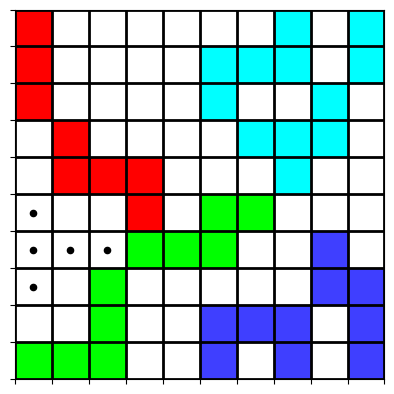

[[0.3697369  0.29480544 0.17764919 0.15780847]]
tensor([0., 0., 0., 1.])


In [101]:
boards, policies, values = test_data

# 1000 - pretty good, happy with red, shows green definitely is losing, etc

index = 700
board, policies, values = boards[index], policies[index], values[index]

display = Display(board, overlay_dots=MOVES["new_occupieds"][1118])
display.show()

values_logits_tensor, policy_logits_tensor = model(board.unsqueeze(0).to("mps"))
eval_values = torch.softmax(values_logits_tensor, dim=1).detach().cpu().numpy()
policy_logits = policy_logits_tensor.detach().cpu().numpy()

print(eval_values)
print(values)

In [102]:
np.argsort(policy_logits)[0][::-1][:10]

array([ 477,  362, 4234, 4061, 2809, 4355, 3469, 5587, 6049, 3953])

In [103]:
run.close()